In [265]:
from pylab import*
import matplotlib.pyplot as plt
import seaborn as sns
from h5py import File
import pandas as pd
from slab.dsfit import*
from slab import*
import json
import numpy as np
from datetime import datetime
import scipy as sc
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from qutip import *
from h5py import File
import os
from slab.dataanalysis import get_next_filename

# Fit functions

In [344]:
def coherent_state(n, alpha):
    return np.exp(-abs(alpha)**2)*abs(alpha)**(2*n)/scipy.special.factorial(n)

def line(x, m, b):
    return m*x+b

def proportional(x, m):
    return m * x

def gfromchi(chi,alpha,delta):
    return np.sqrt(chi*delta*(delta+alpha)/alpha)

def gaussfuncsum(p, x):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    return y

def gaussfuncsum_with_baseline(x, *args):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0 
    p = args
#     print(len(p))
    for ii in range(7):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    y += p[0]
    return y
def fitgausssum(xdata, ydata, fitparams=None, domain=None, showfit=False,
                showstartfit=False, label="", debug=False):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata, ydata, domain)
    else:
        fitdatax = xdata
        fitdatay = ydata
    
    if fitparams is None:
        fitparams = 0*ones(3*N+1)
        fitparams[0] = (fitdatay[0] + fitdatay[-1])/2.
        fitparams[1] = max(fitdatay) - min(fitdatay)
        fitparams[2] = fitdatax[np.argmax(fitdatay)]
        fitparams[3] = (max(fitdatax) - min(fitdatax))/10.
    
    if debug==True: 
        print(fitparams)
        
    p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum, fitparams, domain=None, showfit=showfit, 
                    showstartfit=showstartfit, label=label)
    p1[3]=abs(p1[3])
    
    return p1

def fitgausssum_with_baseline(xdata, ydata, fitparams=None):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    fitdatax = xdata
    fitdatay = ydata
#     if fitparams is None:
#         fitparams = 0*ones(3*N+1)
#         fitparams[0] = (fitdatay[0]+fitdatay[-1])/2.
#         fitparams[1] = max(fitdatay)-min(fitdatay)
#         fitparams[2] = fitdatax[np.argmax(fitdatay)]
#         fitparams[3] = (max(fitdatax)-min(fitdatax))/10.
    
#     p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum_with_baseline, fitparams, domain=None, showfit=showfit,
#                     showstartfit=showstartfit, label=label)
#     bounds=(0, [3., 1., 0.5])
        
    popt, pcov = curve_fit(gaussfuncsum_with_baseline, fitdatax, fitdatay, p0=fitparams, bounds=(0, np.inf))

    return popt, pcov

def fitamp(p1):
    fitamparray = []
    fitfreqarray = []
    n_peaks = int((len(p1)-1)/3)
    for i in range(n_peaks):
        fitamparray.append(p1[3*i+1])
        fitfreqarray.append(p1[3*i+2])
    return fitamparray , fitfreqarray

def fitcoherentstate(peak_val):
    xdata = np.arange(len(peak_val))
    ydata = peak_val
    popt, pcov = curve_fit(coherent_state, xdata, ydata)
    return popt[0], np.sqrt(pcov[0][0])

def expfunc2(x, p):
    """p[0]+p[1]*exp(-(x-p[2])/p[3])"""
    return p[0]*np.exp**(-(x-p[1])/p[2])

def fitexp2(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label=""):
    """Fit exponential decay (p[0]*exp(-(x-p[1])/p[2]))"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:    
        fitparams=[0.,0.,0.,0.]
        fitparams[0]=fitdatay[0]-fitdatay[-1]
        fitparams[1]=fitdatax[0]
        fitparams[2]=(fitdatax[-1]-fitdatax[0])/5.
    #print fitparams
    p1 = fitgeneral(fitdatax, fitdatay, expfunc2, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    return p1   

def expfunc_test(x, a, b, c):
    return b*np.exp(-(x-a)/c)

def expfunc_baseline(x, a, b, c):
    return a*np.exp(-x/b) + c

def doublegauss(bins, *p):
    a1, sigma1, mu1 = p[0], p[1], p[2]
    a2, sigma2, mu2 = p[3], p[4], p[5]

    y1 = a1*((1 / (np.sqrt(2 * np.pi) * sigma1)) *
     np.exp(-0.5 * (1 / sigma1 * (bins - mu1))**2))
    y2 = a2*((1 / (np.sqrt(2 * np.pi) * sigma2)) *
     np.exp(-0.5 * (1 / sigma2 * (bins - mu2))**2))
    y = y1+y2
    
    return y
def gaussian2d(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)


def hist(filename=None, data=None, plot=True, ran=1.0):
    
    if data == None:
        with File(filename,'r') as a:
            ig = array(a['ig'])
            qg = array(a['qg'])
            ie = array(a['ie'])
            qe = array(a['qe'])
            a.close()
    else:
        ig = data[0]
        qg = data[1]
        ie = data[2]
        qe = data[3]

    numbins = 200
    
    xg, yg = np.median(ig), np.median(qg)
    xe, ye = np.median(ie), np.median(qe)

    if plot==True:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
        fig.tight_layout()

        axs[0].scatter(ig, qg, label='g', color='b', marker='*')
        axs[0].scatter(ie, qe, label='e', color='r', marker='*')
        axs[0].scatter(xg, yg, color='k', marker='o')
        axs[0].scatter(xe, ye, color='k', marker='o')
        axs[0].set_xlabel('I (a.u.)')
        axs[0].set_ylabel('Q (a.u.)')
        axs[0].legend(loc='upper right')
        axs[0].set_title('Unrotated')
        axs[0].axis('equal')
    """Compute the rotation angle"""
    theta = -arctan((ye-yg)/(xe-xg))
    """Rotate the IQ data"""
    ig_new = ig*cos(theta) - qg*sin(theta)
    qg_new = ig*sin(theta) + qg*cos(theta) 
    ie_new = ie*cos(theta) - qe*sin(theta)
    qe_new = ie*sin(theta) + qe*cos(theta)
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)

    xlims = [xg-ran, xg+ran]
    ylims = [yg-ran, yg+ran]

    if plot==True:
        axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*')
        axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*')
        axs[1].scatter(xg, yg, color='k', marker='o')
        axs[1].scatter(xe, ye, color='k', marker='o')    
        axs[1].set_xlabel('I (a.u.)')
        axs[1].legend(loc='upper right')
        axs[1].set_title('Rotated')
        axs[1].axis('equal')

        """X and Y ranges for histogram"""
        
        ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
    #     popt, pcov = curve_fit(doublegauss, xdata=binsg[:-1], ydata=ng, p0=p0)
    #     mu_g = popt[2]
    #     axs[2].plot(binsg, doublegauss(binsg, *popt), 'k--', linewidth=2 )
        ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
    #     popt, pcov = curve_fit(doublegauss, xdata=binse[:-1], ydata=ne, p0=p0)
    #     mu_e = popt[5]
    #     axs[2].plot(binse, doublegauss(binse, *popt), 'k--', linewidth=2 )
    #     axs[2].text(0.5*(mu_g + mu_e), 0.3*np.max(ne), "$\mu_{g}$ = %.4f \n $\mu_{e}$ = %.4f"%(mu_g, mu_e), fontsize=16)

        axs[2].set_xlabel('I(a.u.)')        
        fig.show()
        
    else:        
        ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
        ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)

    """Compute the fidelity using overlap of the histograms"""
    fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum()))).max()

    return fid, theta

def rot_data(i, q, hist_filename=None):
    
    fid, theta = hist(hist_filename, ran=0.1)
    print(fid, theta)
    """Rotate the IQ data"""
    i_new = i*cos(theta) - q*sin(theta)
    q_new = i*sin(theta) + q*cos(theta) 
    
    return (i_new, q_new)


def ramsfit(tR, n0, phi0, a):
    T2 = 120e-6
    dephase = 1/T2
    detune = 2*np.pi*1e6 
    chi = 2*np.pi*380e3
    kappa = 2*np.pi*(8.0517e9)/8800
    tau = []
    z = []
    res = []
    for i,t in enumerate(tR):
        tau.append((1-np.exp(-complex(kappa*tR[i], 2*chi*tR[i])))/complex(kappa, 2*chi))
        z.append(np.exp(complex(-dephase*tR[i] , phi0 - detune*tR[i] - 2*n0*chi*tau[i])))
        res.append(a*0.5*(1-np.imag(z[i])))
    return np.array(res)

def cav_response_new(p, x):
    """(p[0]/p[1])/(-1/2*p[0]/p[1] - 1j*(x-p[0])"""
    ### p[0]=center freq, p[1]=kappa
    temp = (p[1])/(p[1] - 1j*(x-p[0]))
    return temp/max(abs(temp))

def IF_window(p,x):
    ### p[0] = center freq, p[1] = window width
    temp = zeros(len(x)) + 1j*zeros(len(x))
    for ii in range(len(x)):
        if x[ii]>(p[0]-p[1]) and x[ii]<(p[0]+p[1]):
            temp[ii] = 1/sqrt(2)*(1+1j)
        else:
            pass
    return temp/max(abs(temp))

def erf_t(A, sig, tc, tb, t):
    #A-Amplitude, sig-Gaussian Filter Width, tc-Core Pulse length, tb - zero-amplitude buffer length
    return (A/2)*(sc.special.erf((t-tb)/(sqrt(2)*sig))-sc.special.erf((t-tc-tb)/(sqrt(2)*sig)))

# Opt Pulse Generation

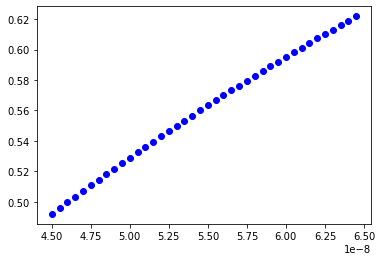

In [267]:
cav_freq = 0 #cavity frequency

Q = 8440 #cavity quality factor
kappa= (8.05183773e9)/Q
read_width = 600e-9 #readout length  in (seconds)
dt = 1e-9
n_points = int(read_width/dt)
#print(n_points)
pad_factor=10
t = dt*np.arange(0,n_points*pad_factor)
ifreq = np.fft.fftfreq(n_points*pad_factor,dt)
freq = np.fft.fftshift(ifreq)
if_band = IF_window([cav_freq,250e6],freq)
twochi = 380e3
pulse_len = 1/twochi

sigarray = np.arange(45e-9, 65e-9, 0.5e-9)
ratio = []

for sig in sigarray:
    desired_output = erf_t(1, sig, pulse_len, 1500e-9, t)

    desired_output_ifft = np.fft.fft(desired_output,n_points*pad_factor)/n_points
    desired_output_sfft = np.fft.fftshift(desired_output_ifft) #"sfft" denotes shifted spectrum to center at cav_freq

    lorenz_c = cav_response_new([cav_freq,kappa],freq)

    input_sfft = (desired_output_sfft/lorenz_c)*if_band

    output_sfft = input_sfft*lorenz_c
    output_fft = np.fft.ifftshift(output_sfft)
    output_pulse = np.fft.ifft(output_sfft)

    input_fft= np.fft.ifftshift(input_sfft)
    input_pulse = np.fft.ifft(input_fft)
    flip=input_pulse[::-1]

    opt_pulse = np.real(flip)
    
    max_opt = np.max(opt_pulse)
    mid_opt = opt_pulse[int(len(opt_pulse)/2)]
    
    ratio.append(mid_opt/max_opt)

plt.figure()
plt.plot(sigarray,ratio, 'bo')
plt.show()

In [268]:
len(t)

5990

In [269]:
ratio_targ = [0.65]
ratio=np.array(ratio)
ind_list = []
for rat in ratio_targ:
    index = np.argmin(abs(ratio-rat))
    ind_list.append(index)
    
ind_list = np.array(ind_list)
print(sigarray[ind_list])

[6.45e-08]


Text(0.5, 1.0, 'Input Pulse')

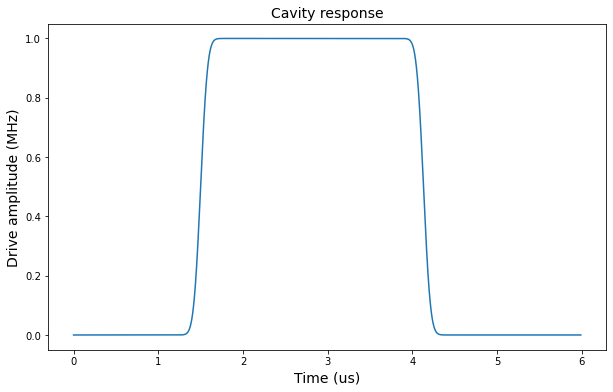

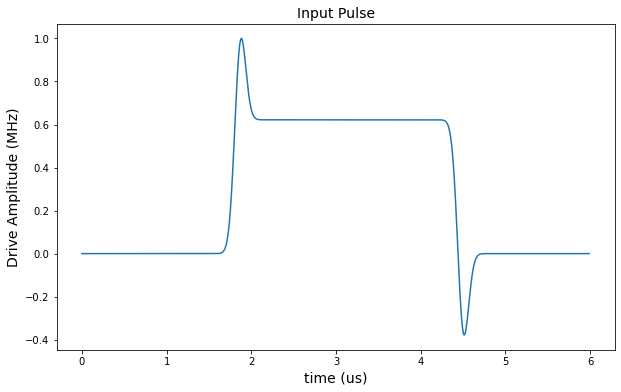

In [270]:
cav_freq = 0 #cavity frequency

Q = 8440 #cavity quality factor
kappa= (8.05183773e9)/Q
read_width = 600e-9 #readout length  in (seconds)
dt = 1e-9
n_points = int(read_width/dt)
#print(n_points)
pad_factor=10
t = dt*np.arange(0,n_points*pad_factor)
ifreq = np.fft.fftfreq(n_points*pad_factor,dt)
freq = np.fft.fftshift(ifreq)
if_band = IF_window([cav_freq,250e6],freq)
twochi = 380e3
pulse_len = 1/twochi

desired_output = erf_t(1, 6.45e-8, pulse_len, 1500e-9, t)

#Plot Desired Output
figure(figsize = (10,6))
plot(t*1e6, desired_output)
xlabel('Time (us)', fontsize =14)
ylabel('Drive amplitude (MHz)', fontsize =14)
title('Cavity response', fontsize =14)

#Generate Opt Input Pulse
desired_output_ifft = np.fft.fft(desired_output,n_points*pad_factor)/n_points
desired_output_sfft = np.fft.fftshift(desired_output_ifft) #"sfft" denotes shifted spectrum to center at cav_freq

lorenz_c = cav_response_new([cav_freq,kappa],freq)
lorenz_g = cav_response_new([cav_freq+0.2e6,Q],freq)
lorenz_e = cav_response_new([cav_freq-0.2e6,Q],freq)
lorenz= (lorenz_g*lorenz_e)

input_sfft = (desired_output_sfft/lorenz_c)*if_band

output_sfft = input_sfft*lorenz_c
output_fft = np.fft.ifftshift(output_sfft)
output_pulse = np.fft.ifft(output_sfft)

input_fft= np.fft.ifftshift(input_sfft)
input_pulse = np.fft.ifft(input_fft)
flip=input_pulse[::-1]

opt_pulse = np.real(flip)
opt_pulse = opt_pulse/np.max(opt_pulse)
#print(np.max(flip))

#Plot Generated Input Pulse
figure(figsize = (10,6))
plot(t*1.0e6,opt_pulse)
#plot(t*1.0e6,opt_pulse_im)
xlabel("time (us)", fontsize = 14)
ylabel("Drive Amplitude (MHz)", fontsize = 14)
title('Input Pulse', fontsize = 14)

## Trim Opt Pulse

In [271]:
#Find Desired Range
result1 = np.where(opt_pulse > 0.00001)
result2=np.where(opt_pulse < -0.00001)

#Trim Pulse
start_trim=result1[0][0]
end_trim=result2[0][len(result2[0])-1]
numb= end_trim - start_trim  
rem= numb % 4

#Check Total Length is Multiple of 4 for AWG
trim_pulse=opt_pulse[start_trim:end_trim - rem]
check = len(trim_pulse) % 4
print(check)

# Plot Final Pulse Shape
# plt.plot(t[0:len(trim_pulse)]*1.0e6,trim_stand_clear)
# print(trim_pulse)

0


## Save Opt Pulse Shape

In [272]:
path = os.getcwd()
data_path = os.path.join(path, "../pulses/")
seq_data_file = os.path.join(data_path,
                             get_next_filename(data_path, 'readout_optimal_pulse', suffix='.h5'))
print(seq_data_file)
with File(seq_data_file, 'w') as f:
    f.create_dataset("I_wf", data=trim_pulse)

C:\_Lib\python\slab\experiments\qm_opx\jupyter_notebooks\../pulses/00021_readout_optimal_pulse.h5


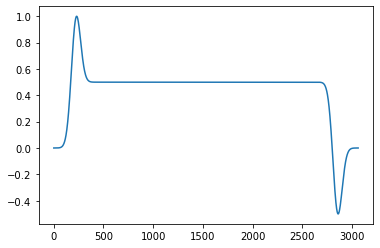

In [273]:
for i in [10]:
    opt_readout = "C:\\_Lib\\python\\slab\\experiments\\qm_opx\\pulses\\000{}_readout_optimal_pulse.h5".format(i)
    with File(opt_readout,'r') as a:
        opt_amp = np.array(a['I_wf'])
    opt_len = len(opt_amp)
    plt.figure()
    plt.plot(opt_amp)

# Resonator spectroscopy

fits =  [-7.22626340e-07  7.37545529e-04  8.05183773e+00  4.77002479e-04]
fits =  [-2.64383918e-07  5.45579242e-05  8.05185573e+00  4.81546863e-04]
fits =  [-1.44971726e-06  3.70118176e-04  8.05183470e+00  4.82774553e-04]
fits =  [-7.72430749e-06  1.30828807e-03  8.05182910e+00  5.50336600e-04]


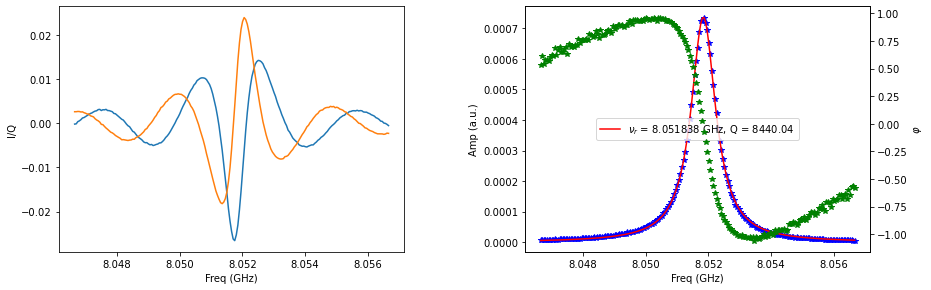

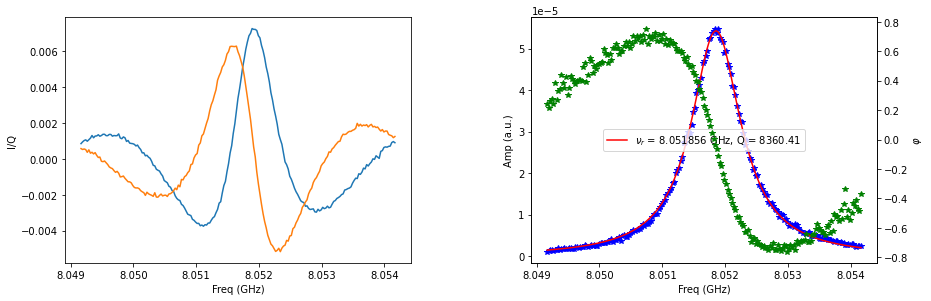

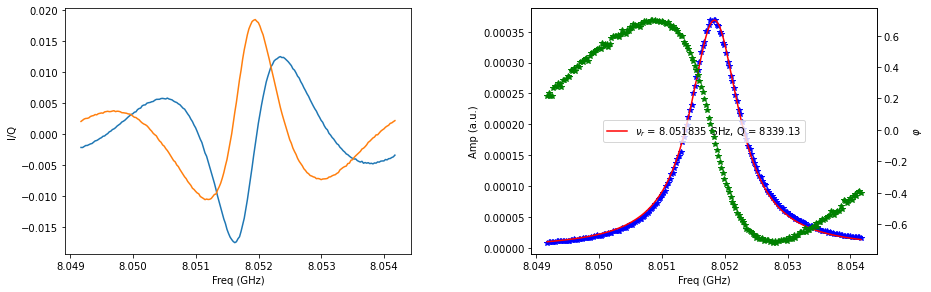

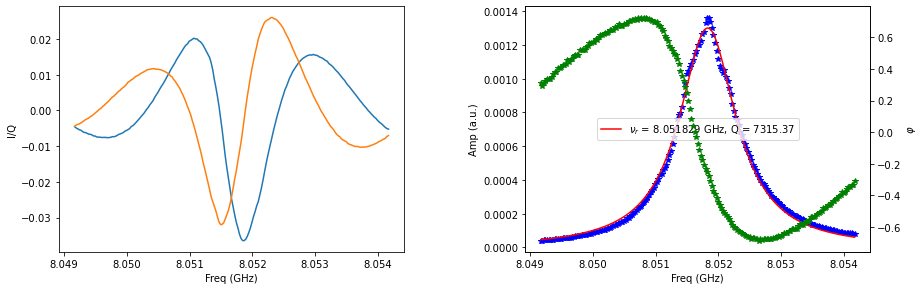

In [289]:
expt_name = 'resonator_spec'
filelist = [0, 40, 75, 88]
#3 - amp(0.5)
#4 - 8us long readout

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['freqs'])/1e9
        a.close()
        
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.35)
    axs[0].plot(x, I)
    axs[0].plot(x, Q)
    axs[0].set_xlabel('Freq (GHz)')
    axs[0].set_ylabel('I/Q')

    amps = Q**2 + I**2
    ph = np.arctan2(np.array(Q), np.array(I))
    ph = np.unwrap(ph, discont=3.141592653589793, axis=-1)
    m = (ph[-1]-ph[0])/(x[-1] - x[0])
    ph = ph - m*x*0.95
    ph = ph -np.mean(ph)
    axs[1].plot(x, amps, 'b*')
    p = fitlor(x, amps, showfit=False)
    q = p[2]/(2*p[3])
    axs[1].plot(x, lorfunc(p, x), label=r'$\nu_{r}$ = %.6f GHz, Q = %.2f'% (p[2], q), color='r')
    print ("fits = ", p)
    ax2  = axs[1].twinx()
    ax2.plot(x, ph, 'g*')
    axs[1].set_xlabel('Freq (GHz)')
    axs[1].set_ylabel('Amp (a.u.)')
    ax2.set_ylabel('$\\varphi$')
    axs[1].legend(loc='center')

fits =  [-1.25324606e-06  8.62685110e-05  8.05184589e+00  4.76398077e-04]
fits =  [-2.42234827e-09  8.75949477e-07  8.05184960e+00  4.58877307e-04]


KeyboardInterrupt: 

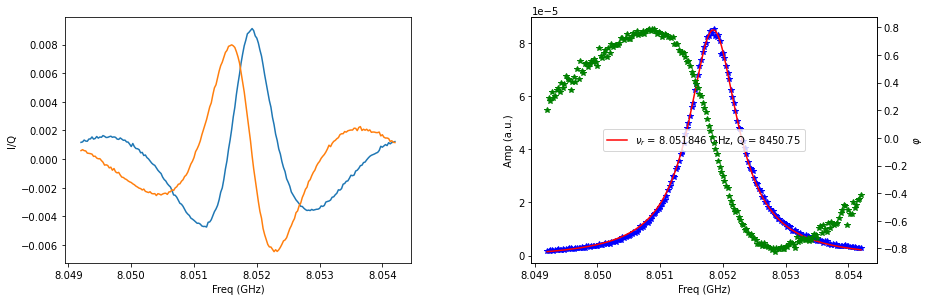

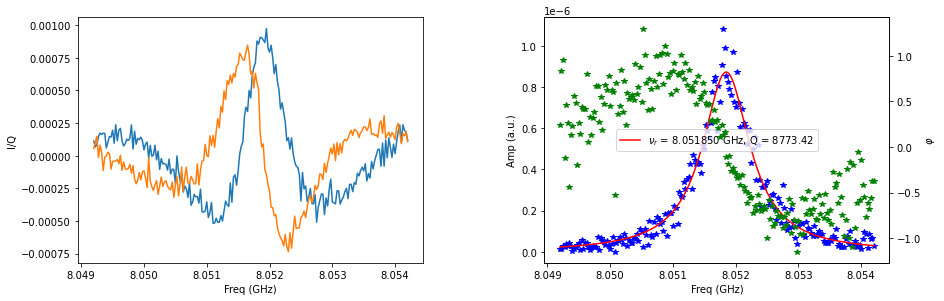

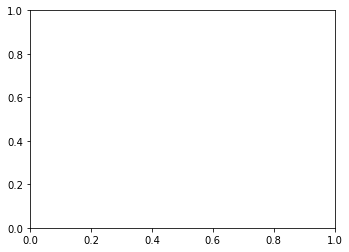

In [275]:
expt_name = 'resonator_spec_opt'
filelist = [0, 1, 6]
#3 - amp(0.5)
#4 - 8us long readout

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['freqs'])/1e9
        a.close()
        
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.35)
    axs[0].plot(x, I)
    axs[0].plot(x, Q)
    axs[0].set_xlabel('Freq (GHz)')
    axs[0].set_ylabel('I/Q')

    amps = Q**2 + I**2
    ph = np.arctan2(np.array(Q), np.array(I))
    ph = np.unwrap(ph, discont=3.141592653589793, axis=-1)
    m = (ph[-1]-ph[0])/(x[-1] - x[0])
    ph = ph - m*x*0.95
    ph = ph -np.mean(ph)
    axs[1].plot(x, amps, 'b*')
    p = fitlor(x, amps, showfit=False)
    q = p[2]/(2*p[3])
    axs[1].plot(x, lorfunc(p, x), label=r'$\nu_{r}$ = %.6f GHz, Q = %.2f'% (p[2], q), color='r')
    print ("fits = ", p)
    ax2  = axs[1].twinx()
    ax2.plot(x, ph, 'g*')
    axs[1].set_xlabel('Freq (GHz)')
    axs[1].set_ylabel('Amp (a.u.)')
    ax2.set_ylabel('$\\varphi$')
    axs[1].legend(loc='center')

In [ ]:
expt_name = 'resonator_spec_opt_power'
filelist = [1, 2, 3]
#3 - amp(0.5)
#4 - 8us long readout

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['freqs'])/1e9
        y = array(a['amps'])
        a.close()
                
    print(np.shape(I))
    fig, axs = plt.subplots(1, 1, figsize=(12, 4))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.35)
    amps = np.transpose(Q**2 + I**2)
#     ph = np.arctan2(np.array(Q), np.array(I))
#     ph = np.unwrap(ph, discont=3.141592653589793, axis=-1)
#     m = (ph[-1]-ph[0])/(x[-1] - x[0])
#     ph = ph - m*x*0.95
#     ph = ph -np.mean(ph)
    axs.pcolormesh(x, y, amps)
#     p = fitlor(x, amps, showfit=False)
#     q = p[2]/(2*p[3])
#     axs.plot(x, lorfunc(p, x), label=r'$\nu_{r}$ = %.6f GHz, Q = %.2f'% (p[2], q), color='r')
#     print ("fits = ", p)
#     ax2  = axs[1].twinx()
#     ax2.plot(x, ph, 'g*')
    axs.set_xlabel('Freq (GHz)')
    axs.set_ylabel('Amp (a.u.)')
#     axs.set_xlim(8.051, 8.053)
#     ax2.set_ylabel('$\\varphi$')
#     axs.legend(loc='center')
    plt.show()

# Resonator Chi

In [ ]:
expt_name = 'resonator_chi'
filelist = [2, 3,  19, 27]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        ig = np.array(a['Ig']) 
        qg = np.array(a['Qg']) 
        ie = np.array(a['Ie']) 
        qe = np.array(a['Qe']) 
        freq = np.array(a["freqs"]) 
        a.close()

    amps_g = (ig**2 + qg**2)
    amps_e = (ie**2 + qe**2)
    f = np.array(freq/1e9)

    fig, ax1 = plt.subplots(1, 1, dpi=300)
    ax1.plot(f, amps_g, 'b*', label='g')
    ax1.plot(f, amps_e, 'g*', label='e')
    ax1.set_xlim(8.05, 8.0535)
    pg = fitlor(f, amps_g, showfit=False)
    ax1.plot(f, lorfunc(pg, f), 'r')
    plt.axvline(x=pg[2], color='k', linestyle='--')
    pe = fitlor(f, amps_e, showfit=False)
    ax1.plot(f, lorfunc(pe, f), 'r')
    plt.axvline(x=pe[2], color='k', linestyle='--')
    chi = (pg[2]-pe[2])*1e6
    plt.text(np.mean(f), np.max(amps_e)*0.5, '2χ = %.3f kHz'%chi)
    plt.legend(loc='best')
    plt.xlabel('Freq (GHz)')
    plt.ylabel('Amp. (a.u.)')
    fig.tight_layout()
#     plt.savefig('../plots/readout_chi.png', dpi=300)
    plt.show()

In [ ]:
0.5*(pg[2]+ pe[2])

In [ ]:
pg[2]

In [ ]:
chi_mem_qubit = 1.13e6
t_min = int((np.pi/chi_mem_qubit)*1e9/4 * 0.5)
t_max = int((np.pi/chi_mem_qubit)*1e9/4 * 1.5)
print(t_min, t_max)

In [ ]:
plt.scatter(ig, qg, color='g', marker='*')
plt.scatter(ie, qe, color='b', marker='*')

In [ ]:
expt_name = 'resonator_jpa'
filelist = [0, 14]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        ig = np.array(a['Ig']) 
        qg = np.array(a['Qg']) 
        ie = np.array(a['Ie']) 
        qe = np.array(a['Qe']) 
        freq = np.array(a["freqs"]) 
        a.close()

    amps_g = (ig**2 + qg**2)
    amps_e = (ie**2 + qe**2)
    f = np.array(freq/1e9)

    fig, ax1 = plt.subplots(1, 1, dpi=300)
    ax1.plot(f, amps_g, 'b*', label='JPA Off')
    ax1.plot(f, amps_e, 'g*', label='JPA On')
    ax1.set_xlim(8.05, 8.0535)
    pg = fitlor(f, amps_g, showfit=False)
#     ax1.plot(f, lorfunc(pg, f), 'r')
    plt.axvline(x=pg[2], color='k', linestyle='--')
    pe = fitlor(f, amps_e, showfit=False)
#     ax1.plot(f, lorfunc(pe, f), 'r')
    plt.axvline(x=pe[2], color='k', linestyle='--')
    chi = (pg[2]-pe[2])*1e6
#     plt.text(np.mean(f), np.max(amps_e)*0.5, '2χ = %.3f kHz'%chi)
    plt.legend(loc='best')
    plt.xlabel('Freq (GHz)')
    plt.ylabel('Amp. (a.u.)')
#     plt.ylim(0, 25e-5)
    fig.tight_layout()
#     plt.savefig('../plots/readout_chi.png', dpi=300)
    plt.show()

In [ ]:
pg[2]/(2*pg[3])

# Qubit ge spectroscopy

In [ ]:
expt_name = 'ge_spectroscopy'
filelist = [0, 42]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['freqs'])/1e9
        a.close()
        
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.35)
    axs[0].plot(x, I)
    axs[0].plot(x, Q)
    axs[0].set_xlabel('Freq (GHz)')
    axs[0].set_ylabel('I/Q')
    amps = -np.sqrt(np.array(I)**2 + 1*np.array(Q)**2)
#     amps = Q
    ph = np.arctan2(np.array(Q), np.array(I))
    ph = np.unwrap(ph, discont=3.141592653589793, axis=-1)
    m = (ph[-1]-ph[0])/(x[-1] - x[0])
    ph = ph - m*x*0.95
    ph = ph -np.mean(ph)
    axs[1].plot(x, amps, 'b-')
    p = fitlor(x, amps, showfit=False)
    q = p[2]/(2*p[3])
    axs[1].plot(x, lorfunc(p, x), label=r'$\nu_{r}$ = %.6f GHz, Q = %.2f'% (p[2], q))
    print ("fits = ", p)
    ax2  = axs[1].twinx()
    ax2.plot(x, ph, 'r-')
    axs[1].set_xlabel('Freq (GHz)')
    axs[1].set_ylabel('Amp (a.u.)')
    ax2.set_ylabel('$\\varphi$')
    axs[1].legend(loc='best')

In [ ]:
plt.figure(dpi=300)
plt.axis(False)

x = np.linspace(-1, 1, 1001)
y = np.random.normal(0, 0.02, 1001)
y[500] =0.25 
plt.plot(x, y, 'g', linewidth=3)

plt.ylim(-0.5, 0.5)
plt.xlim(-0.25, 0.25)

plt.tight_layout()
plt.savefig('axion.png', dpi=300,transparent=True)
plt.show()

## ef spectroscopy

In [ ]:
expt_name = 'ef_spectroscopy'
filelist = [0]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['freqs'])/1e9
        a.close()
        
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.35)
    axs[0].plot(x, I)
    axs[0].plot(x, Q)
    axs[0].set_xlabel('Freq (GHz)')
    axs[0].set_ylabel('I/Q')
    amps = -np.sqrt(np.array(I)**2 + 1*np.array(Q)**2)
#     amps = Q
    ph = np.arctan2(np.array(Q), np.array(I))
    ph = np.unwrap(ph, discont=3.141592653589793, axis=-1)
    m = (ph[-1]-ph[0])/(x[-1] - x[0])
    ph = ph - m*x*0.95
    ph = ph -np.mean(ph)
    axs[1].plot(x, amps, 'b-')
    p = fitlor(x, amps, showfit=False)
    q = p[2]/(2*p[3])
    axs[1].plot(x, lorfunc(p, x), label=r'$\nu_{r}$ = %.6f GHz, Q = %.2f'% (p[2], q))
    print ("fits = ", p)
    ax2  = axs[1].twinx()
    ax2.plot(x, ph, 'r-')
    axs[1].set_xlabel('Freq (GHz)')
    axs[1].set_ylabel('Amp (a.u.)')
    ax2.set_ylabel('$\\varphi$')
    axs[1].legend(loc='best')

# Ramsey

In [ ]:
expt_name = 'Ramsey'
filelist = [0, 22, 58]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        t = array(a['time'])
        ramsey_freq = array(a['ramsey_freq'])/1e6
        qubit_freq = array(a['qubit_freq'])/1e9
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        P = Q
        p = fitdecaysin(t[:], P[:],fitparams = None, showfit=False)
        ax.plot(t, P, 'bo--',label = 'Q')
        ax.plot(t[:], decaysin(np.append(p, 0), t[:]), 'r-', label=r'fit, $T_{2}^{*}$ = %.2f $\mu$s' % p[3])
        offset = ramsey_freq - p[1]
        nu_q_new = qubit_freq + offset/1e3
        print("Original qubit frequency choice =", qubit_freq,"GHz")
        print ("Oscillation freq = ", p[1]," MHz")
        print("Offset freq =", offset,"MHz")
        print("Suggested qubit frequency choice =", nu_q_new,"GHz")
        print("T2* =", p[3],"us")
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel('Q')
        ax.legend()

## Ramsey JPA

In [ ]:
expt_name = 'Ramsey_jpa'
filelist = [0, 1]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        t = array(a['time'])
        ramsey_freq = array(a['ramsey_freq'])/1e6
        qubit_freq = array(a['qubit_freq'])/1e9
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        P = Q
        p = fitdecaysin(t[:], P[:],fitparams = None, showfit=False)
        ax.plot(t, P, 'bo--',label = 'Q')
        ax.plot(t[:], decaysin(np.append(p, 0), t[:]), 'r-', label=r'fit, $T_{2}^{*}$ = %.2f $\mu$s' % p[3])
        offset = ramsey_freq - p[1]
        nu_q_new = qubit_freq + offset/1e3
        print("Original qubit frequency choice =", qubit_freq,"GHz")
        print ("Oscillation freq = ", p[1]," MHz")
        print("Offset freq =", offset,"MHz")
        print("Suggested qubit frequency choice =", nu_q_new,"GHz")
        print("T2* =", p[3],"us")
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel('Q')
        ax.legend()

# Ramsey Phase

Original qubit frequency choice = 4.746910599438208 GHz
Oscillation freq =  0.0999671987344142  MHz
Offset freq = 3.280126558580232e-05 MHz
Suggested qubit frequency choice = 4.746910632239474 GHz
T2* = 128.90311883078616 us
Original qubit frequency choice = 4.74689039569529 GHz
Oscillation freq =  0.09838509061470999  MHz
Offset freq = 0.0016149093852900198 MHz
Suggested qubit frequency choice = 4.746892010604675 GHz
T2* = 135.52514203825777 us


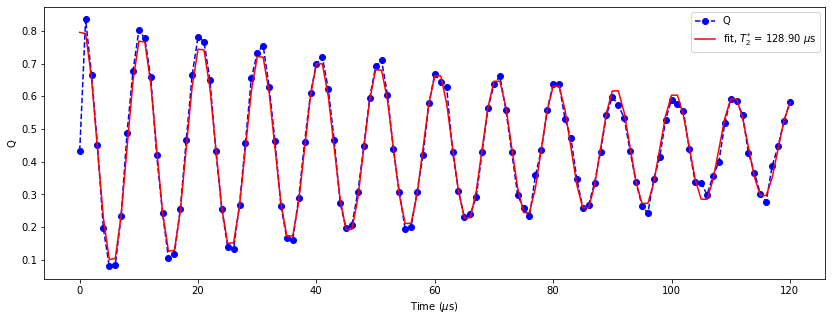

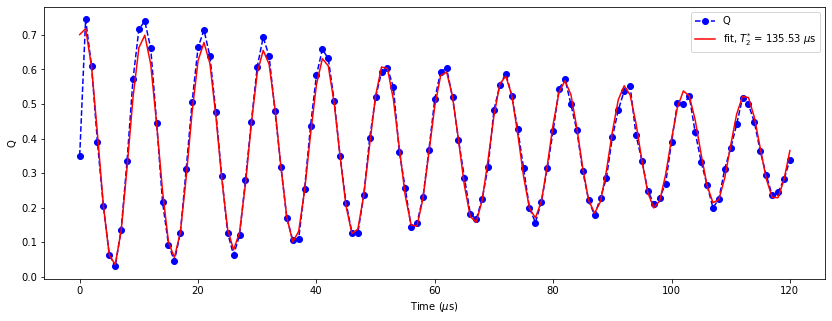

In [774]:
expt_name = 'Ramsey_phase'
filelist = [28, 217]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        t = array(a['time'])
        ramsey_freq = array(a['ramsey_freq'])/1e6
        qubit_freq = array(a['qubit_freq'])/1e9
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        P = Q
        
        p = fitdecaysin(t[:], P[:],fitparams = None, showfit=False)
        ax.plot(t, P, 'bo--',label = 'Q')
        ax.plot(t[:], decaysin(np.append(p, 0), t[:]), 'r-', label=r'fit, $T_{2}^{*}$ = %.2f $\mu$s' % p[3])
        offset = ramsey_freq - p[1]
        nu_q_new = qubit_freq + offset/1e3
        print("Original qubit frequency choice =", qubit_freq,"GHz")
        print ("Oscillation freq = ", p[1]," MHz")
        print("Offset freq =", offset,"MHz")
        print("Suggested qubit frequency choice =", nu_q_new,"GHz")
        print("T2* =", p[3],"us")
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel('Q')
        ax.legend()

## ef Ramsey

In [ ]:
expt_name = 'ef_Ramsey_phase'
filelist = [1, 6]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        t = array(a['time'])
        ramsey_freq = array(a['ramsey_freq'])/1e6
        qubit_freq = array(a['qubit_freq'])/1e9
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        P = Q
        
        p = fitdecaysin(t[:], P[:],fitparams = None, showfit=False)
        ax.plot(t, P, 'bo--',label = 'Q')
        ax.plot(t[:], decaysin(np.append(p, 0), t[:]), 'r-', label=r'fit, $T_{2}^{*}$ = %.2f $\mu$s' % p[3])
        offset = ramsey_freq - p[1]
        nu_q_new = qubit_freq + offset/1e3
        print("Original qubit frequency choice =", qubit_freq,"GHz")
        print ("Oscillation freq = ", p[1]," MHz")
        print("Offset freq =", offset,"MHz")
        print("Suggested qubit frequency choice =", nu_q_new,"GHz")
        print("T2* =", p[3],"us")
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel('Q')
        ax.legend()

# Power Rabi

Suggested π amp = 0.3506
0.811 0.162
Suggested π amp = 0.5244
0.7345 0.0


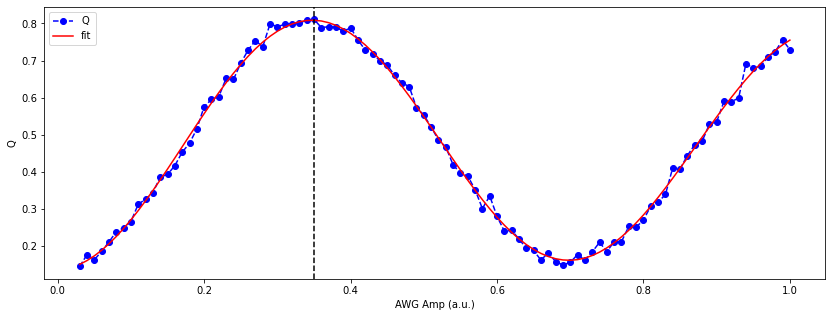

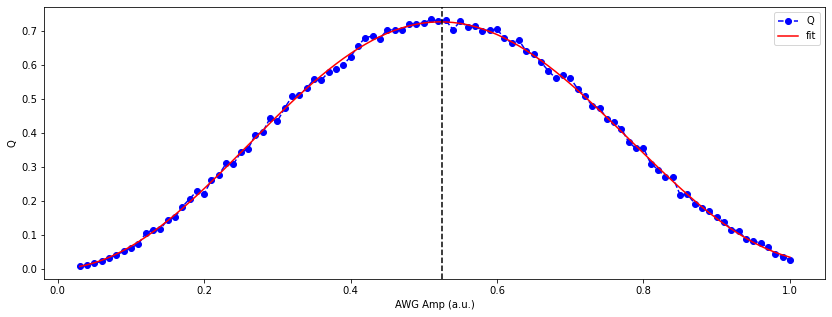

In [775]:
expt_name = 'power_rabi'
filelist = [111, 255]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['amps'])
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        y = Q[3:]
        x = x[3:]
        p = fitdecaysin(x[:], y[:],fitparams = None, showfit=False)
        ax.plot(x, y, 'bo--',label = 'Q')
        ax.plot(x[:], decaysin(np.append(p, 0), x[:]), 'r-', label=r'fit')
        print("Suggested π amp = %.4f" %(1/2/p[1]))
        ax.axvline(1/2/p[1], color='k', linestyle='--')
        ax.set_xlabel('AWG Amp (a.u.)')
        ax.set_ylabel('Q')
        ax.legend()
        
        print(max(Q), Q[0])

## ef Power Rabi

In [ ]:
expt_name = 'ef_power_rabi'
filelist = [0, 10]
freq = []
t2 = []

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['amps'])
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        y = I
        p = fitdecaysin(x[:], y[:],fitparams = None, showfit=False)
        ax.plot(x, y, 'bo--',label = 'Q')
        ax.plot(x[:], decaysin(np.append(p, 0), x[:]), 'r-', label=r'fit')
        print("Suggested π amp = %.4f" %(1/2/p[1]))
        ax.axvline(1/2/p[1], color='k', linestyle='--')
        ax.set_xlabel('AWG Amp (a.u.)')
        ax.set_ylabel('Q')
        ax.legend()

# ge Weak Rabi

Suggested π amp = 0.0037
0.7353 0.0235
Suggested π amp = 0.0041
0.0045644832227 -0.0029888062686
Suggested π amp = 0.0068
0.909 0.002


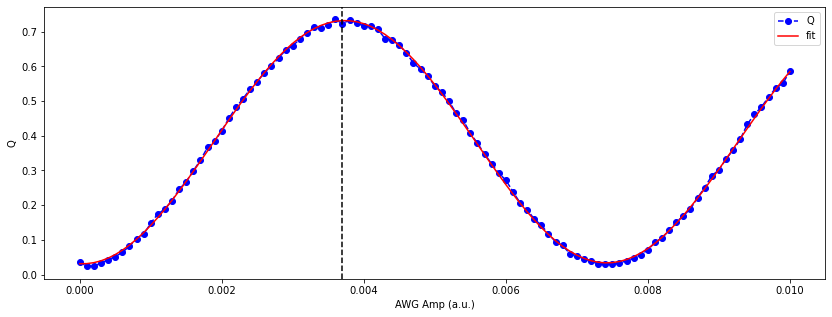

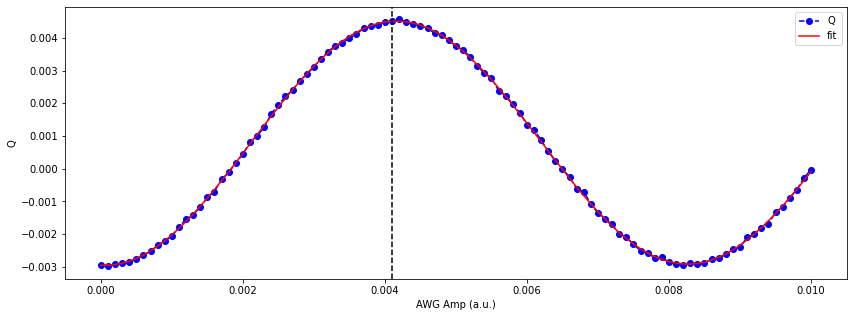

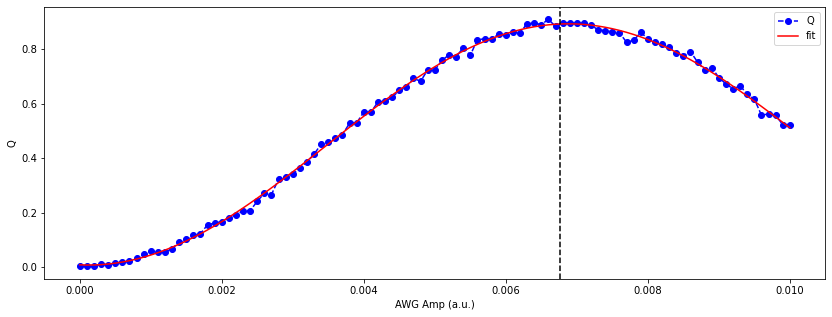

In [766]:
expt_name = 'weak_rabi'
filelist = [1, 11, 27]
freq = []
t2 = []

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['amps'])
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        y = Q
        p = fitdecaysin(x[:], y[:],fitparams = None, showfit=False)
        ax.plot(x, y, 'bo--',label = 'Q')
        ax.plot(x[:], decaysin(np.append(p, 0), x[:]), 'r-', label=r'fit')
        print("Suggested π amp = %.4f" %(1/2/p[1]))
        ax.axvline(1/2/p[1], color='k', linestyle='--')
        ax.set_xlabel('AWG Amp (a.u.)')
        ax.set_ylabel('Q')
        ax.legend()
        print(max(Q), min(Q))

# T1

In [ ]:
expt_name = 't1'
filelist = [34, 35, 52, 55]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['res'])
        x = array(a['time'])/1e3
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        y = Q
        p = fitexp(x, y, showfit=False)
        print("T1: %.3f μs"%(p[3]))
        ax.plot(x, y, 'bo--')
        ax.plot(x[:], expfunc(p, x[:]), 'r-', label='T1: %.3f $\mu$s'%(p[3]))
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel('Q')
        ax.legend()
        print(max(Q), min(Q))

## ef T1

In [ ]:
expt_name = 'ef_t1'
filelist = [1]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['times'])/1e3
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        y = I
        p = fitexp(x, y, showfit=False)
        print("T1: %.3f μs"%(p[3]))
        ax.plot(x, y, 'bo--')
        ax.plot(x[:], expfunc(p, x[:]), 'r-', label='T1: %.3f $\mu$s'%(p[3]))
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel('Q')
        ax.legend()


## Storage T1

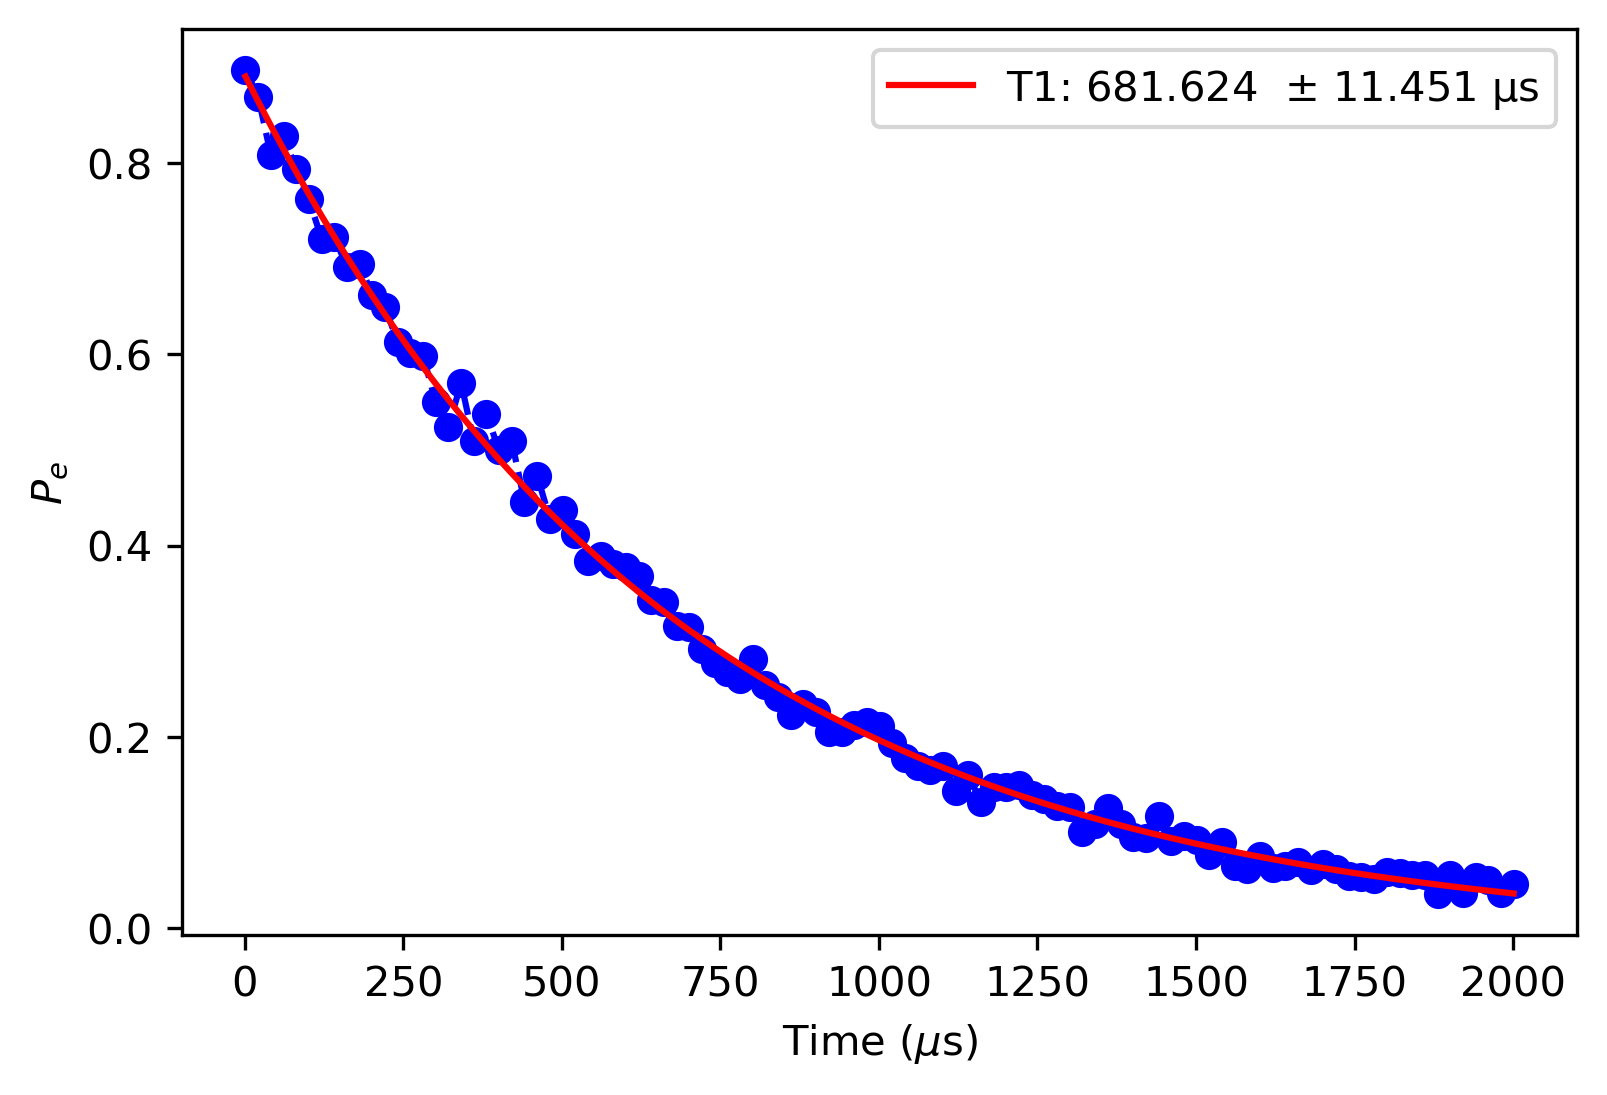

In [751]:
expt_name = 'storage_t1'
filelist = [7]
cal = [0.949, 0.011]
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['res'])
        x = array(a['time'])/1e3
        
        fig, ax = plt.subplots(1, 1, dpi=300)

        y = (Q - cal[1])/cal[0]

        popt, pcov = curve_fit(expfunc_baseline, x, y)
        ax.plot(x, y, 'bo--')
        ax.plot(x, expfunc_baseline(x, *popt), 'r-', label=r"T1: %.3f  $\pm$ %.3f μs"%(popt[1], np.sqrt(np.diag(pcov)[1])))
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel(r'$P_{e}$')
        ax.legend()
        plt.show()


# Qubit temperature

In [ ]:
expt_name = 'qubit_temp'
filelist = [6, 9, 11]

def temperature_q(nu, rat):
    Kb = 1.38e-23
    h = 6e-34
    return h*nu/(Kb*log(1/rat))

def occupation_q(nu,T):
    Kb = 1.38e-23
    h = 6e-34
    T = T*1e-3
    return 1/(exp(h*nu/(Kb*T))+1)

q_pop = []

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        Ie = array(a['Ie'])[:-10]
        Qe = array(a['Qe'])[:-10]
        Ig = array(a['Ig'])[:-10]
        Qg = array(a['Qg'])[:-10]

        x = array(a['amps'])[:-10]
        
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(14,5))
        axs.plot(x, Ig,'bo',label = 'ge π ')
        axs.plot(x, Ie,'go',label = 'No π ')        
        axs.set_xlabel('AWG amp (a.u.)')
        axs.set_ylabel('I(V)')
        axs.legend()
        pg = fitdecaysin(x, Ig, showfit=False)
        print(pg)
        axs.plot(x, decaysin(np.append(pg, 0), x), 'r')
        pe = fitdecaysin(x, Ie, showfit=False)
        print(pe)
        axs.plot(x, decaysin(np.append(pe, 0), x), 'r')
        
        contrast_g = pg[0]
        contrast_e = pe[0]
#         ax.set_ylim(0.8, 0.95)
    nu_q = 4.7469105
    ratio = abs(contrast_e/contrast_g)
    print ("ge contrast ratio = ", ratio)
    print ("Qubit Temp:" , 1e3*temperature_q(nu_q*1e9,ratio)," mK" )
    print ("Qubit Excited State Occupation:" , occupation_q(nu_q, 1e3*temperature_q(nu_q,ratio)))
    q_pop.append(occupation_q(nu_q, 1e3*temperature_q(nu_q, ratio)))

In [ ]:
plt.plot(Qe, 'go')

# Histogram 

## Discriminator optimal weight

In [655]:
expt_name = 'histogram_disc'
filelist = [1]
for ii, i in enumerate(filelist[::-1]):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:
#         ig = np.array(a['I'][:15000])
#         qg = np.array(a['Q'][:15000])
#         ie = np.array(a['I'][15000:])
#         qe = np.array(a['Q'][15000:])
        I = np.array(a['I'])
        Q = np.array(a['Q'])
        seq0 = np.array(a['seq0'])
        avgs = int(np.array(a['avgs']))
        a.close()

OSError: Unable to open file (unable to open file: name = '..\data\00001_histogram_disc.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [652]:
plt.figure()
plt.hist(I[np.array(seq0) == 0], 50)
plt.hist(I[np.array(seq0) == 1], 50)
# plt.hist(ie, 50)
# plt.plot([discriminator.get_threshold()] * 2, [0, 60], 'g')
plt.show()


NameError: name 'seq0' is not defined

<Figure size 432x288 with 0 Axes>

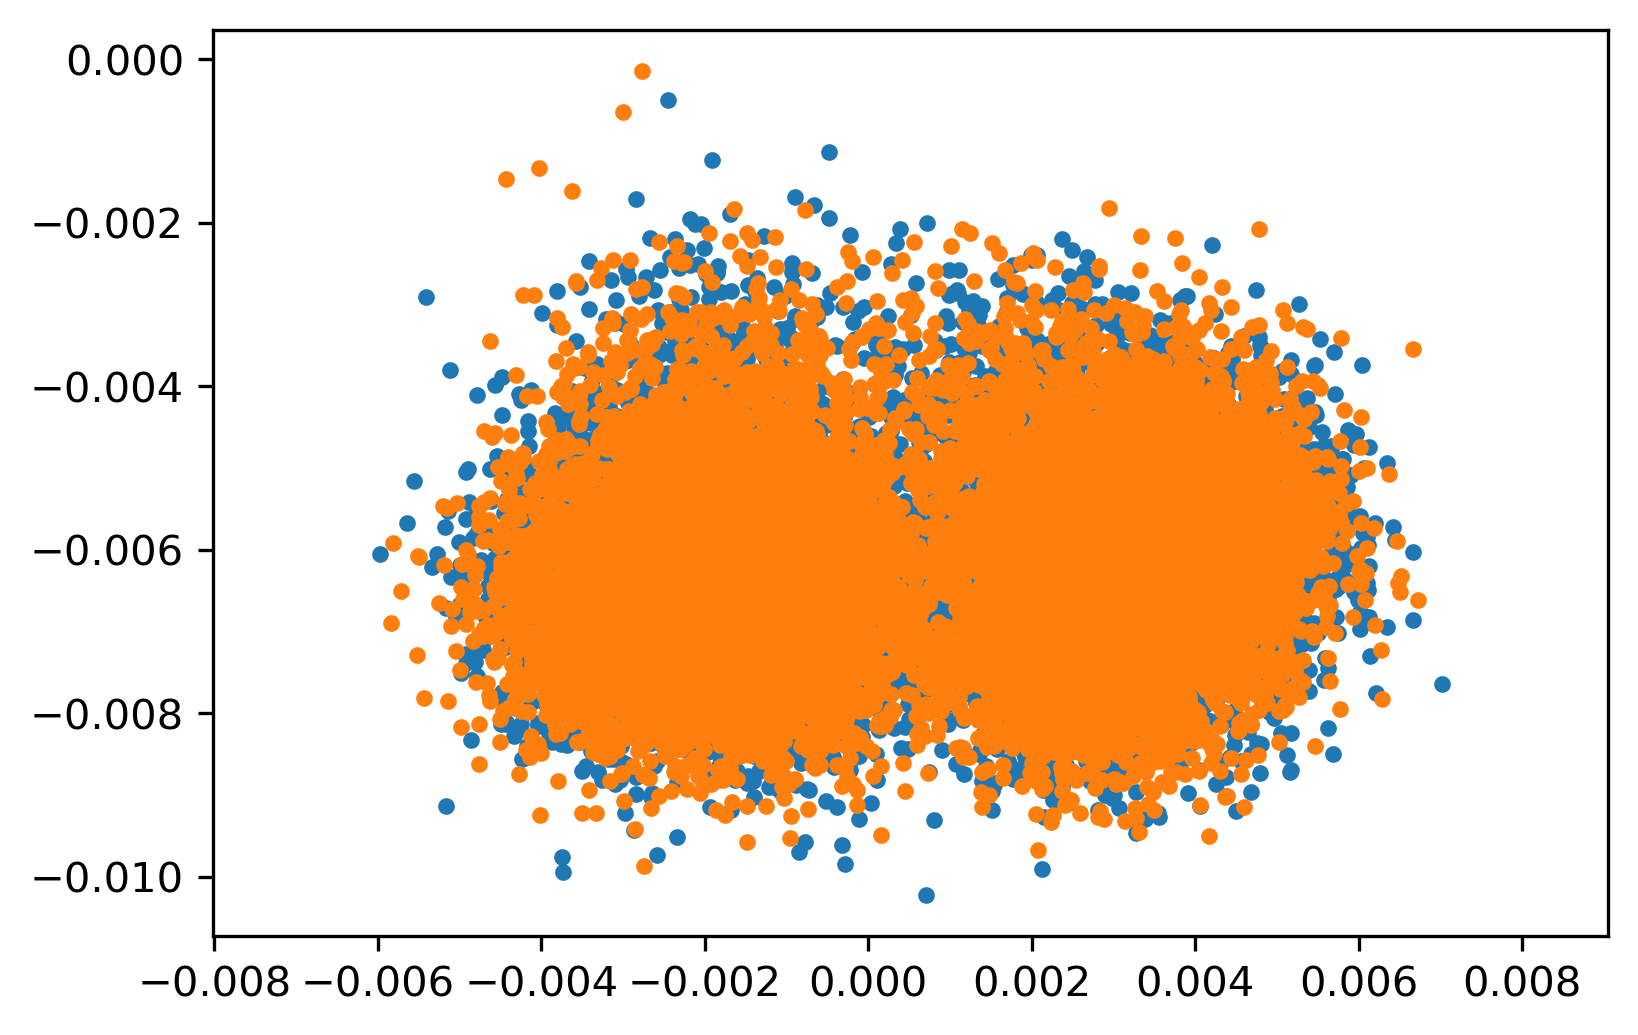

In [645]:
plt.figure(dpi=300)
plt.plot(ig, qg, '.')
plt.plot(ie, qe, '.')
plt.axis('equal')
plt.show()

## Square

In [ ]:
expt_name = 'histogram'
filelist = [35,  160, 165, 171]

for ii, i in enumerate(filelist[::-1]):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    fid, angle = hist(filename, data=None,  plot=True, ran=0.05)
    print('Optimal fidelity after rotation = %.3f'%fid)

In [ ]:
expt_name = 'histogram'
filelist = [171]
for ii, i in enumerate(filelist[::-1]):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:
        ig = np.array(a['ig'])
        qg = np.array(a['qg'])
        ie = np.array(a['ie'])
        qe = np.array(a['qe'])
        a.close()

sns.set_theme(style="dark")


# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=ig, y=qg, s=5, color=".15")
sns.histplot(x=ig, y=qg, bins=50, pthresh=.1, cmap="mako")
# sns.kdeplot(x=ig, y=qg, levels=5, color="w", linewidths=1)
ax.set(xlabel='I(V)', ylabel='Q (V)')
sns.scatterplot(x=ie, y=qe, s=5, color=".15")
sns.histplot(x=ie, y=qe, bins=50, pthresh=.1, cmap="mako")
# sns.kdeplot(x=ie, y=qe, levels=5, color="w", linewidths=1)

plt.show()

### Freq and amp sweep

In [ ]:
expt_name = 'histogram_freq_amp_sweep'
filelist = [13]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        attens = array(a['amp'])
        freqs = array(a['freq'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 5000
    for ii in range(len(attens)):
        """Select all the rows corresponding to the same readout power"""
        ig, qg = Ig.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qg.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        ie, qe = Ie.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qe.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        fid_freq = []
        """For the same readout power, compute the g|e fidelity corresponding to each readout frequency"""
        for jj in range(len(freqs)):
            a = ig.iloc[jj:(jj+1)*avgs]
            b = qg.iloc[jj:(jj+1)*avgs]
            c = ie.iloc[jj:(jj+1)*avgs]
            d = qe.iloc[jj:(jj+1)*avgs]
            data = [a, b, c, d]
            fid, angle = hist(filename=None, data=data, plot=False, ran=0.05)
            fid_freq.append(fid)
        fid_f_p.append(fid_freq)
        
    ind = np.argmax(fid_f_p)
    fid_max = np.max(fid_f_p)
    print(ind, fid_max)

    plt.figure(dpi=300)
    plt.pcolormesh(freqs/1e6, attens, fid_f_p, shading='auto')
    cbar = plt.colorbar()
    cbar.minorticks_on()
    cbar.set_label('g-e Fidelity')
    plt.title(r'$\nu$ = %.3f MHz, Amp = %.3f '%(freqs[ind%len(freqs)]/1e6, attens[ind//len(freqs)]))
    plt.xlabel(r'$\Delta \nu_{IF}$ MHz')
    plt.ylabel('AWG Amp.')
    plt.axvline(x = freqs[ind%len(freqs)]/1e6, linestyle='--', color='k')
    plt.axhline(y = attens[ind//len(freqs)], linestyle='--', color='k')
    plt.show()

In [ ]:
plt.plot(np.array(a), np.array(b), '.')
plt.plot(np.array(c), np.array(d), '.')

In [ ]:
freqs[ind%len(freqs)]/1e6, attens[ind//len(freqs)]

### Amp sweep 

In [ ]:
expt_name = 'histogram_amp_sweep'
filelist = [22]
#7 - 3us long pulse
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        amp = array(a['amp'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 5000
    for ii in range(len(amp)):
        """Select all the rows corresponding to the same readout power"""
        a, b = Ig.iloc[ii*avgs: (ii+1)*avgs], Qg.iloc[ii*avgs: (ii+1)*avgs]
        c, d = Ie.iloc[ii*avgs: (ii+1)*avgs], Qe.iloc[ii*avgs: (ii+1)*avgs]
        data = [a, b, c, d]
        fid, angle = hist(filename=None, data=data, plot=False, ran=0.05)
        fid_f_p.append(fid)

    plt.figure(dpi=300)
    plt.plot(amp, fid_f_p, 'b*')
    plt.title('Max. fidelity = %.3f at %.4f'%(max(fid_f_p), amp[np.argmax(fid_f_p)]))
    plt.xlabel('Awg amp.')
    plt.ylabel('g-e fidelity')
    plt.show()

In [ ]:
ii = np.argmax(fid_f_p)
ii = np.argmin(abs(np.array(fid_f_p)-0.75))
print(amp[ii], fid_f_p[ii])
a, b = np.array(Ig.iloc[ii*avgs: (ii+1)*avgs]), np.array(Qg.iloc[ii*avgs: (ii+1)*avgs])
c, d = np.array(Ie.iloc[ii*avgs: (ii+1)*avgs]), np.array(Qe.iloc[ii*avgs: (ii+1)*avgs])

plt.figure(dpi=300)
plt.plot(a, b, '.', alpha=0.25)
plt.plot(c, d, '.', alpha=0.25)
plt.axis('equal')
plt.show()

### Freq sweep

In [ ]:
expt_name = 'histogram_freq_sweep'
filelist = [3]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        freq = array(a['freq'])/1e6
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 5000
    for ii in range(len(freq)):
        """Select all the rows corresponding to the same readout power"""
        a, b = Ig.iloc[ii*avgs: (ii+1)*avgs], Qg.iloc[ii*avgs: (ii+1)*avgs]
        c, d = Ie.iloc[ii*avgs: (ii+1)*avgs], Qe.iloc[ii*avgs: (ii+1)*avgs]
        data = [a, b, c, d]
        fid, angle = hist(filename=None, data=data, plot=False, ran=0.05)
        fid_f_p.append(fid)

plt.figure(dpi=300)
plt.plot(freq, fid_f_p, 'b*')
plt.title('Max. fidelity = %.3f at %.4f'%(max(fid_f_p), freq[np.argmax(fid_f_p)]))
plt.xlabel(r'$\Delta \nu_{IF}$ MHz')
plt.ylabel('g-e fidelity')
plt.show()
print(max(fid_f_p))

### rr and jpa amp sweep

In [ ]:
expt_name = 'histogram_jpa_rr_amp_sweep'
filelist = [0]
#1- 3us long
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        amp = array(a['amp'])
        pamp = array(a['pamp'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 3000
    for ii in range(len(amp)):
        """Select all the rows corresponding to the same readout power"""
        ig, qg = Ig.iloc[ii*len(pamp)*avgs: (ii+1)*len(pamp)*avgs], Qg.iloc[ii*len(pamp)*avgs: (ii+1)*len(pamp)*avgs]
        ie, qe = Ie.iloc[ii*len(pamp)*avgs: (ii+1)*len(pamp)*avgs], Qe.iloc[ii*len(pamp)*avgs: (ii+1)*len(pamp)*avgs]
        fid_freq = []
        """For the same readout power, compute the g|e fidelity corresponding to each readout frequency"""
        for jj in range(len(pamp)):
            a = ig.iloc[jj:(jj+1)*avgs]
            b = qg.iloc[jj:(jj+1)*avgs]
            c = ie.iloc[jj:(jj+1)*avgs]
            d = qe.iloc[jj:(jj+1)*avgs]
            data = [a, b, c, d]
            fid, angle = hist(filename=None, data=data, plot=False, ran=0.2)
            fid_freq.append(fid)
        fid_f_p.append(fid_freq)
        
        
    ind = np.argmax(fid_f_p)
    fid_max = np.max(fid_f_p)
    print(ind, fid_max)

    plt.figure(dpi=300)
    plt.pcolormesh(pamp, amp, fid_f_p, shading='auto')
    cbar = plt.colorbar()
    cbar.minorticks_on()
    cbar.set_label('g-e Fidelity')
    plt.title(r'Pump amp = %.3f, Amp = %.3f '%(pamp[ind%len(pamp)], amp[ind//len(pamp)]))
    plt.xlabel(r'Pump amp.')
    plt.ylabel('AWG Amp.')
    plt.axvline(x = pamp[ind%len(pamp)]/1e6, linestyle='--', color='k')
    plt.axhline(y = amp[ind//len(pamp)], linestyle='--', color='k')
    plt.show()

## JPA

In [ ]:
expt_name = 'histogram_jpa'
filelist = [4, 157]
#43 - 2μs 
#24 - 1μs and 0.5*rramp
for ii, i in enumerate(filelist[::-1]):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        fid, angle = hist(filename, data=None, plot=True, ran=0.08)

    print('Optimal fidelity after rotation = %.3f'%fid)

### JPA freq and amp sweep, optimal

In [ ]:
expt_name = 'histogram_jpa_freq_amp_sweep'
filelist = [9]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        attens = array(a['amp'])
        freqs = array(a['freq'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 5000
    for ii in range(len(attens)):
        """Select all the rows corresponding to the same readout power"""
        ig, qg = Ig.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qg.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        ie, qe = Ie.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qe.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        fid_freq = []
        """For the same readout power, compute the g|e fidelity corresponding to each readout frequency"""
        for jj in range(len(freqs)):
            a = ig.iloc[jj:(jj+1)*avgs]
            b = qg.iloc[jj:(jj+1)*avgs]
            c = ie.iloc[jj:(jj+1)*avgs]
            d = qe.iloc[jj:(jj+1)*avgs]
            data = [a, b, c, d]
            fid, angle = hist(filename=None, data=data, plot=False, ran=0.2)
            fid_freq.append(fid)
        fid_f_p.append(fid_freq)
        
    ind = np.argmax(fid_f_p)
    fid_max = np.max(fid_f_p)
    print(ind, fid_max)

    plt.figure(dpi=300)
    plt.pcolormesh(freqs/1e6, attens, fid_f_p, shading='auto')
    cbar = plt.colorbar()
    cbar.minorticks_on()
    cbar.set_label('g-e Fidelity')
    plt.title(r'$\nu$ = %.3f MHz, Amp = %.3f '%(freqs[ind%len(freqs)]/1e6, attens[ind//len(freqs)]))
    plt.xlabel(r'$\Delta \nu_{IF}$ MHz')
    plt.ylabel('AWG Amp.')
    plt.axvline(x = freqs[ind%len(freqs)]/1e6, linestyle='--', color='k')
    plt.axhline(y = attens[ind//len(freqs)], linestyle='--', color='k')
    plt.show()

In [ ]:
ii = np.argmax(fid_f_p)
ii = np.argmin(abs(np.array(fid_f_p)-0.75))
print(amp[ii], fid_f_p[ii])
a, b = np.array(Ig.iloc[ii*avgs: (ii+1)*avgs]), np.array(Qg.iloc[ii*avgs: (ii+1)*avgs])
c, d = np.array(Ie.iloc[ii*avgs: (ii+1)*avgs]), np.array(Qe.iloc[ii*avgs: (ii+1)*avgs])

plt.figure(dpi=300)
plt.plot(a, b, '.', alpha=0.25)
plt.plot(c, d, '.', alpha=0.25)
plt.axis('equal')
plt.show()

### Amp sweep

In [ ]:
expt_name = 'histogram_jpa_amp_sweep'
filelist = [12]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        amp = array(a['amp'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 5000
    for ii in range(len(amp)):
        """Select all the rows corresponding to the same readout power"""
        a, b = Ig.iloc[ii*avgs: (ii+1)*avgs], Qg.iloc[ii*avgs: (ii+1)*avgs]
        c, d = Ie.iloc[ii*avgs: (ii+1)*avgs], Qe.iloc[ii*avgs: (ii+1)*avgs]
        data = [a, b, c, d]
        fid, angle = hist(filename=None, data=data, plot=False, ran=0.02)
        fid_f_p.append(fid)

    plt.figure(dpi=300)
    plt.plot(amp, fid_f_p, 'b*')
    plt.title('Max. fidelity = %.3f at %.4f'%(max(fid_f_p), amp[np.argmax(fid_f_p)]))
    plt.xlabel('Awg amp.')
    plt.ylabel('g-e fidelity')
    plt.show()
    print(max(fid_f_p))

In [ ]:
ii = np.argmax(fid_f_p)

# ii = np.argmin(abs(np.array(fid_f_p)-0.95))
print(ii, amp[ii])
# ii = 27
a, b = np.array(Ig.iloc[ii*avgs: (ii+1)*avgs]), np.array(Qg.iloc[ii*avgs: (ii+1)*avgs])
c, d = np.array(Ie.iloc[ii*avgs: (ii+1)*avgs]), np.array(Qe.iloc[ii*avgs: (ii+1)*avgs])

plt.figure(dpi=300)
plt.plot(a, b, '.', alpha=0.25)
plt.plot(c, d, '.', alpha=0.25)
plt.axis('equal')
plt.show()

## JPA freq and amp sweep, 3 μs

In [ ]:
expt_name = 'histogram_jpa_freq_amp_sweep'
filelist = [2]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        attens = 0.035*array(a['amp'])
        freqs = array(a['freq'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 3000
    for ii in range(len(attens)):
        """Select all the rows corresponding to the same readout power"""
        ig, qg = Ig.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qg.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        ie, qe = Ie.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qe.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        fid_freq = []
        """For the same readout power, compute the g|e fidelity corresponding to each readout frequency"""
        for jj in range(len(freqs)):
            a = ig.iloc[jj:(jj+1)*avgs]
            b = qg.iloc[jj:(jj+1)*avgs]
            c = ie.iloc[jj:(jj+1)*avgs]
            d = qe.iloc[jj:(jj+1)*avgs]
            data = [a, b, c, d]
            fid, angle = hist(filename=None, data=data, plot=False, ran=1)
            fid_freq.append(fid)
        fid_f_p.append(fid_freq)

In [ ]:
np.shape(fid_f_p)

In [ ]:
plt.figure(dpi=300)
plt.pcolormesh(freqs/1e6, attens, fid_f_p, shading='auto')
plt.colorbar()
plt.xlabel(r'$\Delta \nu_{IF}$ MHz')
plt.ylabel('AWG Amp.')
plt.axvline(x = freqs[ind%len(freqs)]/1e6, linestyle='--', color='k')
plt.axhline(y = attens[ind//len(freqs)], linestyle='--', color='k')
plt.show()
ind = np.argmax(fid_f_p)
fid_max = np.max(fid_f_p)
print(ind, fid_max)

### JPA amp and phase sweep

In [ ]:
expt_name = 'histogram_jpa_amp_phase_sweep'
filelist = [4]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        attens = array(a['amp'])
        phase = array(a['phase'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 5000
    for ii in range(len(attens)):
        """Select all the rows corresponding to the same readout power"""
        ig, qg = Ig.iloc[ii*len(phase)*avgs: (ii+1)*len(phase)*avgs], Qg.iloc[ii*len(phase)*avgs: (ii+1)*len(phase)*avgs]
        ie, qe = Ie.iloc[ii*len(phase)*avgs: (ii+1)*len(phase)*avgs], Qe.iloc[ii*len(phase)*avgs: (ii+1)*len(phase)*avgs]
        fid_freq = []
        """For the same readout power, compute the g|e fidelity corresponding to each readout frequency"""
        for jj in range(len(phase)):
            a = ig.iloc[jj:(jj+1)*avgs]
            b = qg.iloc[jj:(jj+1)*avgs]
            c = ie.iloc[jj:(jj+1)*avgs]
            d = qe.iloc[jj:(jj+1)*avgs]
            data = [a, b, c, d]
            fid, angle = hist(filename=None, data=data, plot=False, ran=0.1)
            fid_freq.append(fid)
        fid_f_p.append(fid_freq)
        
    ind = np.argmax(fid_f_p)
    fid_max = np.max(fid_f_p)
    print(ind, fid_max)

    plt.figure(dpi=300)
    plt.pcolormesh(phase, attens, fid_f_p, shading='auto')
    cbar = plt.colorbar()
    cbar.minorticks_on()
    cbar.set_label('g-e Fidelity')
    plt.title(r'$\Delta \phi$ = %.3f , Amp = %.3f '%(phase[ind%len(phase)], attens[ind//len(phase)]))
    plt.xlabel(r'$\Delta \phi$ 2π (rad.)')
    plt.ylabel('AWG Amp.')
    plt.axvline(x = phase[ind%len(phase)], linestyle='--', color='k')
    plt.axhline(y = attens[ind//len(phase)], linestyle='--', color='k')
    plt.show()

## CLEAR 

In [ ]:
expt_name = 'histogram_clear'
filelist = [27, 30, 31]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    fid, angle = hist(filename, data=None,  plot=True, ran=0.05)

    print('Optimal fidelity after rotation = %.3f'%fid)

### Amp sweep

In [ ]:
expt_name = 'histogram_clear_amp_sweep'
filelist = [7, 10,11]
# 0, 1 - 19_clear
#2 - 14_clear and reset_frame
#3 - 14_clear w/o reset_frame
#7 - 19_
#8 - 14_
#9 - 5_
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        amp = array(a['amp'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 5000
    for ii in range(len(amp)):
        """Select all the rows corresponding to the same readout power"""
        a, b = Ig.iloc[ii*avgs: (ii+1)*avgs], Qg.iloc[ii*avgs: (ii+1)*avgs]
        c, d = Ie.iloc[ii*avgs: (ii+1)*avgs], Qe.iloc[ii*avgs: (ii+1)*avgs]
        data = [a, b, c, d]
        fid, angle = hist(filename=None, data=data, plot=False, ran=0.075)
        fid_f_p.append(fid)

    plt.figure(dpi=300)
    plt.plot(amp, fid_f_p, 'b*')
    plt.title('Max. fidelity = %.3f at %.4f'%(max(fid_f_p), amp[np.argmax(fid_f_p)]))
    plt.xlabel('Awg amp.')
    plt.ylabel('g-e fidelity')
    plt.show()

In [ ]:
ii = np.argmax(fid_f_p)

# ii = np.argmin(abs(np.array(fid_f_p)-0.95))
print(ii, amp[ii])
# ii = 27
a, b = np.array(Ig.iloc[ii*avgs: (ii+1)*avgs]), np.array(Qg.iloc[ii*avgs: (ii+1)*avgs])
c, d = np.array(Ie.iloc[ii*avgs: (ii+1)*avgs]), np.array(Qe.iloc[ii*avgs: (ii+1)*avgs])

plt.figure(dpi=300)
plt.plot(a, b, '.', alpha=0.25)
plt.plot(c, d, '.', alpha=0.25)
plt.axis('equal')
plt.show()

### Freq sweep

In [ ]:
expt_name = 'histogram_clear_freq_sweep'
filelist = [0, 1]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        freq = array(a['freq'])/1e6
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 5000
    for ii in range(len(freq)):
        """Select all the rows corresponding to the same readout power"""
        a, b = Ig.iloc[ii*avgs: (ii+1)*avgs], Qg.iloc[ii*avgs: (ii+1)*avgs]
        c, d = Ie.iloc[ii*avgs: (ii+1)*avgs], Qe.iloc[ii*avgs: (ii+1)*avgs]
        data = [a, b, c, d]
        fid, angle = hist(filename=None, data=data, plot=False, ran=0.08)
        fid_f_p.append(fid)

    plt.figure(dpi=300)
    plt.plot(freq, fid_f_p, 'b*')
    plt.title('Max. fidelity = %.3f at %.4f'%(max(fid_f_p), freq[np.argmax(fid_f_p)]))
    plt.xlabel(r'$\Delta \nu_{IF}$ MHz')
    plt.ylabel('g-e fidelity')
    plt.show()
    print(max(fid_f_p))

In [ ]:
ii = np.argmax(fid_f_p)

# ii = np.argmin(abs(np.array(fid_f_p)-0.95))
print(ii, amp[ii])
# ii = 27
a, b = np.array(Ig.iloc[ii*avgs: (ii+1)*avgs]), np.array(Qg.iloc[ii*avgs: (ii+1)*avgs])
c, d = np.array(Ie.iloc[ii*avgs: (ii+1)*avgs]), np.array(Qe.iloc[ii*avgs: (ii+1)*avgs])

plt.figure(dpi=300)
plt.plot(a, b, '.', alpha=0.25)
plt.plot(c, d, '.', alpha=0.25)
plt.axis('equal')
plt.show()

### JPA, Amp sweep

In [ ]:
expt_name = 'histogram_jpa_clear_amp_sweep'
filelist = [2, 3]
# 0, 1 - 19_clear
#2 - 14_clear and reset_frame
#3 - 14_clear w/o reset_frame
#7 - 19_
#8 - 14_
#9 - 5_
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        amp = array(a['amp'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 5000
    for ii in range(len(amp)):
        """Select all the rows corresponding to the same readout power"""
        a, b = Ig.iloc[ii*avgs: (ii+1)*avgs], Qg.iloc[ii*avgs: (ii+1)*avgs]
        c, d = Ie.iloc[ii*avgs: (ii+1)*avgs], Qe.iloc[ii*avgs: (ii+1)*avgs]
        data = [a, b, c, d]
        fid, angle = hist(filename=None, data=data, plot=False, ran=0.75)
        fid_f_p.append(fid)

    plt.figure(dpi=300)
    plt.plot(amp, fid_f_p, 'b*')
    plt.title('Max. fidelity = %.3f at %.4f'%(max(fid_f_p), amp[np.argmax(fid_f_p)]))
    plt.xlabel('Awg amp.')
    plt.ylabel('g-e fidelity')
    plt.show()

In [ ]:
ii = np.argmax(fid_f_p)
ii=6
# ii = np.argmin(abs(np.array(fid_f_p)-0.95))
print(ii, amp[ii])
# ii = 27
a, b = np.array(Ig.iloc[ii*avgs: (ii+1)*avgs]), np.array(Qg.iloc[ii*avgs: (ii+1)*avgs])
c, d = np.array(Ie.iloc[ii*avgs: (ii+1)*avgs]), np.array(Qe.iloc[ii*avgs: (ii+1)*avgs])

plt.figure(dpi=300)
plt.plot(a, b, '.', alpha=0.75)
plt.plot(c, d, '.', alpha=0.75)
plt.axis('equal')
plt.show()

# Storage

## Coherent state population in QuTip

## Spectroscopy

fits =  [ 1.02358240e-04  1.14023923e-05 -1.60501338e+03  2.30425122e+03]
fits =  [1.05884387e-04 4.32841192e-05 6.58967475e+01 4.60260913e+01]


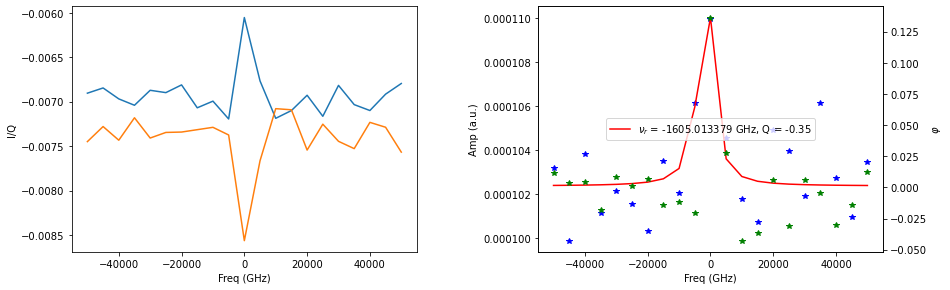

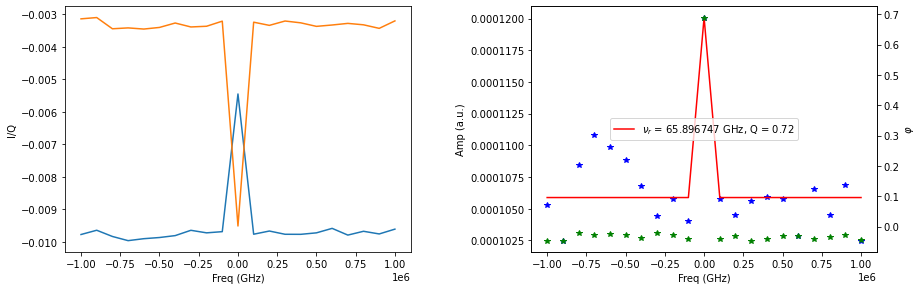

In [489]:
expt_name = 'storage_spec'
filelist = [0, 6]
#3 - amp(0.5)
#4 - 8us long readout

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['freqs'])
        a.close()
        
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.35)
    axs[0].plot(x, I)
    axs[0].plot(x, Q)
    axs[0].set_xlabel('Freq (GHz)')
    axs[0].set_ylabel('I/Q')

    amps = Q**2 + I**2
    ph = np.arctan2(np.array(Q), np.array(I))
    ph = np.unwrap(ph, discont=3.141592653589793, axis=-1)
    m = (ph[-1]-ph[0])/(x[-1] - x[0])
    ph = ph - m*x*0.95
    ph = ph -np.mean(ph)
    axs[1].plot(x, amps, 'b*')
    p = fitlor(x, amps, showfit=False)
    q = p[2]/(2*p[3])
    axs[1].plot(x, lorfunc(p, x), label=r'$\nu_{r}$ = %.6f GHz, Q = %.2f'% (p[2], q), color='r')
    print ("fits = ", p)
    ax2  = axs[1].twinx()
    ax2.plot(x, ph, 'g*')
    axs[1].set_xlabel('Freq (GHz)')
    axs[1].set_ylabel('Amp (a.u.)')
    ax2.set_ylabel('$\\varphi$')
    axs[1].legend(loc='center')

## Number splitting

0.5 1600


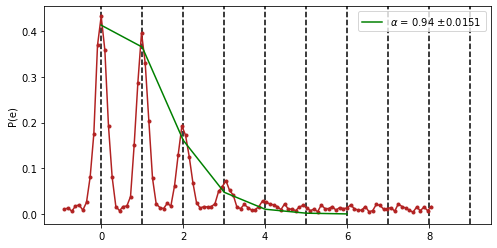

In [618]:
expt_name = 'number_splitting'
filelist = [16]
# , 2, 3, 4, 7, 8, 10, 22
qubit_freq = 4.746910599438208
two_chi = -1.118e6
N = 7

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        I = np.array(a['I'])[:]
        Q = np.array(a['Q'])[:]
        cav_amp = np.array(a['amp'])
        cav_len = np.array(a['time'])
        freqs = (np.array(a['freq'])/1e9)[:]*1e9/two_chi
        a.close()
        print(cav_amp, cav_len)
        x = freqs
        """Scaling the probability values with g and e"""
        y = (Q - contrast[1])/contrast[0]
        
        plt.figure(figsize=(8, 4))

        for j in range(10):
            plt.axvline(x=j, linestyle='--', color='k')
        plt.plot(x, y, '.-', color='firebrick') 
        
        fitparams = np.zeros(3*N+1)
        fitparams[0] = 0

        for kk in range(N):
            fitparams[3*kk+1] = max(y)
            fitparams[3*kk+2] = kk
            fitparams[3*kk+3] = 0.3

        p1, p2 = fitgausssum_with_baseline(x, y, fitparams=fitparams)
                
        peak_val, freq_val = fitamp(p1)

        a, a_err = fitcoherentstate(peak_val)
        alpha_respi.append(a)
        alpha_respi_err.append(a_err)
        plt.plot(coherent_state(np.arange(len(peak_val)), a), 'g', label=r'$\alpha$ = {} $\pm {}$'.format(np.round(a, 3), np.round(a_err, 4)))
        
        plt.ylabel('P(e)')
        plt.legend(loc='best')
        plt.show()


In [620]:
(0.580/0.94)*1600//4

246.0

## SNAP Fock prep

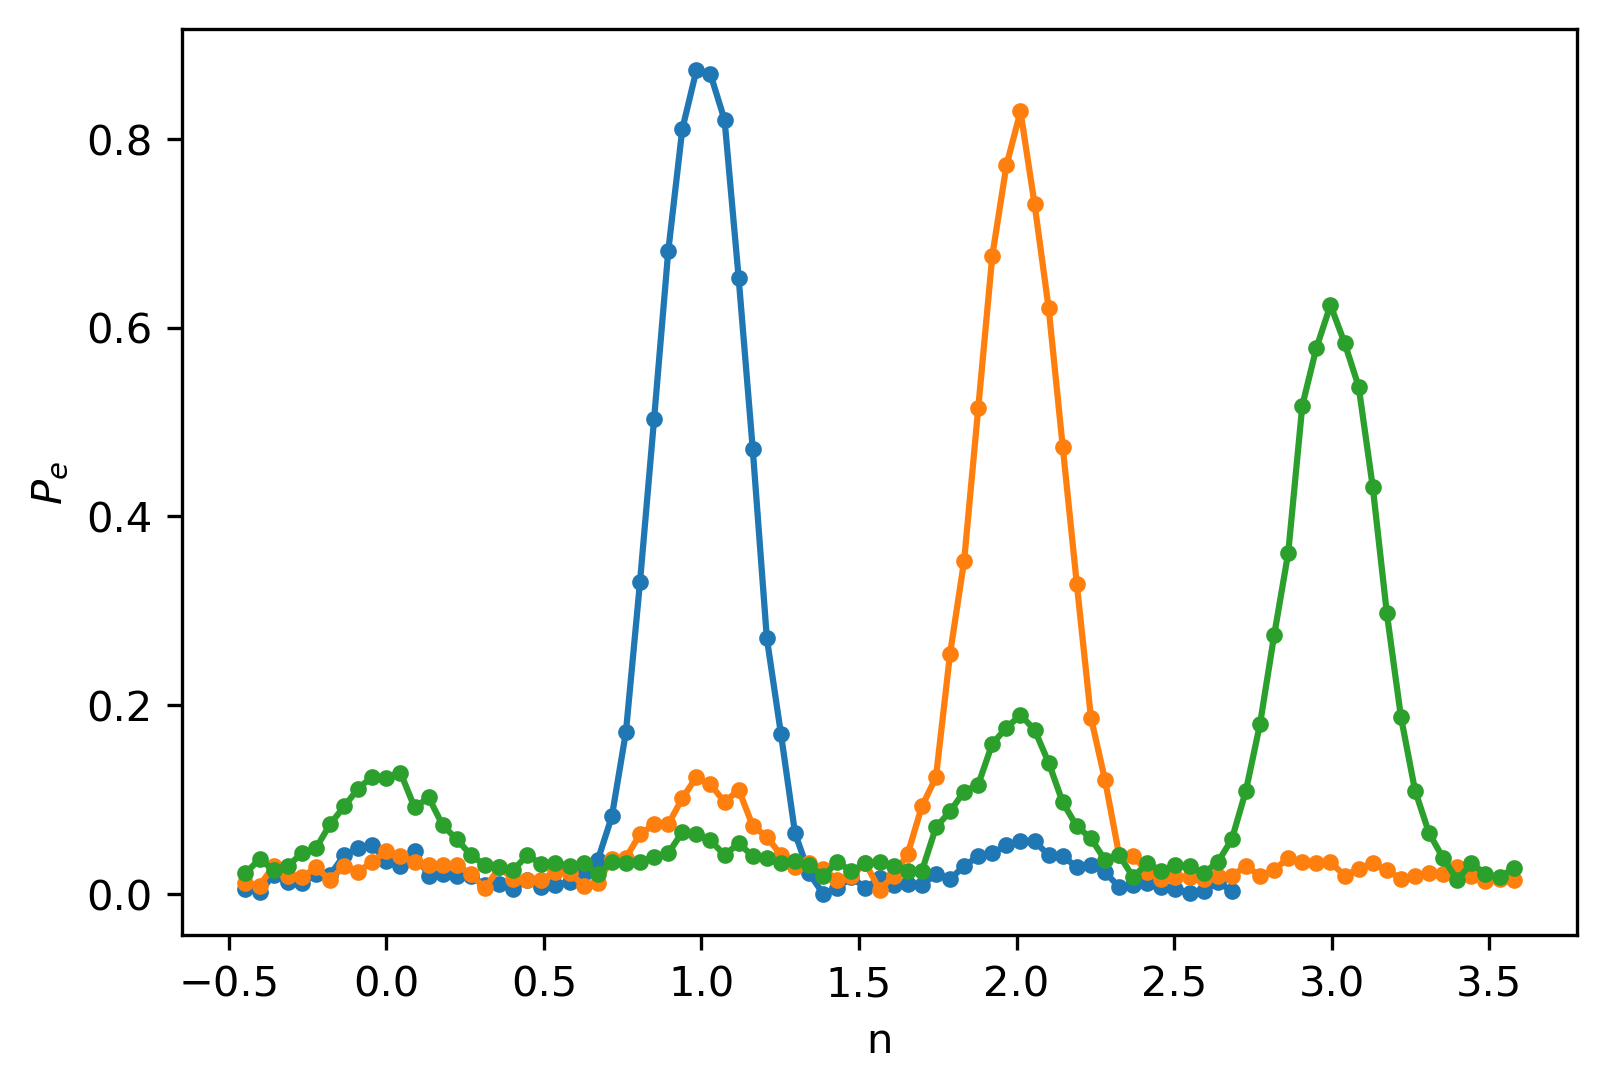

In [778]:
expt_name = 'snap_fock_prep'
filelist = [2, 3, 5]
two_chi = -1.118e6
cal = [0.949, 0.011]
plt.figure(dpi=300)

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        I = np.array(a['I'])[:]
        Q = np.array(a['Q'])[:]
        freqs = (np.array(a['freq'])/1e9)[:]*1e9/two_chi
        a.close()
        
        Q = (Q-cal[1])/cal[0]
        
        plt.plot(freqs, Q, '.-')
plt.xlabel('n')
plt.ylabel(r'$P_{e}$')
plt.show()

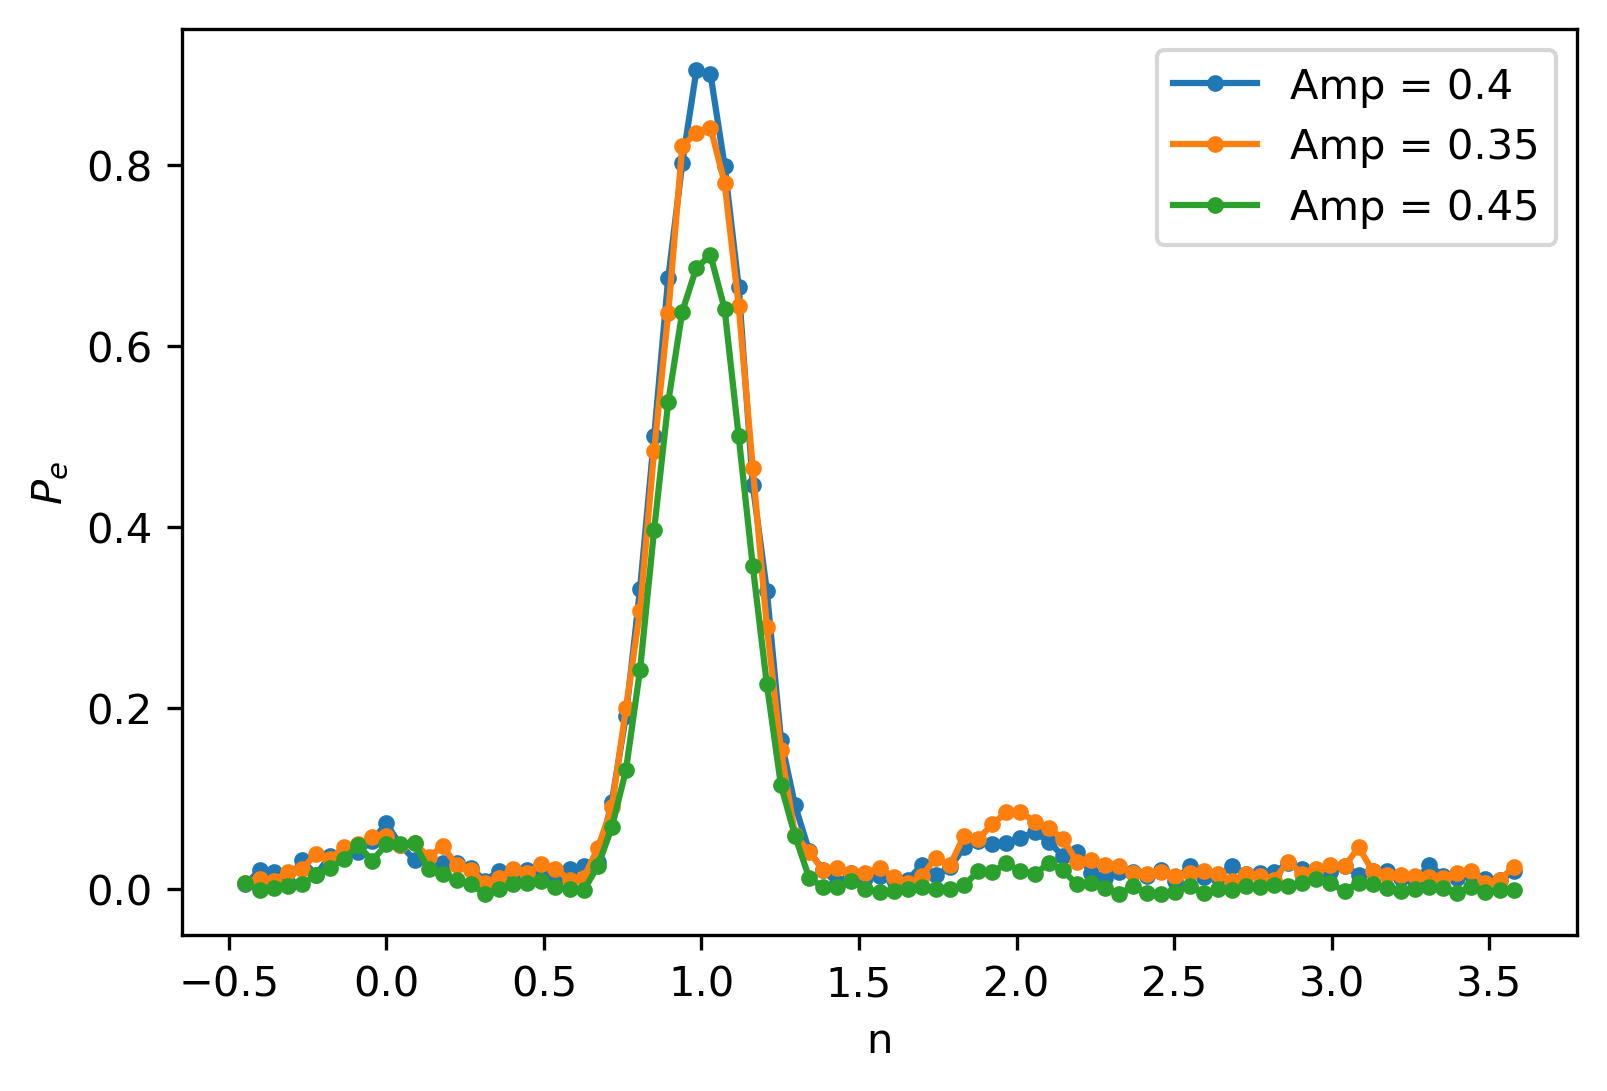

In [779]:
expt_name = 'snap_fock_prep'
filelist = [10, 6, 8]
two_chi = -1.118e6
cal = [0.949, 0.011]
plt.figure(dpi=300)
amp = [0.4, 0.35, 0.45]
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        I = np.array(a['I'])[:]
        Q = np.array(a['Q'])[:]
        freqs = (np.array(a['freq'])/1e9)[:]*1e9/two_chi
        a.close()
        
        Q = (Q-cal[1])/cal[0]
        
        plt.plot(freqs, Q, '.-', label='Amp = {}'.format(amp[ii]))
plt.xlabel('n')
plt.ylabel(r'$P_{e}$')
plt.legend(loc='best')
plt.show()

## 2 bit decomposition

0.5 1200
0.5 1200
0.5 1600
0.5 1800
0.5 2000
0.25 2000
0.25 2000
0.5 1600
0.25 1000.0
0.25 1200.0
0.25 1400.0
0.25 1600.0
0.25 1800.0
0.25 2000.0
0.25 2200.0
0.25 2400.0
0.25 2600.0
0.25 2800.0
0.25 3000.0
0.25 3200.0
0.25 3200.0
0.5 400.0
0.5 600.0
0.5 800.0
0.5 1000.0
0.5 1200.0
0.5 1400.0
0.5 1600.0
0.5 1800.0


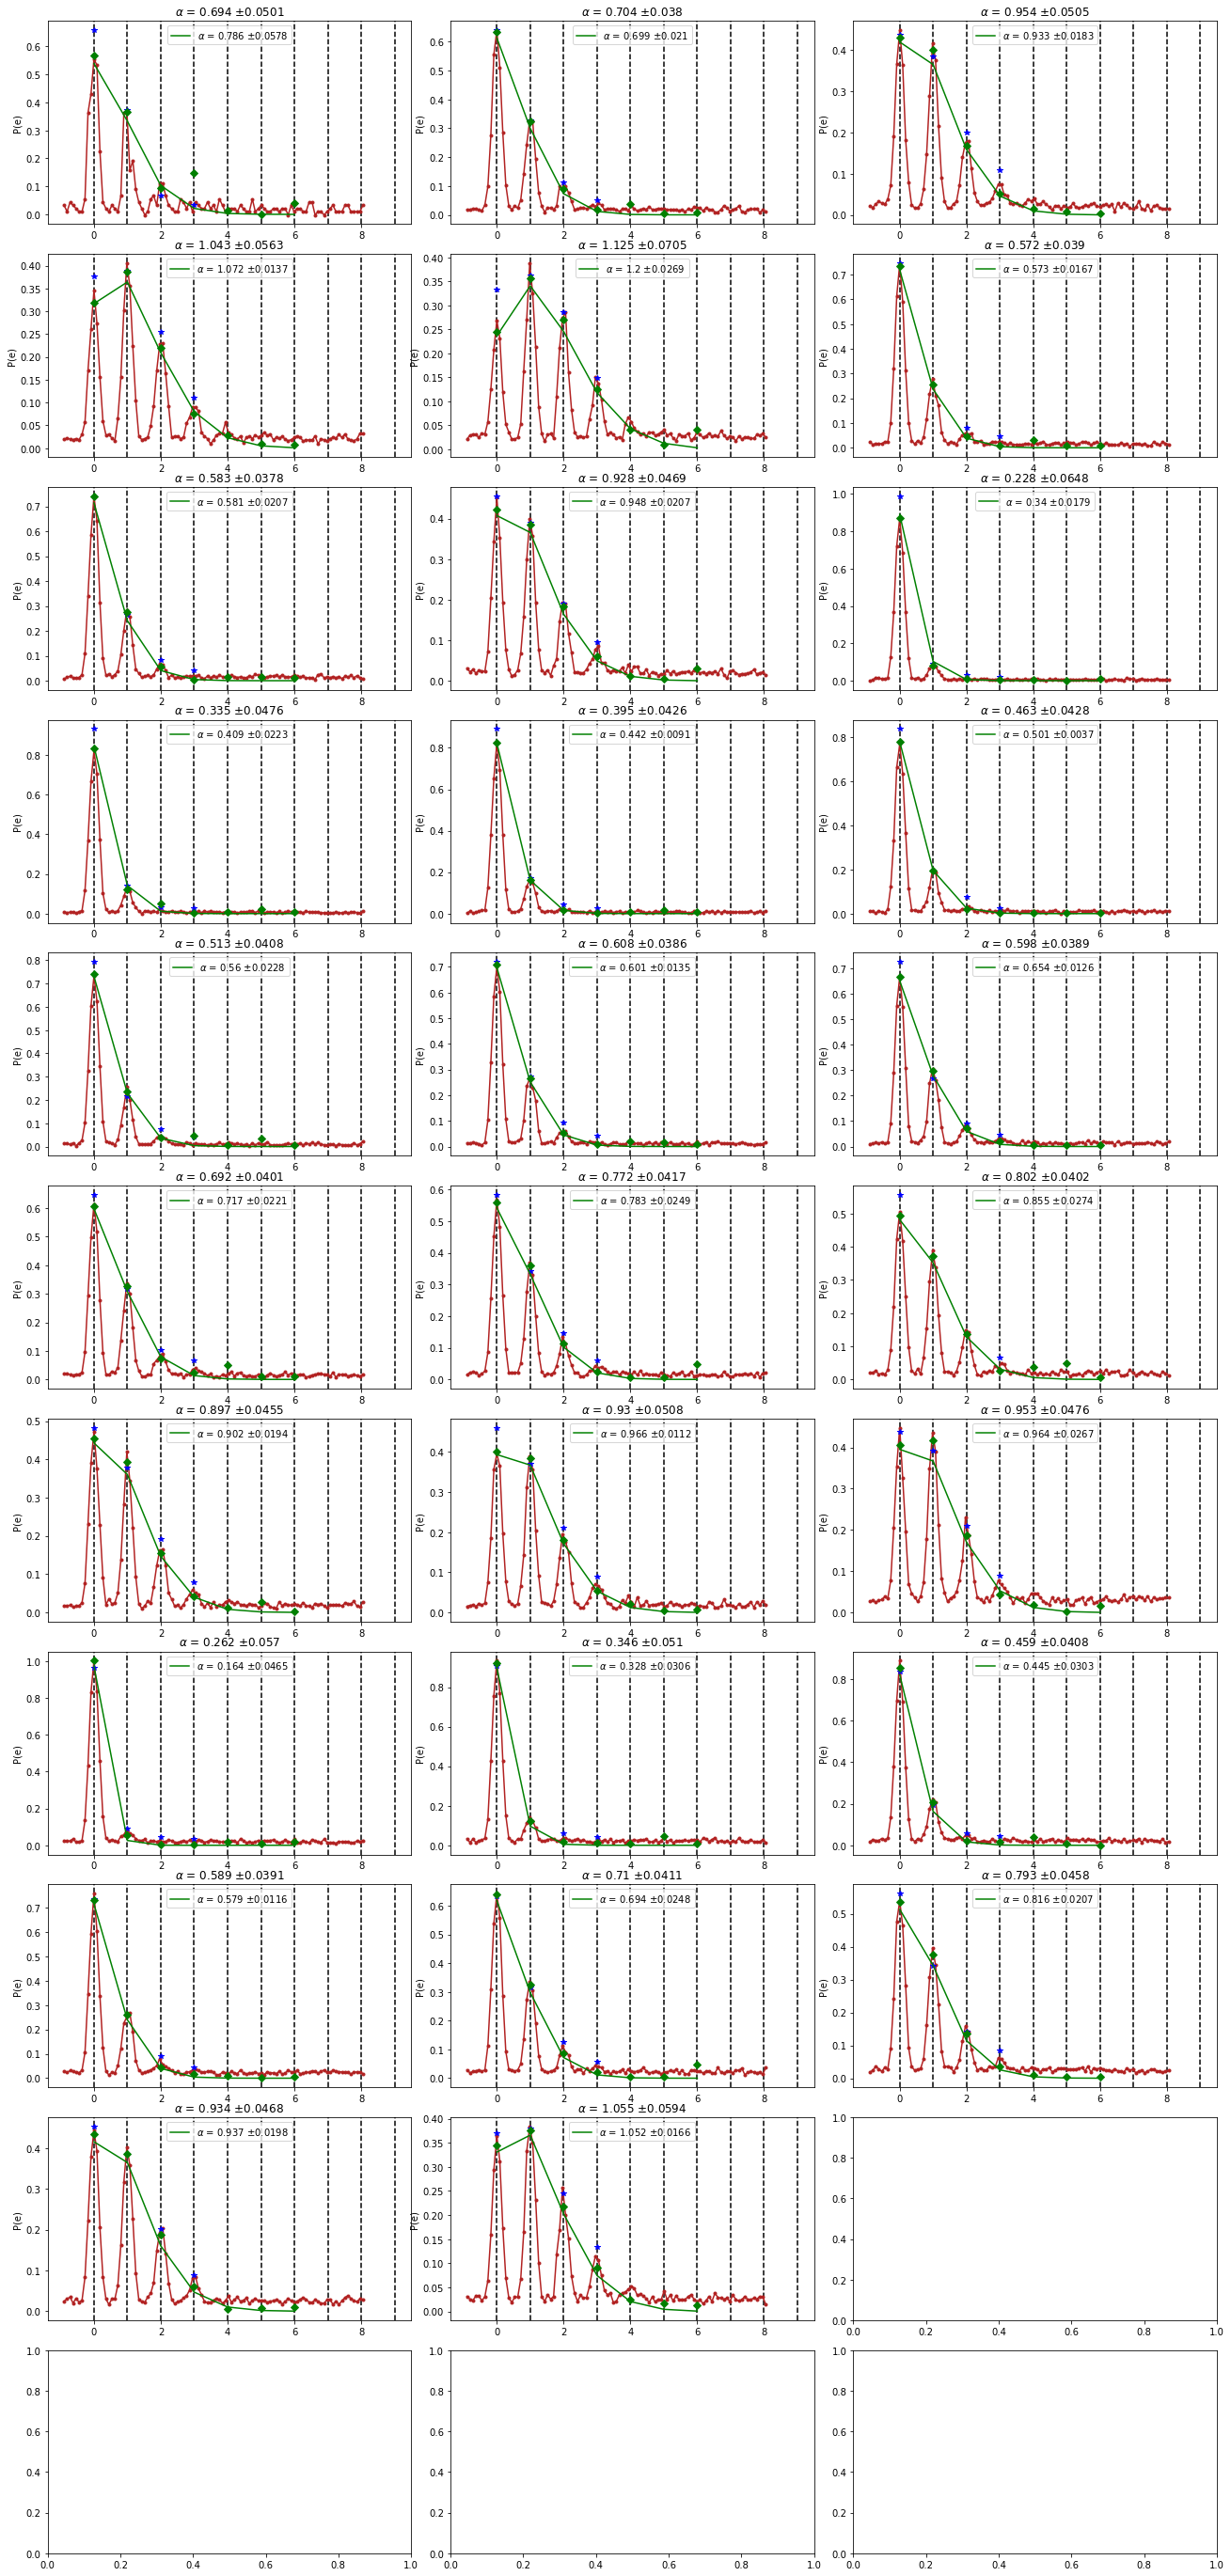

In [626]:
expt_name = 'binary_decomp_test'
filelist = np.arange(32)
# , 2, 3, 4, 7, 8, 10, 22
qubit_freq = 4.746910599438208
two_chi = -1.118e6
N = 7

contrast = [0.8795, 0.0015]

filelist = np.delete(filelist, -9)
filelist = np.delete(filelist, 6)
filelist = np.delete(filelist, 8)

alpha_binary = []
alpha_binary_err = []

alpha_respi = []
alpha_respi_err = []

fig, axs = plt.subplots(nrows=len(filelist)//3+len(filelist)%3, ncols=3, figsize=(18, 4*len(filelist)//3))
fig.tight_layout()

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        I = np.array(a['I'])[:]
        Q = np.array(a['Q'])[:]
        p_cav = np.array(a['p_cav'])/100
        cav_amp = np.array(a['amp'])
        cav_len = np.array(a['time'])
        freqs = (np.array(a['freq'])/1e9)[:]*1e9/two_chi
        a.close()
        print(cav_amp, cav_len)
        x = freqs
        """Scaling the probability values with g and e"""
        y = (Q - contrast[1])/contrast[0]
        p_cav = (p_cav-contrast[1])/contrast[0]

        ax = axs[ii//3, ii%3]

        for j in range(10):
            ax.axvline(x=j, linestyle='--', color='k')
        ax.plot(x, y, '.-', color='firebrick') 
        ax.plot(p_cav, 'b*')
        
        fitparams = np.zeros(3*N+1)
        fitparams[0] = 0

        for kk in range(N):
            fitparams[3*kk+1] = max(y)
            fitparams[3*kk+2] = kk
            fitparams[3*kk+3] = 0.3

        p1, p2 = fitgausssum_with_baseline(x, y, fitparams=fitparams)
                
        peak_val, freq_val = fitamp(p1)

        a, a_err = fitcoherentstate(peak_val)
        alpha_respi.append(a)
        alpha_respi_err.append(a_err)
        ax.plot(coherent_state(np.arange(len(peak_val)), a), 'g', label=r'$\alpha$ = {} $\pm {}$'.format(np.round(a, 3), np.round(a_err, 4)))
        ax.plot(peak_val,'gD')        
        a, a_err = fitcoherentstate(p_cav)
        alpha_binary.append(a)
        alpha_binary_err.append(a_err)
        ax.set_title(r'$\alpha$ = {} $\pm {}$'.format(np.round(a, 3), np.round(a_err, 4)))
        
        ax.set_ylabel('P(e)')
        ax.legend(loc='best')
plt.show()


In [616]:
(1.143/0.928)*1600//4

492.0

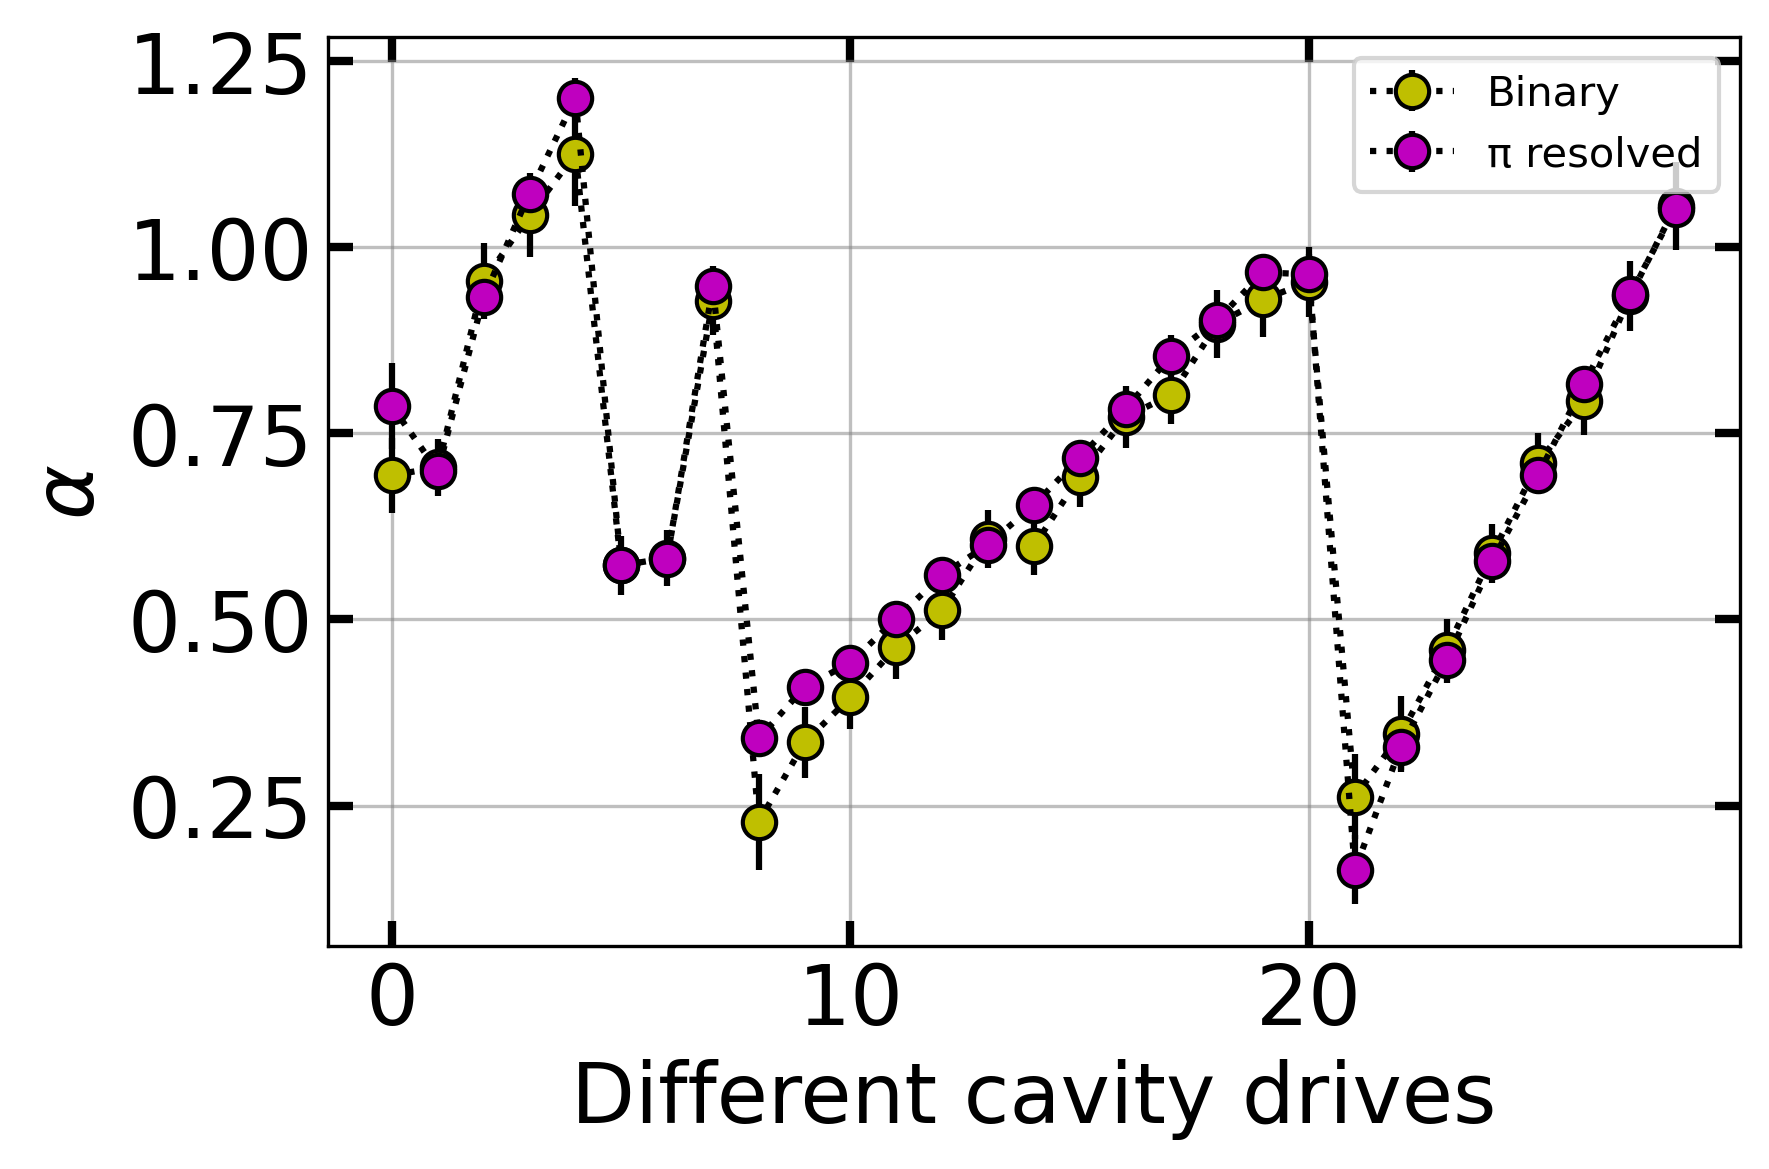

In [633]:
plt.figure(dpi=300)

y = np.array(alpha_binary)
y_err = np.array(alpha_binary_err)

plt.errorbar(x= np.arange(len(filelist)), y=y, yerr=y_err,  marker='o', markersize=8, 
             linestyle='dotted', color='k', markerfacecolor='y', label='Binary')

y = np.array(alpha_respi)
y_err = np.array(alpha_respi_err)
plt.errorbar(x= np.arange(len(filelist)), y=y, yerr=y_err,  marker='o', markersize=8, 
             linestyle='dotted', color='k', markerfacecolor='m', label='π resolved')

plt.ylabel(r'$\alpha$', fontsize=20)
plt.xlabel('Different cavity drives', fontsize=20)
plt.grid(minorticks_on)
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='grey', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.legend(loc='best')
# plt.title('Difference in α computed from binary decomposition and resolved qubit spectroscopy')
plt.show()

In [449]:
y, y_err

(array([-0.09264608,  0.00483797,  0.02184596, -0.0292976 , -0.07500454,
        -0.0009337 , -0.70083092,  0.00154928, -0.0192767 , -0.20717549,
        -0.11198367, -0.07428764, -0.04637273, -0.03828672, -0.04722276,
         0.00778305, -0.05542714, -0.02548619, -0.01148533, -0.0524617 ,
        -0.00536802, -0.03627055, -0.01023933,  0.02940363,  0.09784344,
         0.01767296,  0.01400274,  0.00974004,  0.01542319, -0.02323326,
        -0.00269076,  0.00354649]),
 array([7.65262841e-02, 4.34177981e-02, 5.36977114e-02, 5.79274161e-02,
        7.54826792e-02, 4.24434124e-02, 1.77863550e-01, 4.31184350e-02,
        5.12269990e-02, 1.12770129e-01, 6.72555923e-02, 5.25637495e-02,
        4.35808797e-02, 4.29345454e-02, 4.67341136e-02, 4.09062922e-02,
        4.08816442e-02, 4.58210884e-02, 4.85368744e-02, 4.86215585e-02,
        4.94436736e-02, 5.20126434e-02, 5.45309551e-02, 2.61164564e+03,
        7.36064797e-02, 5.94449230e-02, 5.08456721e-02, 4.07539386e-02,
        4.80190229e-02

## 3 bit decomposition

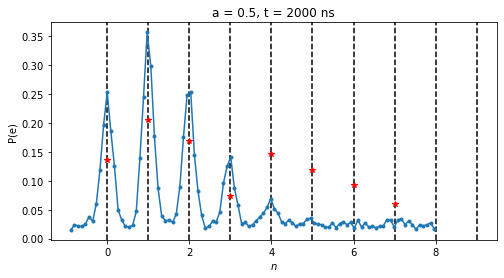

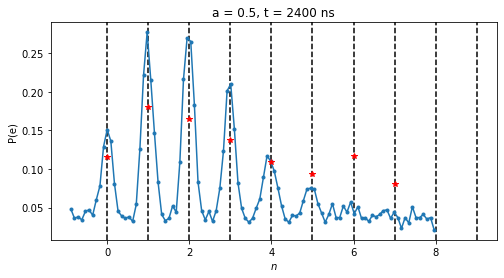

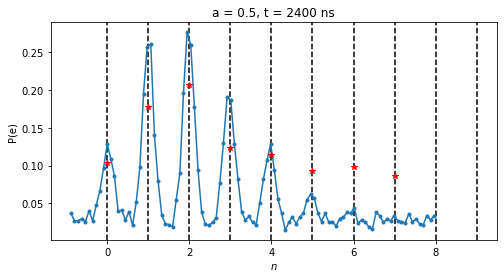

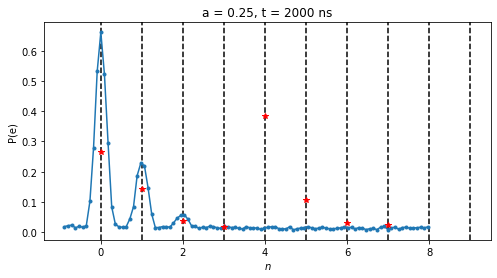

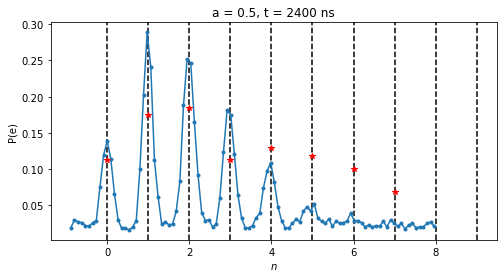

In [309]:
expt_name = 'binary_decomp_3bits_test'
filelist = [0, 1, 2, 3, 4]
qubit_freq = 4.746910599438208
two_chi = -1.13e6
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        I = np.array(a['I'])[:]
        Q = np.array(a['Q'])[:]
        p_cav = np.array(a['p_cav'])/100
        freqs = (np.array(a['freq'])/1e9)[:]*1e9/two_chi
        cav_amp = np.array(a['amp'])
        cav_len = np.array(a['time'])

        a.close()
        
#         x = np.arange(0, n_max, len(Q))
        x = freqs
        y = Q
        plt.figure(figsize=(8, 4))
        for j in range(10):
            plt.axvline(x=j, linestyle='--', color='k')
        plt.plot(x, y, '.-')
        plt.title('a = {}, t = {} ns'.format(cav_amp, cav_len))

#         popt, pcov = curve_fit(coherent_state, x, y)
#         plt.title(r'$\alpha = %.3f$'%popt[1])
#         print(popt)
        plt.ylabel('P(e)')
        plt.xlabel(r'$n$')
        plt.plot(p_cav, 'r*')
#         plt.plot(x, coherent_state(x, *popt), 'r')
        plt.show()


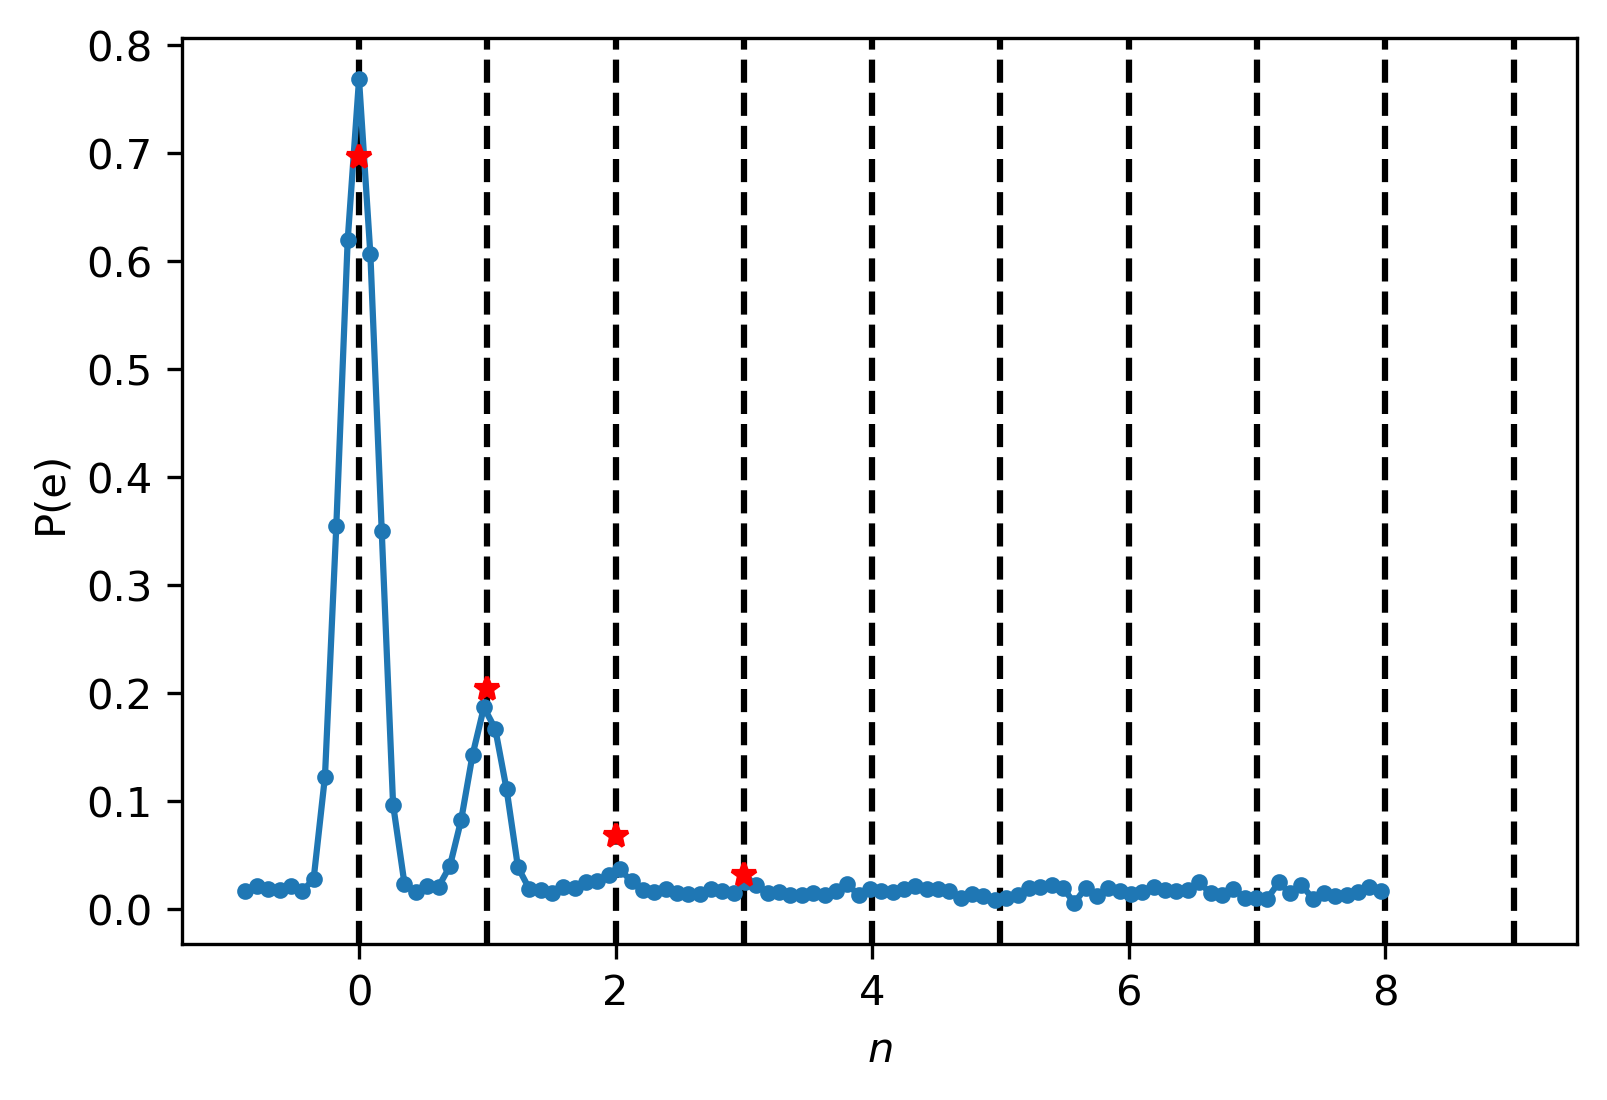

In [252]:
expt_name = 'number_splitting'
filelist = [33] #10 - binary_decomp
qubit_freq = 4.746910599438208
two_chi = -1.13e6
for ii, i in enumerate(filelist):
    filename = "S:\\_Data\\210326 - QM_OPX\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        I = np.array(a['I'])[:]
        Q = np.array(a['Q'])[:]
        freqs = (np.array(a['freq'])/1e9)[:]*1e9/two_chi

        a.close()
        
#         x = np.arange(0, n_max, len(Q))
        x = freqs
        y = Q
        plt.figure(dpi=300)
        for j in range(10):
            plt.axvline(x=j, linestyle='--', color='k')
        plt.plot(x, y, '.-')
#         popt, pcov = curve_fit(coherent_state, x, y)
#         plt.title(r'$\alpha = %.3f$'%popt[1])
#         print(popt)
        plt.ylabel('P(e)')
        plt.xlabel(r'$n$')
        p_cav = np.array([69.6, 20.4, 6.8, 3.2])/100
        plt.plot(p_cav, 'r*')
#         plt.plot(x, coherent_state(x, *popt), 'r')
        plt.show()


1.0278210385869673


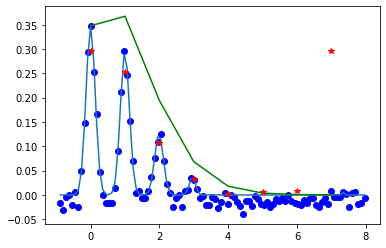

In [98]:
y = Q
y = (y-0.10)/0.95

N = 8
fitparams = np.zeros(3*N+1)
fitparams[0] = 0

fig, ax = plt.subplots()
ax.plot(x, y, 'bo')

for kk in range(N):
    fitparams[3*kk+1] = max(y)
    fitparams[3*kk+2] = kk
    fitparams[3*kk+3] = 0.5

p1, p2 = fitgausssum_with_baseline(x, y, fitparams=fitparams)

ax.plot(x, gaussfuncsum_with_baseline(x, *p1))

peak_val, freq_val = fitamp(p1)

peak_val = peak_val/np.sum(peak_val)

a, a_err = fitcoherentstate(peak_val)
ax.plot(coherent_state(np.arange(len(peak_val)), a), 'g')
print(a)
ax.plot(peak_val,'r*')
plt.show()

## 2 bit decomposition followed by repeated π at n

In [677]:
expt_name = 'binary_decomp_repeated_pi'
filelist = [20]
qubit_freq = 4.746910599438208
two_chi = -1.13e6
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        bit1 = np.array(a['bit1'])[:]
        bit2 = np.array(a['bit2'])[:]
        bit3 = pd.DataFrame(a['bit3'])[:]
        
        p_cav = np.array(a['p_cav'])/100
        cav_amp = np.array(a['amp'])
        cav_len = np.array(a['time'])

        a.close()

print(np.shape(p_cav))
df = bit3
print(np.shape(df))

nx, ny = np.shape(df)

pd.set_option('display.max_rows', None)
l = []
for i in range(ny):
    l.append('π%i'%i)
df.columns = l

df['n'] = bit1+2*bit2

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols].sort_values(by=['n'])
# print(df)

(4,)
(10000, 6)


In [681]:
df

n  π0  π1  π2  π3  π4  π5
0     0   0   0   0   0   0   0
5268  0   0   0   0   0   0   0
5265  0   0   0   0   0   0   0
5259  0   0   0   0   0   0   0
5255  0   0   0   0   0   0   0
5254  0   0   0   0   0   1   0
5247  0   0   0   0   0   0   0
5245  0   0   0   0   0   0   0
5240  0   0   0   0   0   0   0
5269  0   0   0   0   0   0   0
5236  0   0   0   0   0   0   0
5230  0   0   0   0   0   0   0
5226  0   0   0   0   0   0   0
5225  0   0   0   0   0   0   0
5224  0   0   0   0   0   0   0
5221  0   0   0   0   0   0   0
5220  0   0   0   0   0   0   0
5218  0   0   0   0   0   0   0
5215  0   0   0   0   0   0   0
5233  0   0   0   0   0   0   0
5213  0   0   0   0   0   0   0
5270  0   1   0   1   0   1   0
5276  0   0   0   0   0   0   0
5318  0   0   0   0   0   0   0
5316  0   1   0   1   0   1   0
5315  0   0   0   0   0   0   0
5314  0   0   0   0   0   0   0
5311  0   0   0   0   0   0   0
5308  0   0   0   0   0   0   0
5307  0   0   0   0   0   0   0
5304  0   0   0   0   0   0   0
5273  0   0   0   0   0   0   0
5302  0   0   0   0   0   0   0
5298  0   0   0   0   0   0   0
5296  0   0   0   0   0   0   0
5293  0   0   0   0   0   0   0
5292  0   0   0   0   0   0   0
5291  0   0   0   0   0   0   0
5290  0   0   0   0   0   0   0
5283  0   1   1   1   1   1   1
5277  0   0   0   0   0   0   0
5299  0   0   0   0   0   0   0
5208  0   0   0   0   0   0   0
5207  0   0   0   0   0   0   0
5205  0   0   0   0   0   0   0
5153  0   0   0   0   0   0   0
5151  0   0   0   0   0   0   0
5150  0   0   0   0   0   0   0
5149  0   0   0   0   0   0   0
5147  0   0   0   0   0   0   0
5144  0   0   0   0   0   0   0
5142  0   0   0   0   0   0   0
5141  0   0   0   0   0   0   1
5155  0   0   0   0   0   0   0
5138  0   0   0   0   0   0   0
5134  0   0   0   1   0   0   0
5133  0   0   0   0   0   0   0
5130  0   0   0   0   0   0   0
5117  0   0   0   0   0   0   0
5112  0   0   0   0   0   0   0
5110  0   0   0   0   0   0   0
5109  0   0   0   0   0   0   0
5106  0   0   0   0   0   0   0
5137  0   0   0   0   0   0   0
5161  0   0   0   0   0   0   0
5167  0   0   0   0   0   0   0
5168  0   0   0   0   0   0   0
5201  0   1   0   1   0   1   0
5200  0   0   0   0   0   0   0
5199  0   0   0   0   0   0   0
5198  0   0   0   0   0   0   0
5193  0   0   0   0   0   1   0
5192  0   0   0   0   0   0   0
5191  0   0   0   0   0   0   0
5190  0   0   0   0   0   0   0
5189  0   0   0   0   0   0   0
5187  0   0   0   0   0   0   0
5184  0   0   0   0   0   0   0
5181  0   0   0   0   0   0   0
5180  0   0   0   0   0   0   0
5178  0   0   0   0   0   0   0
5177  0   0   0   0   0   0   0
5176  0   0   0   0   0   0   0
5175  0   0   0   0   0   0   0
5172  0   0   0   0   0   0   0
5169  0   0   0   0   0   0   0
5320  0   0   0   0   0   0   0
5322  0   0   0   0   0   0   0
5325  0   0   0   0   0   0   0
5328  0   1   0   0   0   0   0
5482  0   1   0   1   0   1   0
5481  0   0   0   0   0   0   0
5479  0   0   0   0   0   0   0
5478  0   0   0   0   0   0   0
5476  0   0   0   0   0   0   0
5473  0   0   0   0   1   0   0
5470  0   0   0   0   0   0   0
5469  0   1   0   0   0   0   0
5490  0   0   0   0   0   0   0
5463  0   0   0   0   0   0   0
5459  0   0   0   0   0   0   0
5454  0   0   0   0   0   0   0
5452  0   0   0   0   0   0   0
5449  0   0   0   0   0   0   0
5447  0   0   0   0   0   0   0
5444  0   0   0   0   0   0   0
5443  0   0   0   0   0   0   0
5442  0   0   0   0   0   0   0
5462  0   0   0   0   0   0   0
5493  0   0   0   0   0   0   0
5495  0   0   0   0   0   0   0
5498  0   0   0   0   0   0   0
5543  0   0   0   0   0   0   0
5541  0   0   0   0   0   0   0
5540  0   0   0   0   0   0   0
5535  0   0   0   0   0   0   0
5534  0   0   0   0   0   0   0
5531  0   0   0   0   0   0   0
5530  0   0   0   0   0   0   0
5527  0   1   1   1   1   1   1
5526  0   0   0   0   0   0   0
5522  0   0   0   0   0   0   0
5521  0   0   0   0   0   0   0
5520  0   0   0   0   0   0   0
5519  

In [678]:
(unique, counts) = np.unique(df['n'], return_counts=True)


print(unique, counts)

[0 1 2 3] [4000 3332 1843  825]


In [679]:
df.iloc[1]

n     0
π0    0
π1    0
π2    0
π3    0
π4    0
π5    0
Name: 5268, dtype: int64

In [682]:
class hmm_analysis:

    def __init__(self, qubit_params = None, cavity_params = None, readout_params = None):
        
        self.qubit_params = qubit_params
        self.cavity_params = cavity_params
        self.readout_params = readout_params

        """All the timescales are in μs"""
        self.qubit_t1 = qubit_params['t1']
        self.qubit_t2 = qubit_params['t2']
        self.qubit_nth = qubit_params['nth']
        
        self.cavity_t1 = cavity_params['t1']
        self.cavity_nth = cavity_params['nth']
        
        self.readout_len = readout_params['length']        
        self.trigger_period = readout_params['trigger']
        self.pi_length = readout_params['pi_pulse']

    ##----------------------------------------------------------------##
    def forward(self, meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha

    def backward(self, meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta

    def likelihood(self, meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  self.forward(meas_seq, T, E)[-1].sum()

    def gamma(self, meas_seq, T, E):
        alpha = self.forward(meas_seq, T, E)
        beta  = self.backward(meas_seq, T, E)
        obs_prob = self.likelihood(meas_seq, T, E)
        return (multiply(alpha, beta.T) / obs_prob)

    def viterbi(self, meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    ##----------------------------------------------------------------##
    def openfile(self, filename):
        
        return File(filename,'r')

    def stateprep(self, data_filename):
        
        """Readout fidelities from an independent measurement"""
        g_infidelity, e_infidelity = 0.0198, 0.0694
        
        self.a = self.openfile(data_filename)

        bit1 = np.array(self.a['bit1'])[:]
        bit2 = np.array(self.a['bit2'])[:]
        bit3 = pd.DataFrame(self.a['bit3'])[:]
        
        p_cav = np.array(self.a['p_cav'])/100
        cav_amp = np.array(self.a['amp'])
        cav_len = np.array(self.a['time'])
        
        self.a.close()
        
        df = bit3
        
        nx, ny = np.shape(df)
        
        npi_at_n = ny
        npi_at_m = 0
        
        """Renaming the columns of repeated pi pulses"""
        l = []
        for i in range(ny):
            l.append('π%i'%i)
        df.columns = l

        df.columns = l

        df['n'] = bit1+2*bit2

        cols = df.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        df = df[cols].sort_values(by=['n'])

        """Find out the unique Fock levels and their occureneces"""

        (unique, counts) = np.unique(df['n'], return_counts=True)

        p_counts = []
        
        g_infidelity, e_infidelity = 0.0194, 0.06647
        index = 0
        for ii in range(len(unique)):
            p_temp = []
            fstate_in = unique[ii]

            if fstate_in == 0:
                cavity_t1 = self.cavity_t1/1
                Pnm =  self.cavity_nth * (1-np.exp(-self.trigger_period/cavity_t1))
            else:
                cavity_t1 = self.cavity_t1/fstate_in
                Pnm =  (1-np.exp(-self.trigger_period/cavity_t1)) + self.cavity_nth * (1-np.exp(-self.trigger_period/cavity_t1))

            Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
            Pge = self.qubit_nth * (1-np.exp(-self.trigger_period/self.qubit_t1)) +\
                (1-np.exp(-self.pi_length/self.qubit_t2))
            Peg = (1-np.exp(-self.trigger_period/self.qubit_t1)) + \
                (1-np.exp(-self.pi_length/self.qubit_t2))

            T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
                 [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
                 [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
                 [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

            E = 0.5*asarray([[1-g_infidelity, g_infidelity],
                [e_infidelity, 1- e_infidelity],
                [1-g_infidelity, g_infidelity],
                [e_infidelity, 1- e_infidelity]])
            
            for jj in range(counts[ii]):
                meas_seq = df.iloc[index + jj][1:]
                P0_first = []
                P1_first = []
                gamma_matrix = self.gamma(meas_seq, T, E)
                P0_first.append(gamma_matrix[-1,0] + gamma_matrix[-1,1])
                P1_first.append(gamma_matrix[-1,2] + gamma_matrix[-1,3])    
                p_temp.append(P1_first[-1]/P0_first[-1])
            
            index = index + counts[ii]
            p_counts.append(p_temp)
        print(unique, counts)
        return unique, counts, p_counts

In [686]:
qubit_params = {'t1':100, 't2':130, 'nth':5e-2}
cavity_params = {'t1':5e2, 'nth':0.001}
readout_params = {'length':3.2, 'trigger':7.2, 'pi_pulse':3}
expt_name = 'binary_decomp_repeated_pi'
filelist = [20]

p_counts = []

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    obj = hmm_analysis(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
    unique, counts, p_counts = obj.stateprep(data_filename=filename)

[0 1 2 3] [4000 3332 1843  825]


In [687]:
df = pd.DataFrame(p_counts)
len(df.iloc[0])

4000

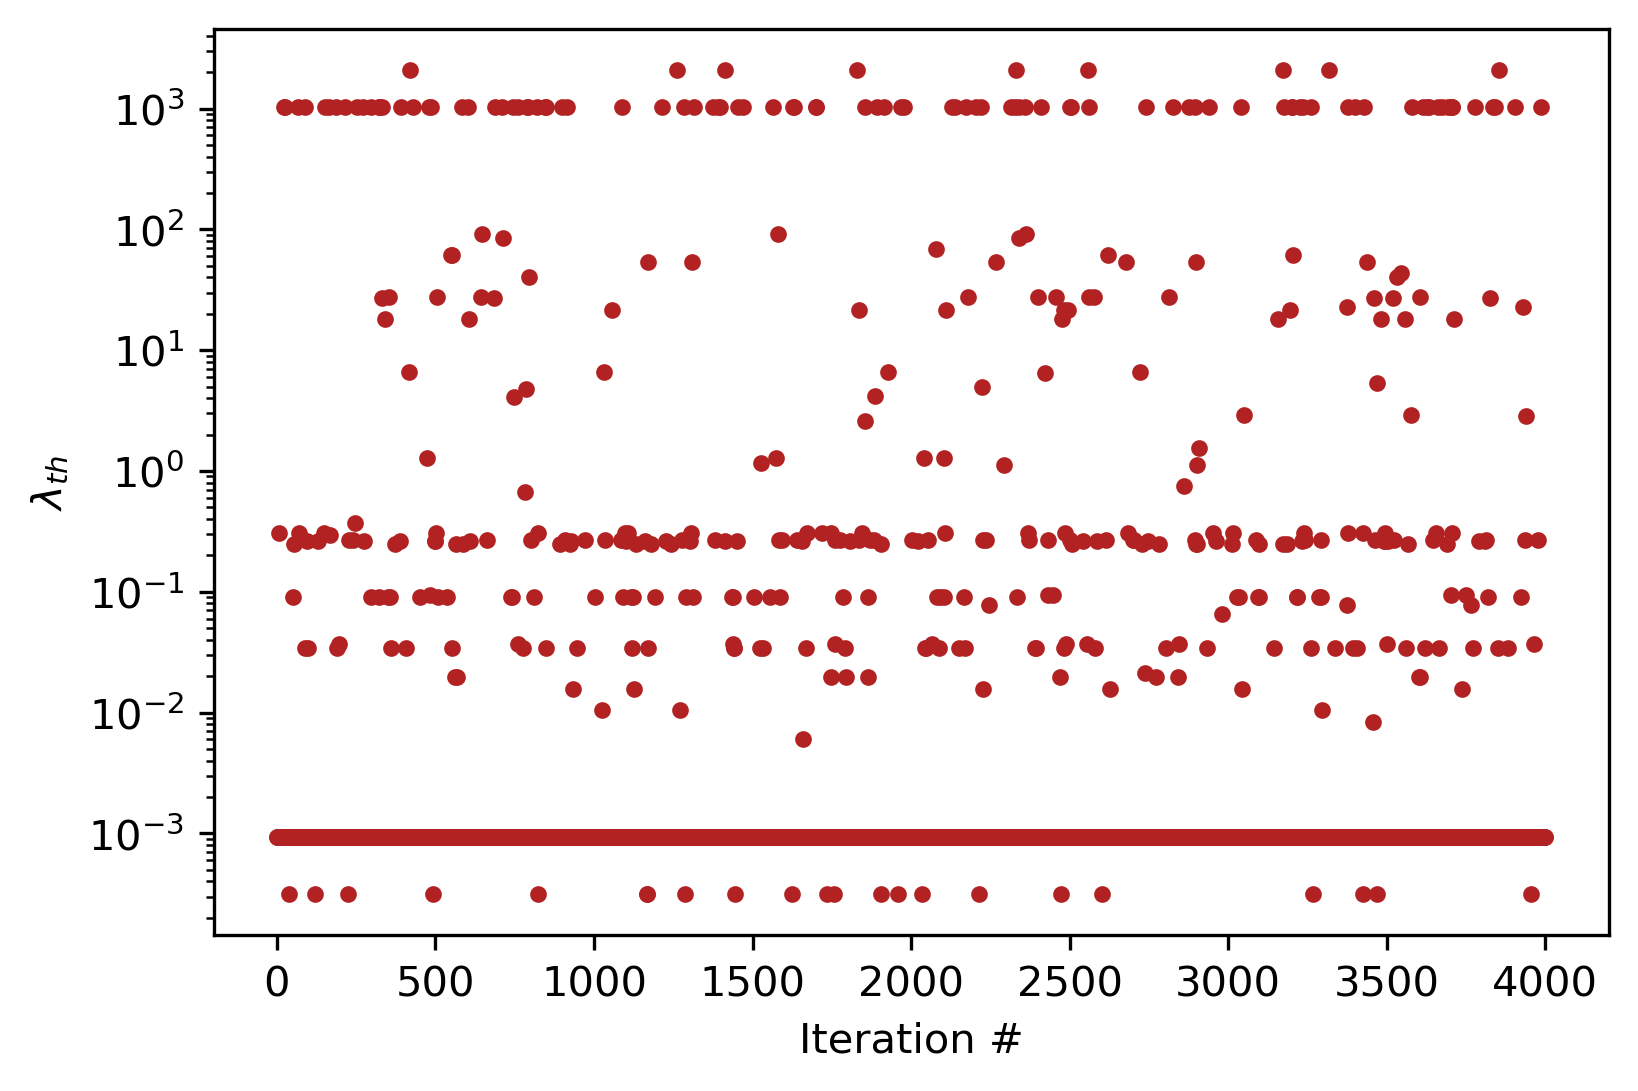

0.89825


In [689]:
plt.figure(dpi=300)
plt.plot(p_counts[0], '.', color='firebrick')
plt.ylabel(r'$\lambda_{th}$')
plt.xlabel('Iteration #')
plt.yscale('log')
plt.show()

x = []
for ii, p in enumerate(p_counts[0]):
    if p < 1e-3:
#         print(ii)
        x.append(ii)
    
print(len(x)/len(p_counts[0]))

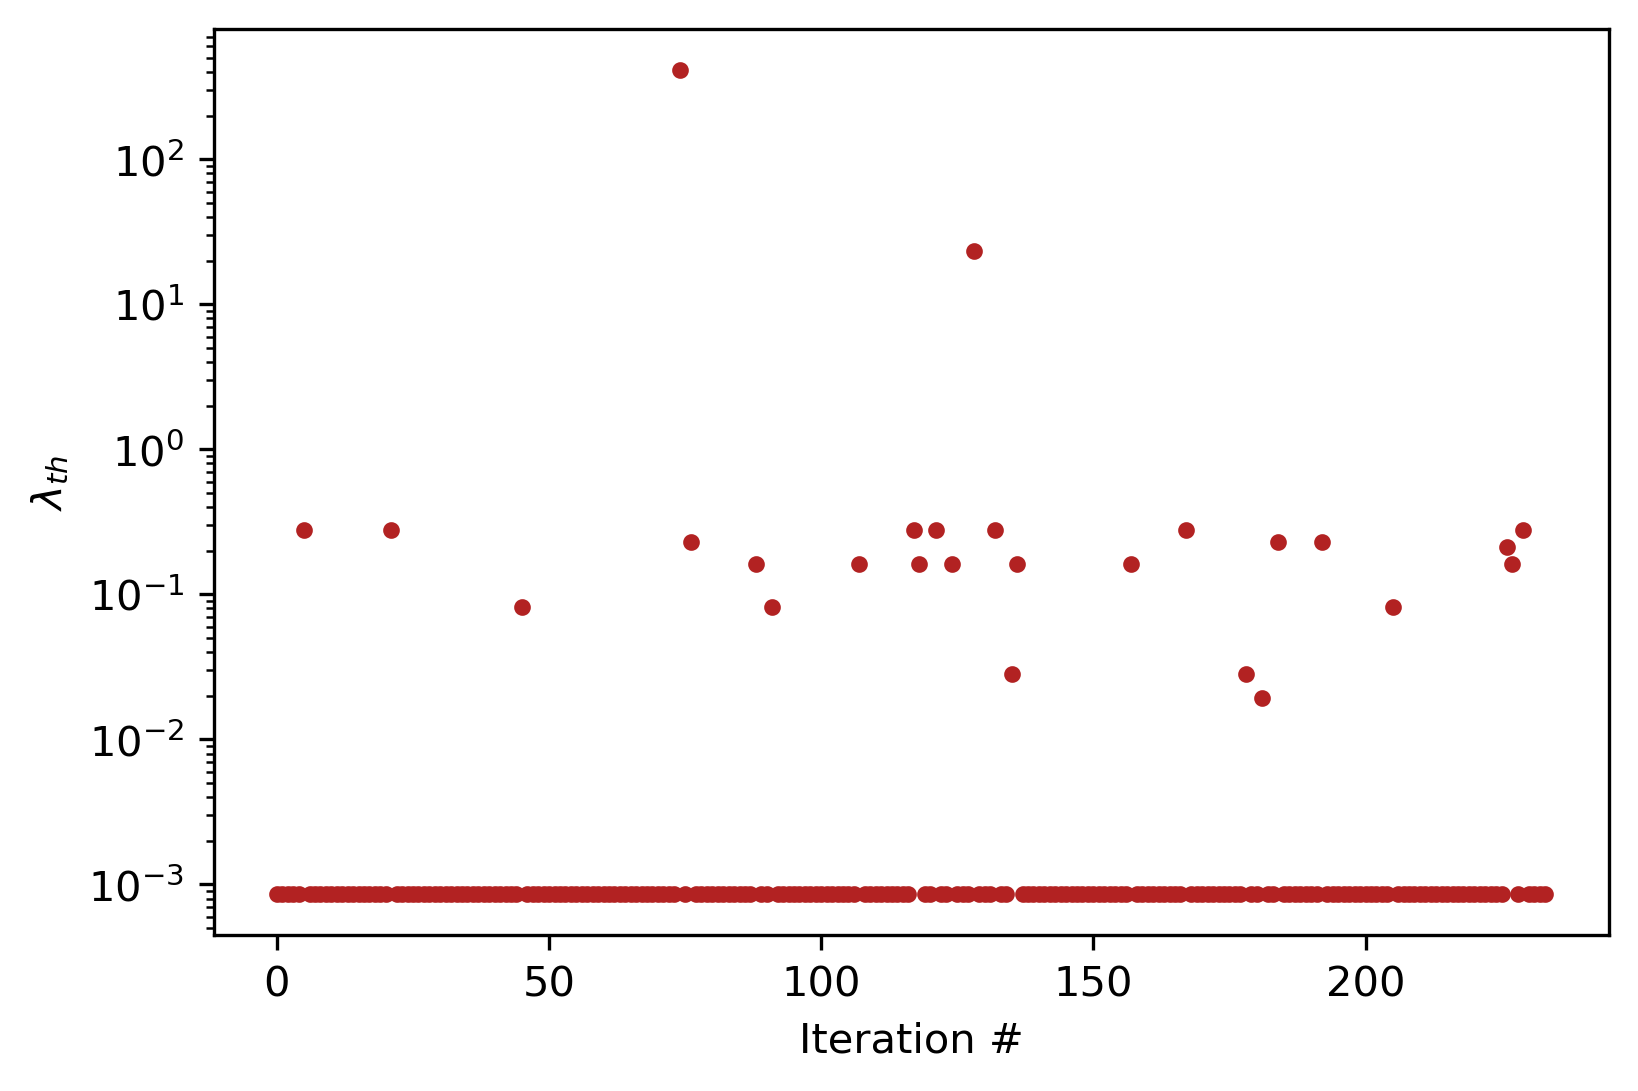

0.004273504273504274


In [670]:
plt.figure(dpi=300)
plt.plot(p_counts[1], '.', color='firebrick')
plt.ylabel(r'$\lambda_{th}$')
plt.xlabel('Iteration #')
plt.yscale('log')
plt.show()

x = []
for ii, p in enumerate(p_counts[1]):
    if p > 1e2:
#         print(ii)
        x.append(ii)
    
print(len(x)/len(p_counts[1]))

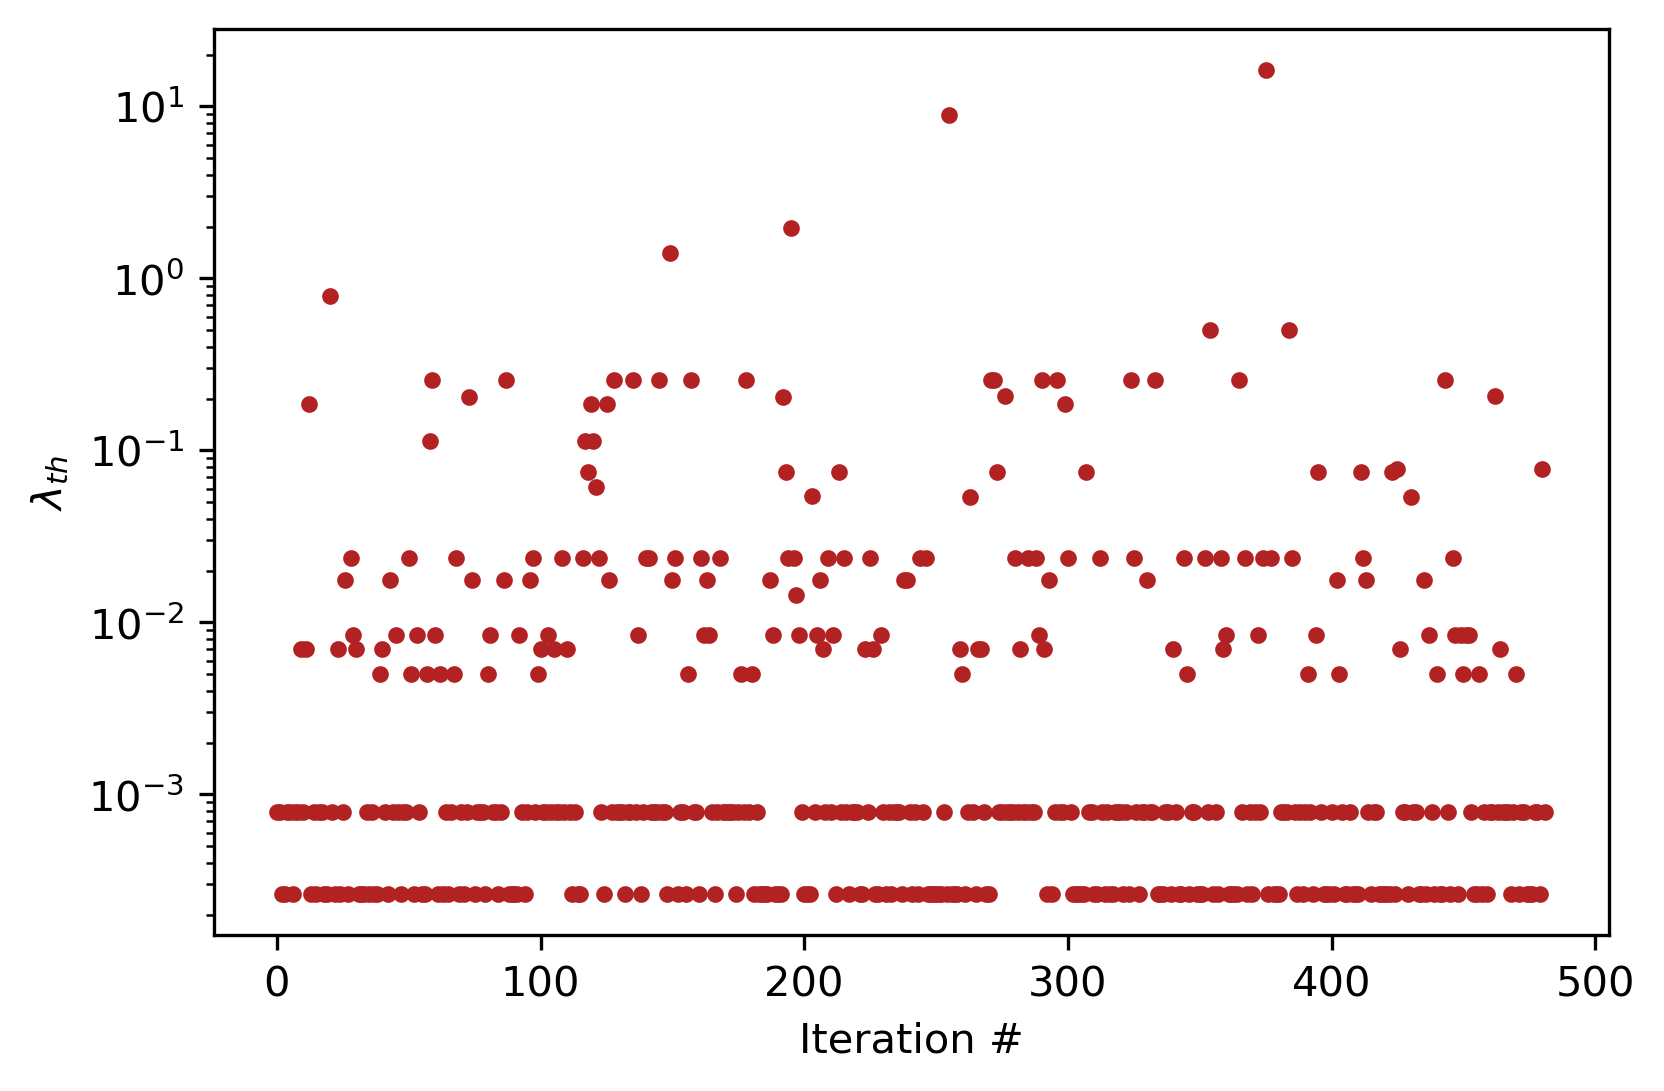

0.0


In [672]:
plt.figure(dpi=300)
plt.plot(p_counts[2], '.', color='firebrick')
plt.ylabel(r'$\lambda_{th}$')
plt.xlabel('Iteration #')
plt.yscale('log')
plt.show()

x = []
for ii, p in enumerate(p_counts[2]):
    if p > 1e2:
#         print(ii)
        x.append(ii)
    
print(len(x)/len(p_counts[2]))

## Stime Em experiment test

In [699]:
expt_name = 'stim_em_bd_rp'
filelist = [0]
qubit_freq = 4.746910599438208
two_chi = -1.13e6
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        bit1 = np.array(a['bit1'])[:]
        bit2 = np.array(a['bit2'])[:]
        bit3 = pd.DataFrame(a['bit3'])[:]
        
        p_cav = np.array(a['p_cav'])/100
        cav_amp = np.array(a['amp'])
        cav_len = np.array(a['time'])
        npi_m = int(np.array(a['pi_m']))
        npi_n = int(np.array(a['pi_n']))

        a.close()

print(np.shape(p_cav))
df = bit3
print(np.shape(df))

nx, ny = np.shape(df)

pd.set_option('display.max_rows', None)
l = []
for i in range(ny):
    l.append('π%i'%i)
df.columns = l

df['n'] = bit1+2*bit2

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols].sort_values(by=['n'])
# print(df)

(4,)
(1000, 26)


In [711]:
df.iloc[0][1:1+npi_m]

π0    0
π1    0
π2    0
π3    0
π4    0
π5    0
Name: 0, dtype: int64

In [697]:
p_cav

array([0.927, 0.018, 0.034, 0.021])

In [712]:
class hmm_analysis:

    def __init__(self, qubit_params = None, cavity_params = None, readout_params = None):
        
        self.qubit_params = qubit_params
        self.cavity_params = cavity_params
        self.readout_params = readout_params

        """All the timescales are in μs"""
        self.qubit_t1 = qubit_params['t1']
        self.qubit_t2 = qubit_params['t2']
        self.qubit_nth = qubit_params['nth']
        
        self.cavity_t1 = cavity_params['t1']
        self.cavity_nth = cavity_params['nth']
        
        self.readout_len = readout_params['length']        
        self.trigger_period = readout_params['trigger']
        self.pi_length = readout_params['pi_pulse']

    ##----------------------------------------------------------------##
    def forward(self, meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha

    def backward(self, meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta

    def likelihood(self, meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  self.forward(meas_seq, T, E)[-1].sum()

    def gamma(self, meas_seq, T, E):
        alpha = self.forward(meas_seq, T, E)
        beta  = self.backward(meas_seq, T, E)
        obs_prob = self.likelihood(meas_seq, T, E)
        return (multiply(alpha, beta.T) / obs_prob)

    def viterbi(self, meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    ##----------------------------------------------------------------##
    def openfile(self, filename):
        
        return File(filename,'r')

    def stateprep(self, data_filename):
        
        """Readout fidelities from an independent measurement"""
        g_infidelity, e_infidelity = 0.0198, 0.0694
        
        self.a = self.openfile(data_filename)

        bit1 = np.array(self.a['bit1'])[:]
        bit2 = np.array(self.a['bit2'])[:]
        bit3 = pd.DataFrame(self.a['bit3'])[:]
        
        p_cav = np.array(self.a['p_cav'])/100
        cav_amp = np.array(self.a['amp'])
        cav_len = np.array(self.a['time'])
        npi_m = int(np.array(self.a['pi_m']))
        npi_n = int(np.array(self.a['pi_n']))

        self.a.close()
        
        df = bit3
        
        nx, ny = np.shape(df)
                
        """Renaming the columns of repeated pi pulses"""
        l = []
        for i in range(ny):
            l.append('π%i'%i)
        df.columns = l

        df.columns = l

        df['n'] = bit1+2*bit2

        cols = df.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        df = df[cols].sort_values(by=['n'])

        """Find out the unique Fock levels and their occureneces"""

        (unique, counts) = np.unique(df['n'], return_counts=True)

        p_m_counts = []
        p_n_counts = []
        
        g_infidelity, e_infidelity = 0.0194, 0.06647
        index = 0
        for ii in range(len(unique)):
            p_temp = []
            fstate_in = unique[ii]+1

            cavity_t1 = self.cavity_t1/fstate_in
            Pnm =  (1-np.exp(-self.trigger_period/cavity_t1)) + self.cavity_nth * (1-np.exp(-self.trigger_period/cavity_t1))

            Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
            Pge = self.qubit_nth * (1-np.exp(-self.trigger_period/self.qubit_t1)) +\
                (1-np.exp(-self.pi_length/self.qubit_t2))
            Peg = (1-np.exp(-self.trigger_period/self.qubit_t1)) + \
                (1-np.exp(-self.pi_length/self.qubit_t2))

            T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
                 [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
                 [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
                 [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

            E = 0.5*asarray([[1-g_infidelity, g_infidelity],
                [e_infidelity, 1- e_infidelity],
                [1-g_infidelity, g_infidelity],
                [e_infidelity, 1- e_infidelity]])
            
            for jj in range(counts[ii]):
                meas_seq = df.iloc[index + jj][1:1+npi_m]
                P0_first = []
                P1_first = []
                gamma_matrix = self.gamma(meas_seq, T, E)
                P0_first.append(gamma_matrix[-1,0] + gamma_matrix[-1,1])
                P1_first.append(gamma_matrix[-1,2] + gamma_matrix[-1,3])    
                p_temp.append(P1_first[-1]/P0_first[-1])
            
            index = index + counts[ii]
            p_m_counts.append(p_temp)
        print(unique, counts)
        return unique, counts, p_m_counts

In [721]:
qubit_params = {'t1':100, 't2':130, 'nth':5e-2}
cavity_params = {'t1':5e2, 'nth':0.001}
readout_params = {'length':3.2, 'trigger':7.2, 'pi_pulse':3}
expt_name = 'stim_em_bd_rp'
filelist = [3]

p_counts = []

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    obj = hmm_analysis(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
    unique, counts, p_counts = obj.stateprep(data_filename=filename)

[0 1 2 3] [905  15  43  37]


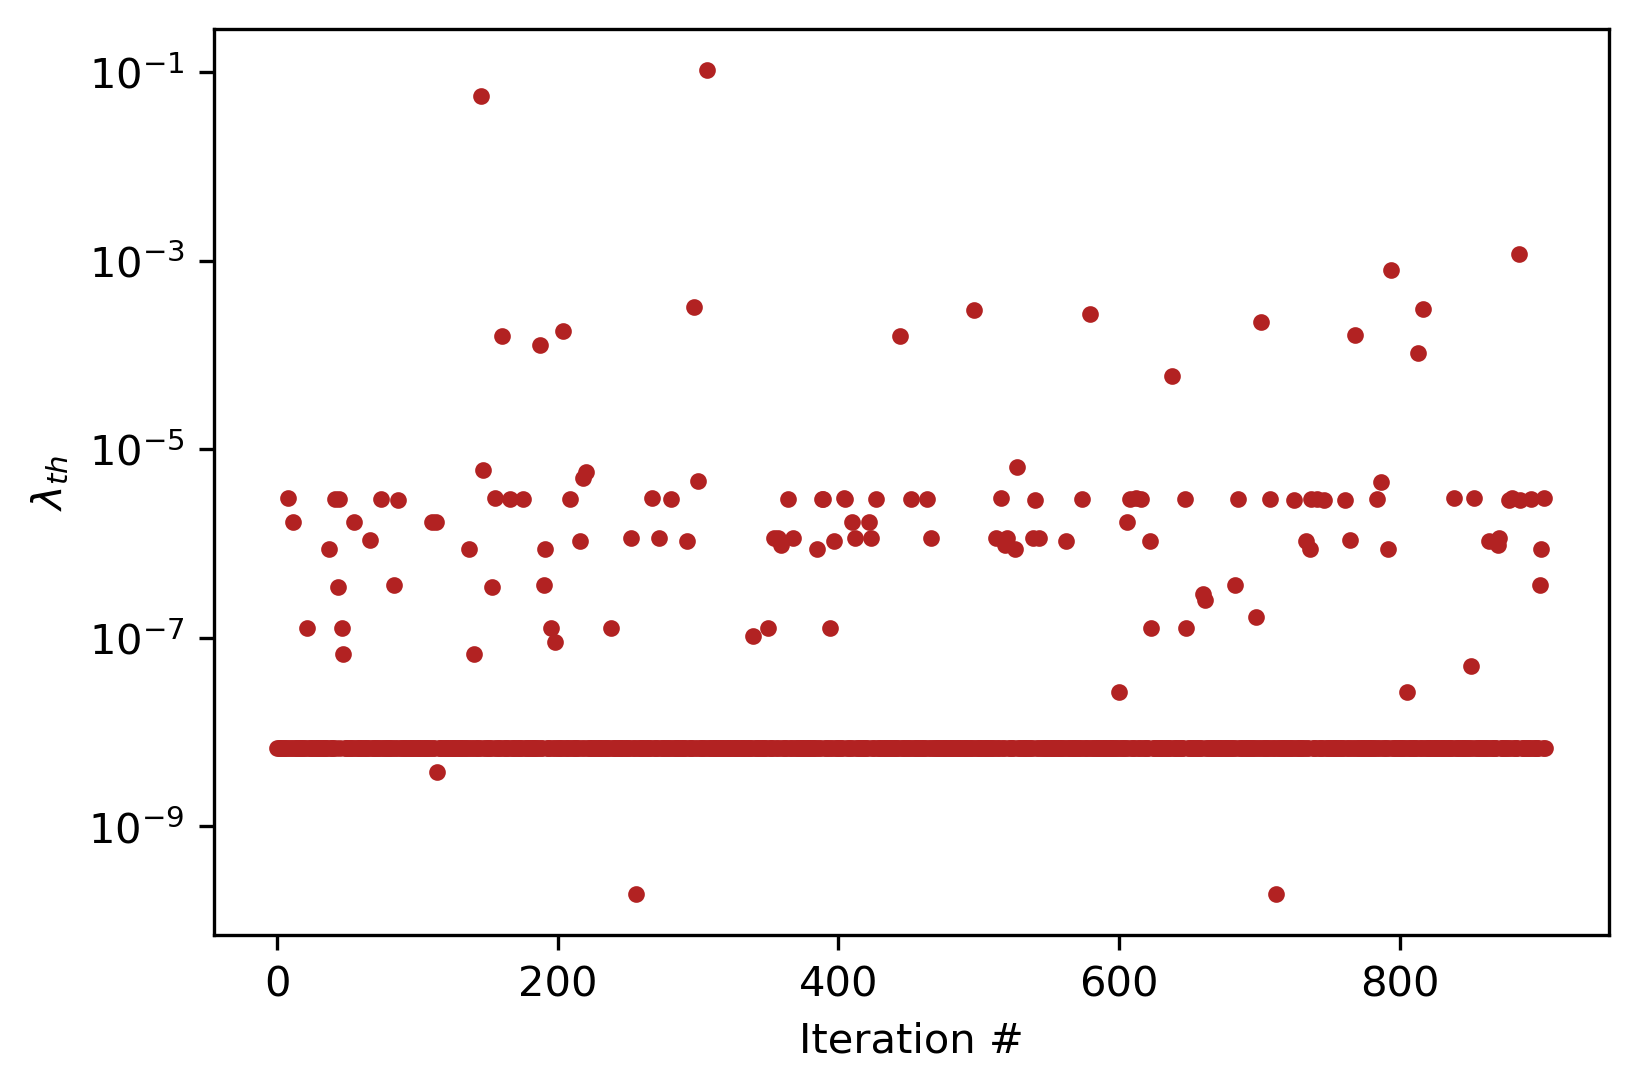

0.9966850828729282


In [722]:
plt.figure(dpi=300)
plt.plot(p_counts[0], '.', color='firebrick')
plt.ylabel(r'$\lambda_{th}$')
plt.xlabel('Iteration #')
plt.yscale('log')
plt.show()

x = []
for ii, p in enumerate(p_counts[0]):
    if p < 1e-3:
#         print(ii)
        x.append(ii)
    
print(len(x)/len(p_counts[0]))

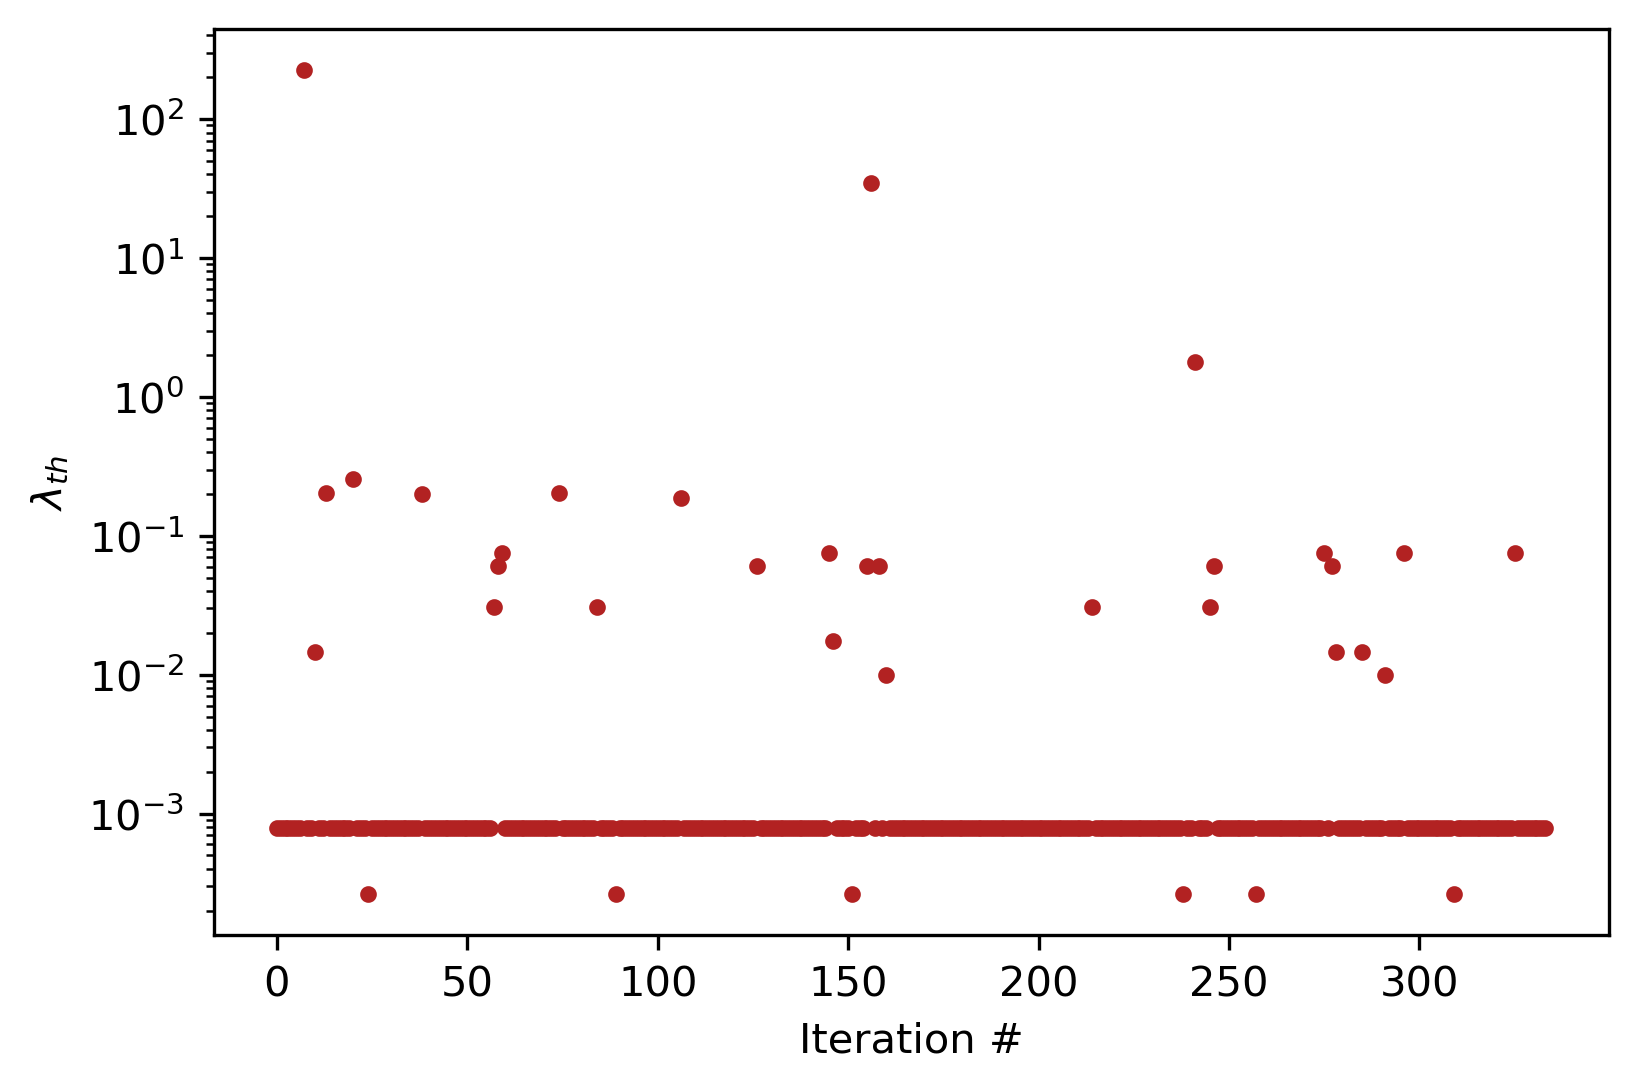

0.9131736526946108


In [718]:
plt.figure(dpi=300)
plt.plot(p_counts[1], '.', color='firebrick')
plt.ylabel(r'$\lambda_{th}$')
plt.xlabel('Iteration #')
plt.yscale('log')
plt.show()

x = []
for ii, p in enumerate(p_counts[1]):
    if p < 1e-3:
#         print(ii)
        x.append(ii)
    
print(len(x)/len(p_counts[1]))

## Wigner Tomography

In [173]:
expt_name = 'wigner_tomo_binary_decomp'
filelist = [3]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        res = np.array(a['res'])
        x = np.array(a['x'])
        y = np.array(a['y'])

In [174]:
# df = pd.DataFrame(pd.DataFrame(x), pd.DataFrame(y), pd.DataFrame(res))


df = pd.DataFrame({'X':x, 'Y': y, 'res': res})

In [175]:
df

X     Y  res
0     -0.18 -0.18    0
1     -0.18 -0.14    0
2     -0.18 -0.10    0
3     -0.18 -0.06    0
4     -0.18 -0.02    0
...     ...   ...  ...
45409  0.18  0.02    0
45410  0.18  0.06    0
45411  0.18  0.10    0
45412  0.18  0.14    0
45413  0.18  0.18    0

[45414 rows x 3 columns]

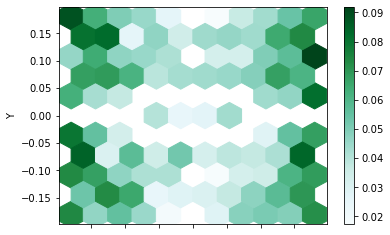

In [176]:
ax = df.plot.hexbin(x='X', y='Y', C = 'res', gridsize=10)

TypeError: hist() got multiple values for argument 'x'

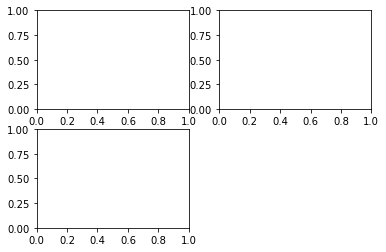

In [160]:
ax = df.hist(x='X', y='Y')

In [149]:
w_values = np.zeros((10,10))
w_number = np.zeros((10,10))

x_min = -1.8
x_max = 1.8
dx = 0.4
x_vec = np.arange(x_min, x_max+dx/2, dx)

y_min = -1.8
y_max = 1.8
dy = 0.4
y_vec = np.arange(y_min, y_max+dy/2, dy)

for i in range(len(res)):
    pass
    



# Readout population

## Optimal shape

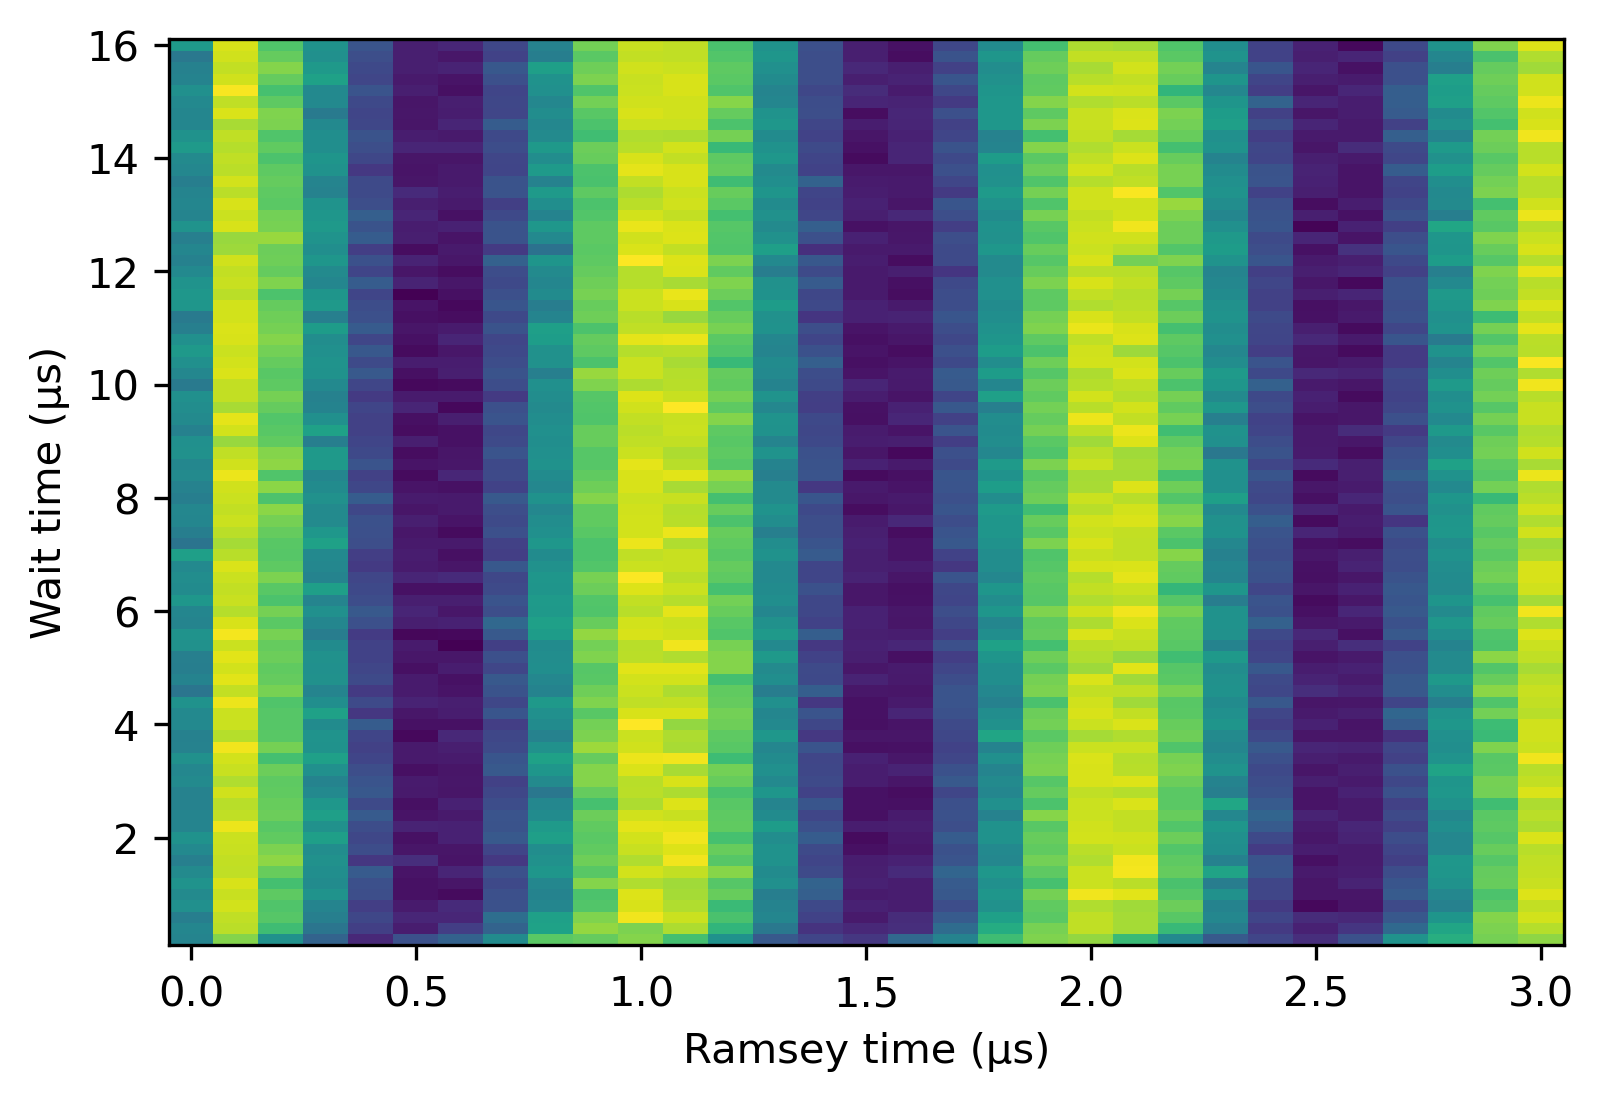

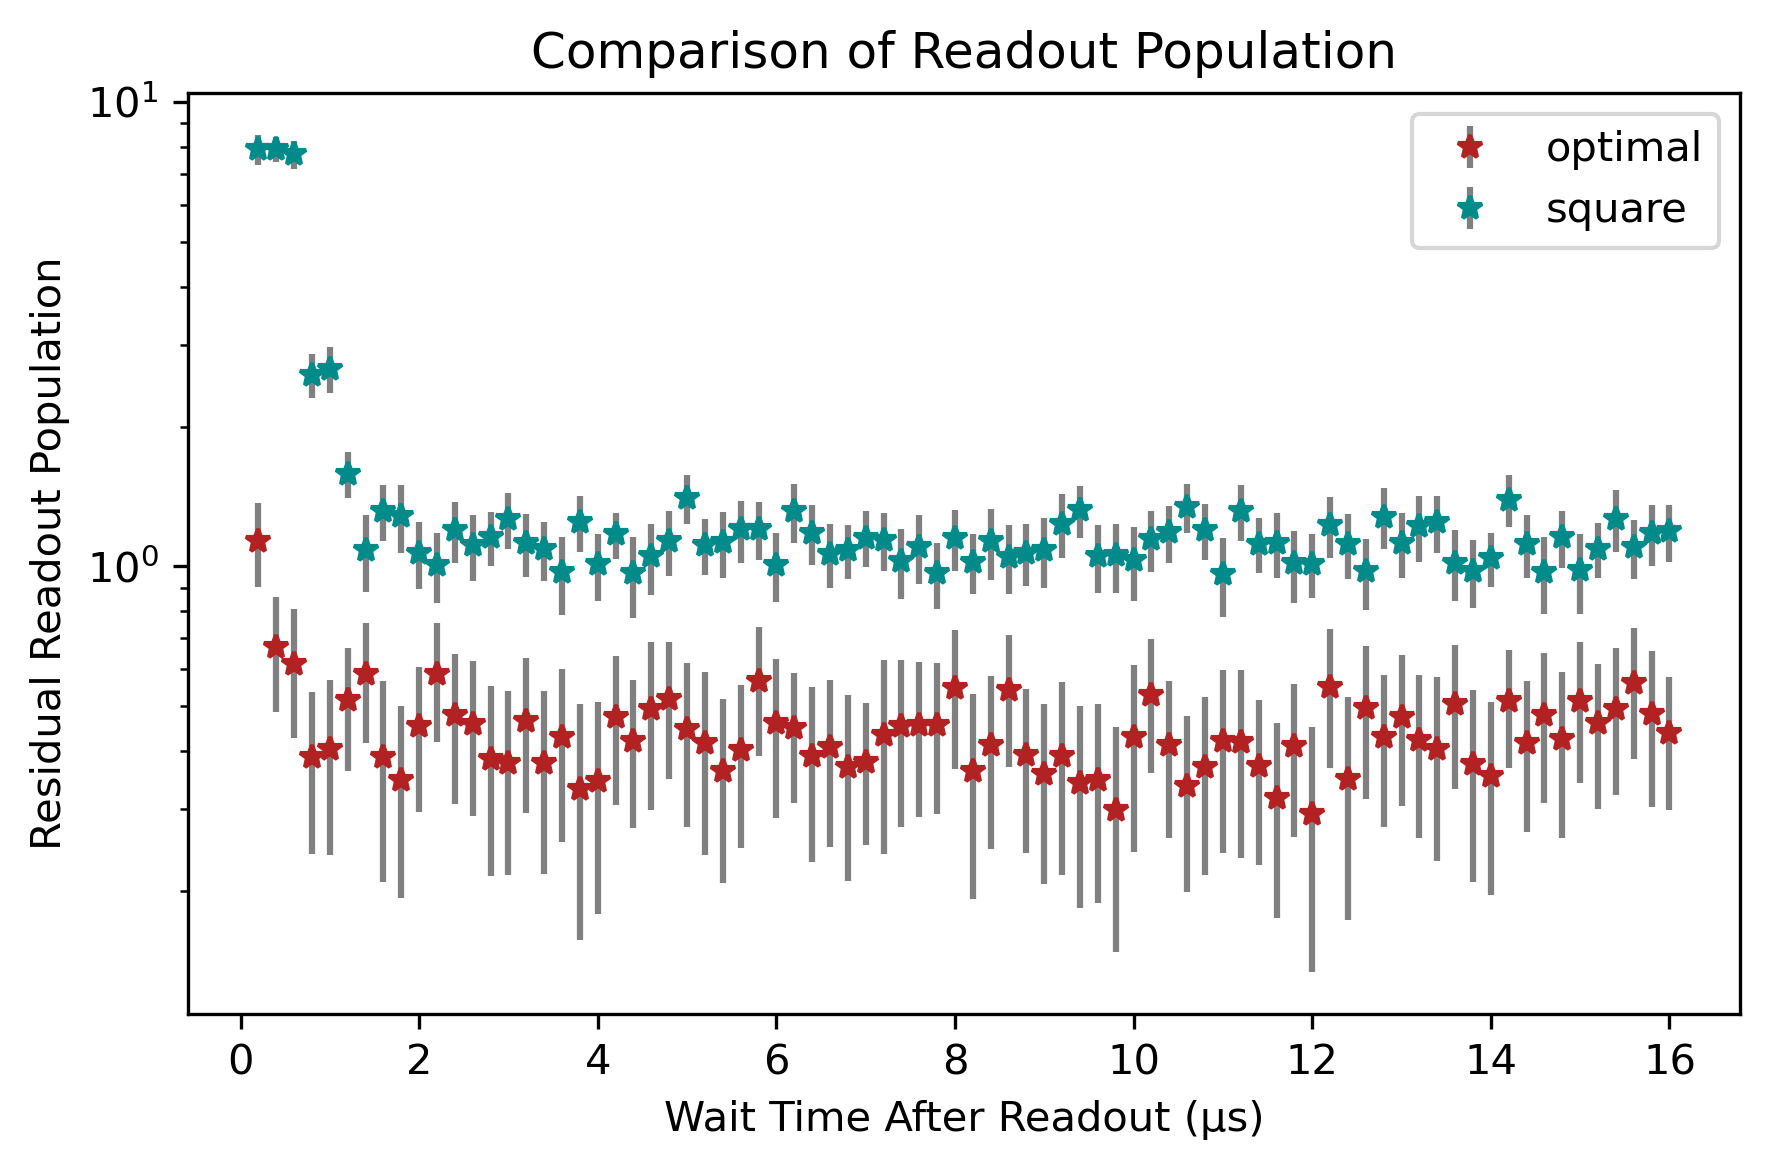

In [47]:
expt_name = 'ramsey_clear'
filelist = [12]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I_opt = pd.DataFrame(a['I'])
        Q_opt = pd.DataFrame(a['Q'])
        wait_times_opt = array(a['wait_time'])/1e9
        ramsey_times_opt = array(a['ramsey_times'])/1e9
        
plt.figure(dpi=300)
plt.pcolormesh(ramsey_times_opt*1e6, wait_times_opt*1e6, Q_opt, shading='auto')
plt.xlabel('Ramsey time (μs)')
plt.ylabel('Wait time (μs)')
# plt.savefig('S:\Morgan\qm_opx\morgan\plots\opt_pulse_2d_buffer_no_wait_time.png')
plt.show()


read_popt_opt = []
read_popt_error_opt = []
for j in range(len(wait_times_opt)):
    y_data = Q_opt.iloc[j]
    x_data = ramsey_times_opt
    popt, pcov = scipy.optimize.curve_fit(ramsfit, x_data, y_data, bounds = (0,[np.inf,2*np.pi,np.inf]))
    read_popt_opt.append(popt[0])
    read_popt_error_opt.append(np.sqrt(np.diag(pcov)[0]))

    
fig, ax1  = plt.subplots(dpi=300)
 
ax1.errorbar(wait_times_opt*1e6, read_popt_opt, yerr = read_popt_error_opt, fmt='*', color='firebrick', 
             ecolor='grey', capthick=2, label='optimal')
ax1.errorbar(wait_times_sq*1e6, read_sq_sq, yerr = read_sq_error_sq, fmt='*', color='darkcyan',
             ecolor='grey', capthick=2, label = 'square')

# ax2.tick_params(axis='y', labelcolor='darkcyan')
#ax1.errorbar(wait_times_opt*1e6, read_popt_opt, fmt='*', color='firebrick', ecolor='grey', capthick=2, label='optimal')
#ax1.errorbar(wait_times_sq*1e6, read_popt_square, fmt='*', color='darkcyan', ecolor='grey', capthick=2, label = 'square')
ax1.set_title('Comparison of Readout Population')
ax1.set_ylabel('Residual Readout Population')
ax1.set_xlabel('Wait Time After Readout (μs)')
#ax1.set_ylim(-.1, 1)
#ax2.set_ylim(-.1, 1)
ax1.set_yscale('log')
ax2.set_yscale('log')
plt.legend()
plt.tight_layout()
# plt.savefig('../plots/Readout_Popt_Comp_talk_full.pdf')
plt.show()

## Square pulse

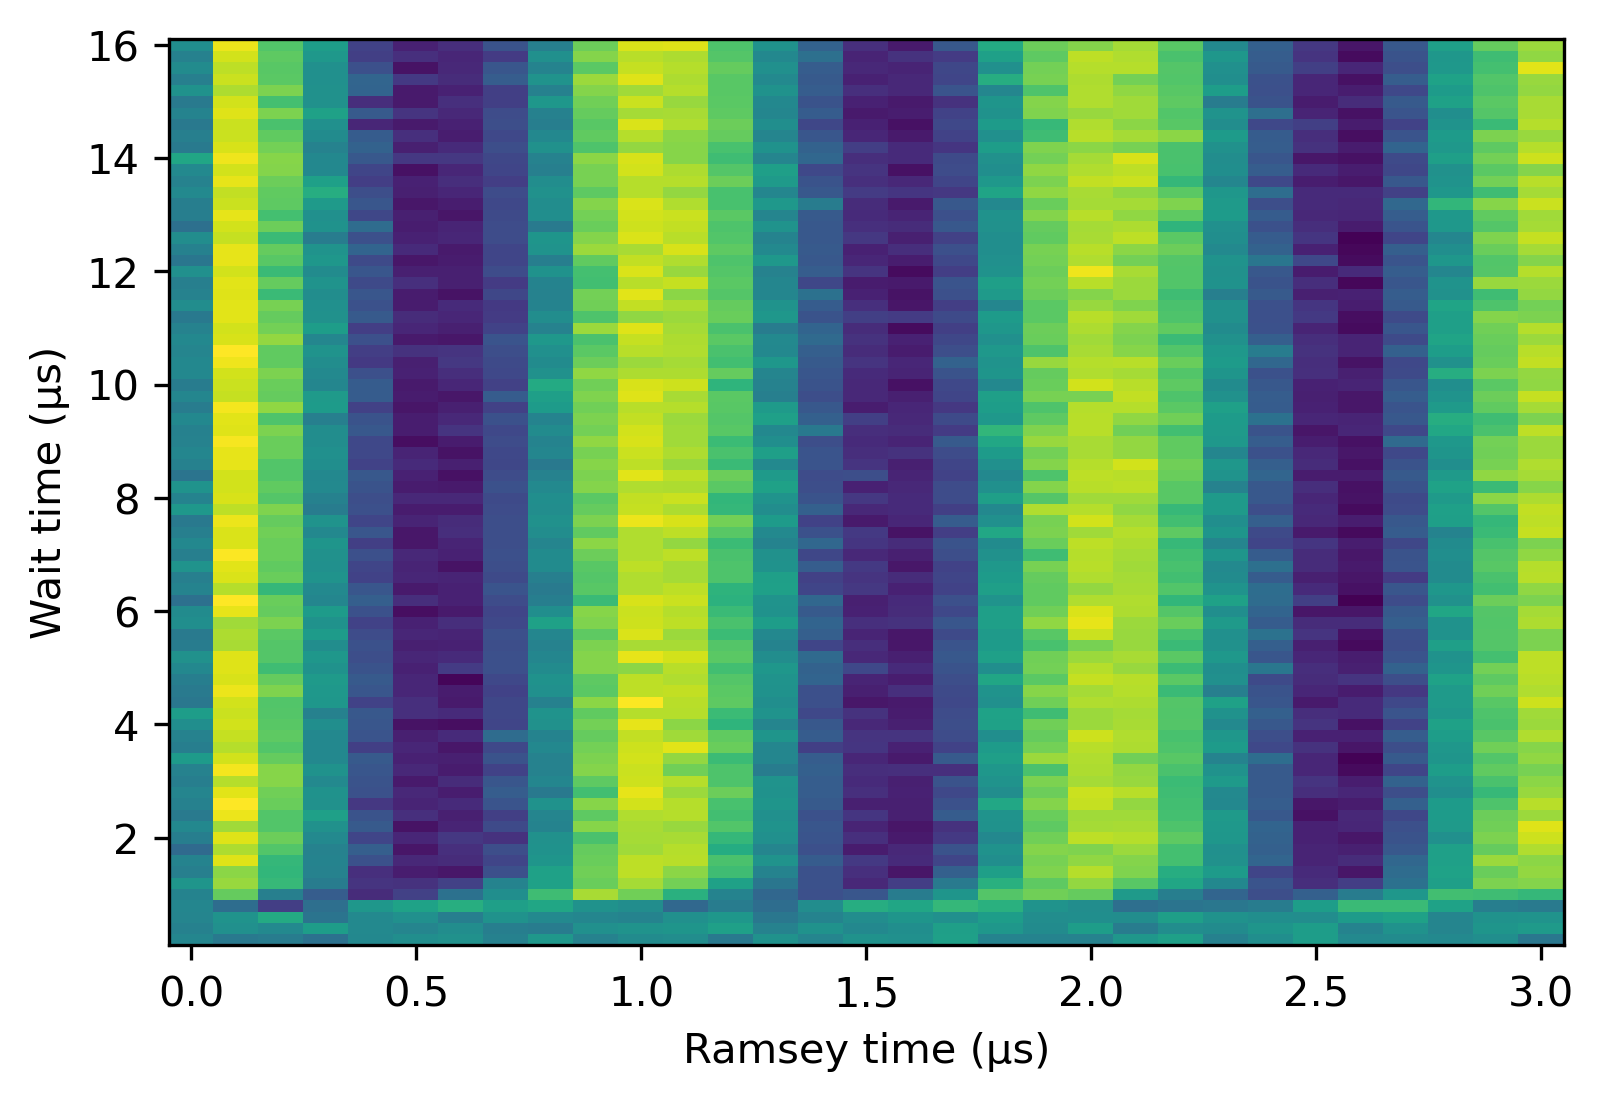

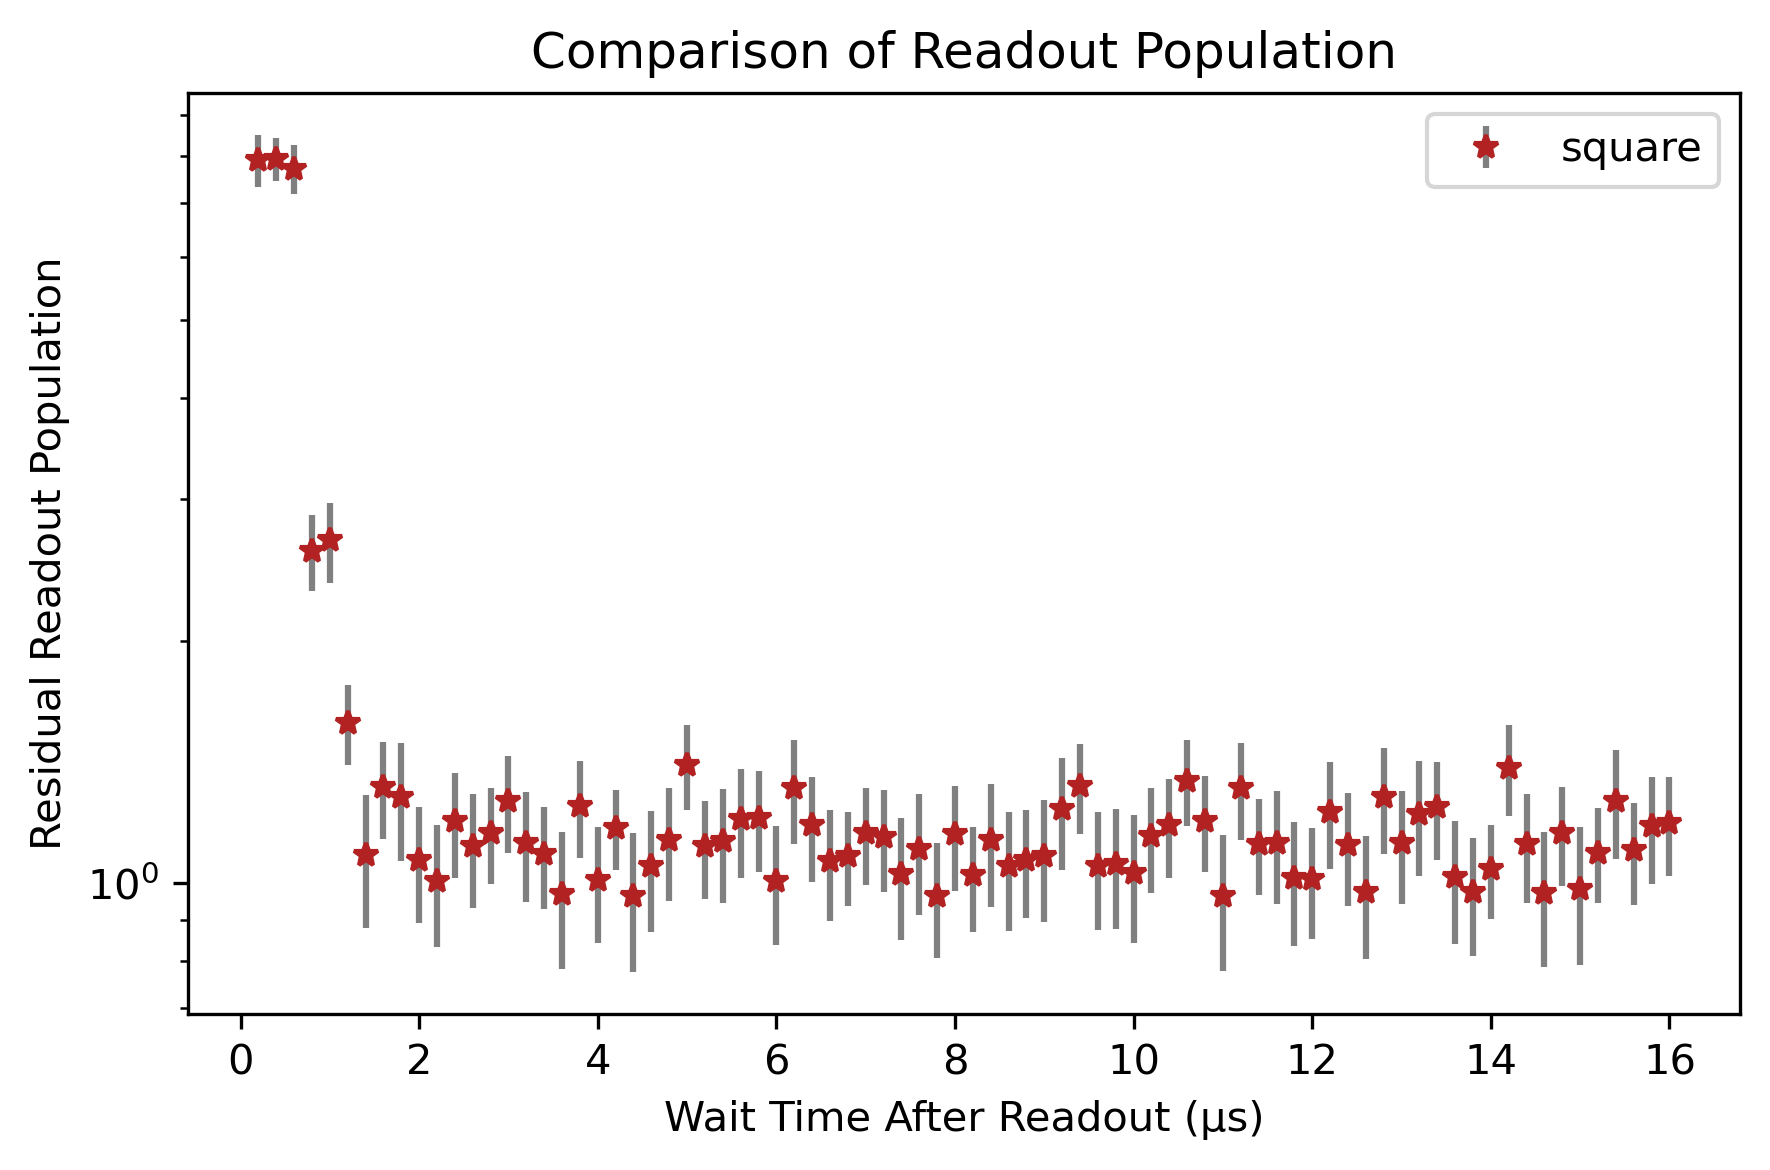

In [46]:
expt_name = 'ramsey_square'
filelist = [4]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I_sq = pd.DataFrame(a['I'])
        Q_sq = pd.DataFrame(a['Q'])
        wait_times_sq = array(a['wait_time'])/1e9
        ramsey_times_sq = array(a['ramsey_times'])/1e9
        
plt.figure(dpi=300)
plt.pcolormesh(ramsey_times_sq*1e6, wait_times_sq*1e6, Q_sq, shading='auto')
plt.xlabel('Ramsey time (μs)')
plt.ylabel('Wait time (μs)')
# plt.savefig('S:\Morgan\qm_opx\morgan\plots\sq_pulse_2d_buffer_no_wait_time.png')
plt.show()


read_sq_sq = []
read_sq_error_sq = []
for j in range(len(wait_times_sq)):
    y_data = Q_sq.iloc[j]
    x_data = ramsey_times_sq
    psq, pcov = scipy.optimize.curve_fit(ramsfit, x_data, y_data, bounds = (0,[np.inf,2*np.pi,np.inf]))
    read_sq_sq.append(psq[0])
    read_sq_error_sq.append(np.sqrt(np.diag(pcov)[0]))

    
fig, ax1  = plt.subplots(dpi=300)
 
ax1.errorbar(wait_times_sq*1e6, read_sq_sq, yerr = read_sq_error_sq, fmt='*', color='firebrick', 
             ecolor='grey', capthick=2, label='square')

# ax1.errorbar(wait_times_sq*1e6, read_psq_square, yerr = read_psq_error_square, fmt='*', color='darkcyan',
#              ecolor='grey', capthick=2, label = 'square')
# ax2.tick_params(axis='y', labelcolor='darkcyan')
#ax1.errorbar(wait_times_sq*1e6, read_psq_sq, fmt='*', color='firebrick', ecolor='grey', capthick=2, label='sqimal')
#ax1.errorbar(wait_times_sq*1e6, read_psq_square, fmt='*', color='darkcyan', ecolor='grey', capthick=2, label = 'square')
ax1.set_title('Comparison of Readout Population')
ax1.set_ylabel('Residual Readout Population')
ax1.set_xlabel('Wait Time After Readout (μs)')
#ax1.set_ylim(-.1, 1)
#ax2.set_ylim(-.1, 1)
ax1.set_yscale('log')
# ax2.set_yscale('log')
plt.legend()
plt.tight_layout()
# plt.savefig('../plots/Readout_Psq_Comp_talk_full.pdf')
plt.show()

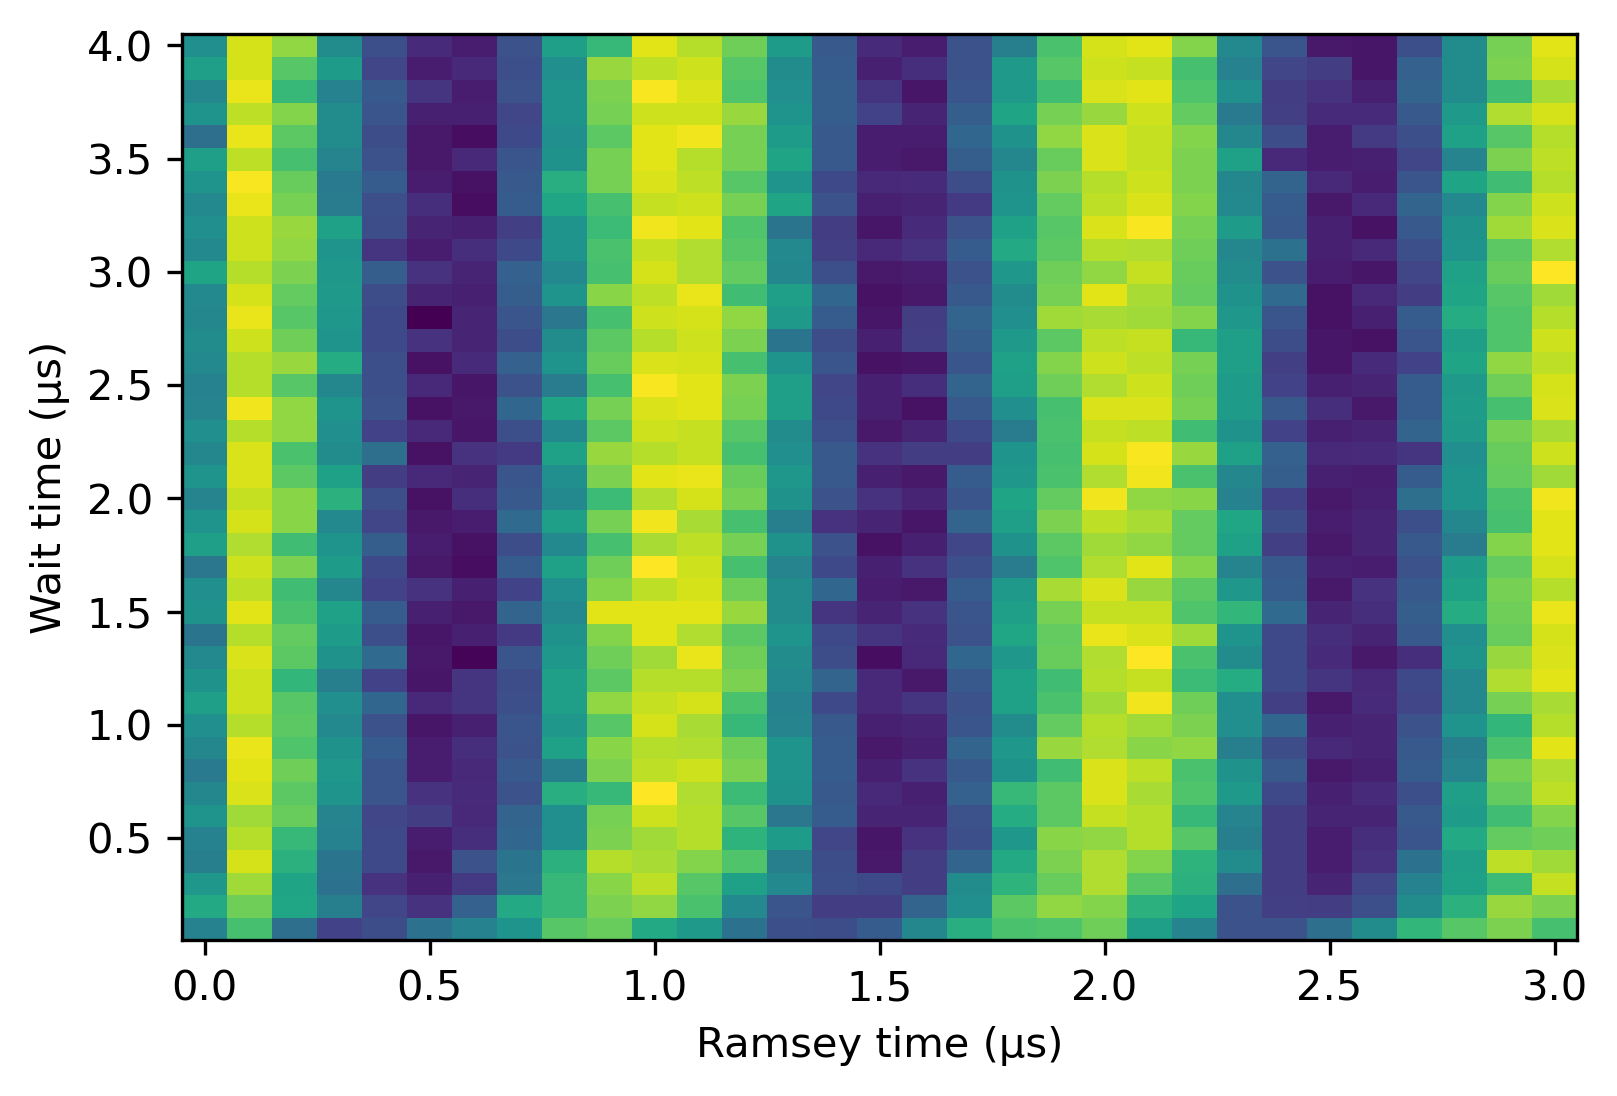

In [22]:
plt.figure(dpi=300)
plt.pcolormesh(ramsey_times_opt*1e6, wait_times_opt*1e6, q_rot_opt, shading='auto')
plt.xlabel('Ramsey time (μs)')
plt.ylabel('Wait time (μs)')
# plt.savefig('S:\Morgan\qm_opx\morgan\plots\opt_pulse_2d_buffer_no_wait_time.png')
plt.show()

# plt.figure(dpi=300)
# plt.pcolormesh(ramsey_times_sq*1e6, wait_times_sq*1e6, i_rot_sq, shading='auto')
# plt.xlabel('Ramsey time (μs)')
# plt.ylabel('Wait time (μs)')
# # plt.savefig('S:\Morgan\qm_opx\morgan\plots\square_pulse_2d_buffer.png')
# plt.show()

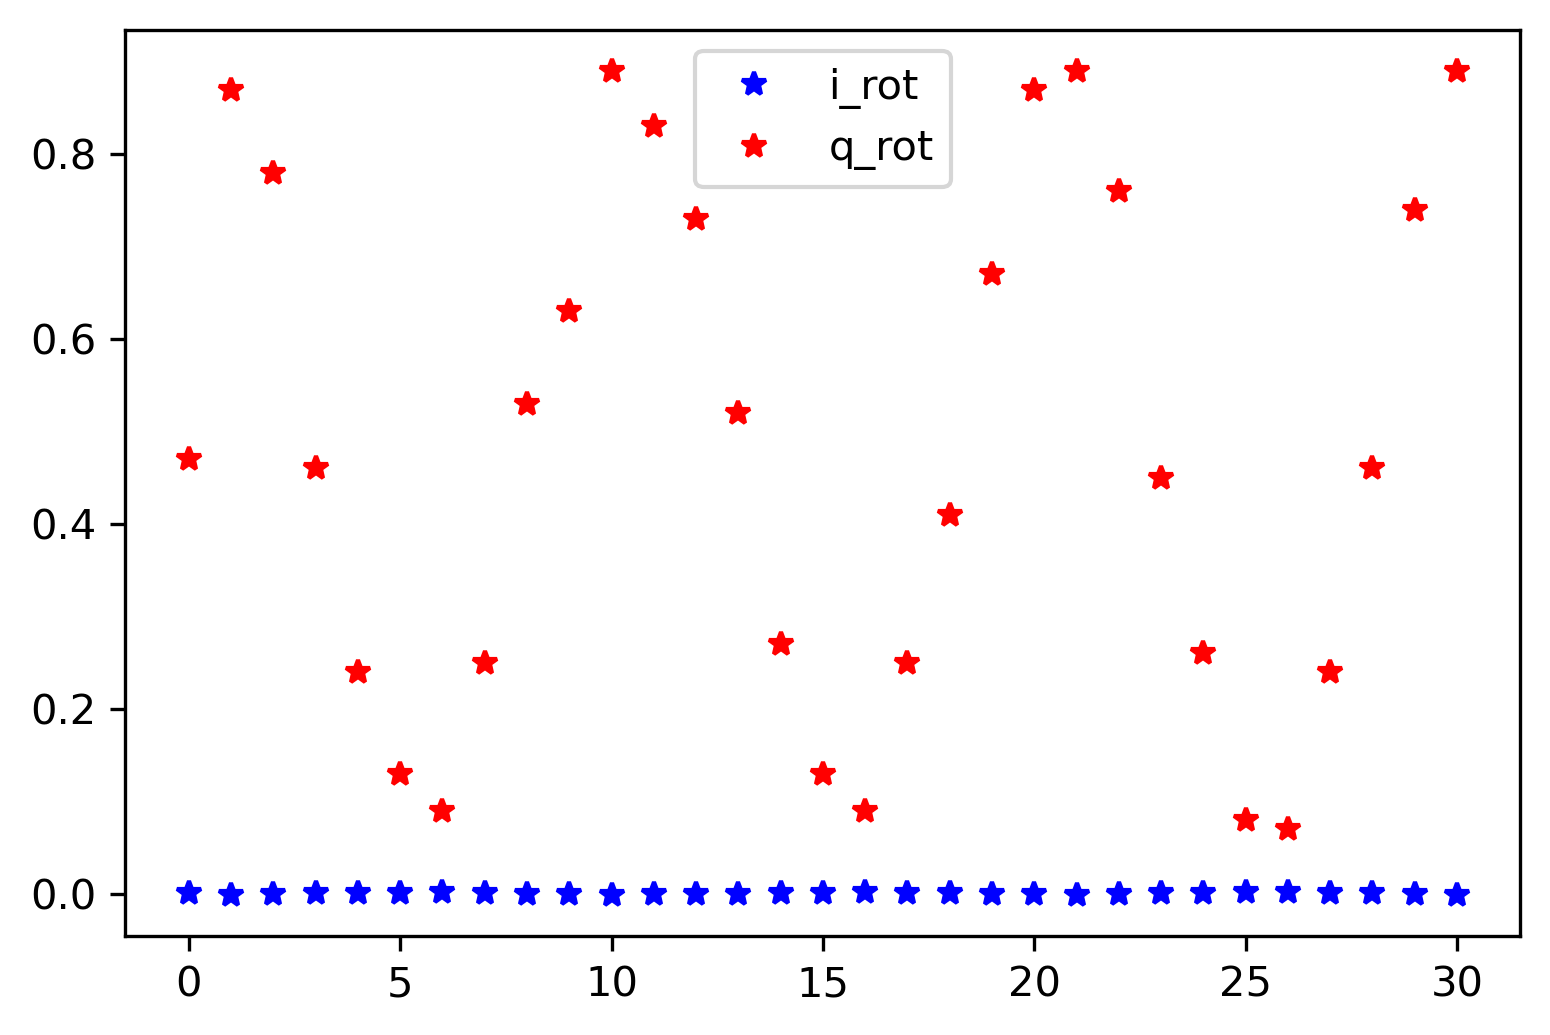

In [23]:
plt.figure(dpi=300)
plt.plot(i_rot_opt.iloc[-1], 'b*', label='i_rot')
plt.plot(q_rot_opt.iloc[-1], 'r*', label='q_rot')
plt.legend()
plt.show()

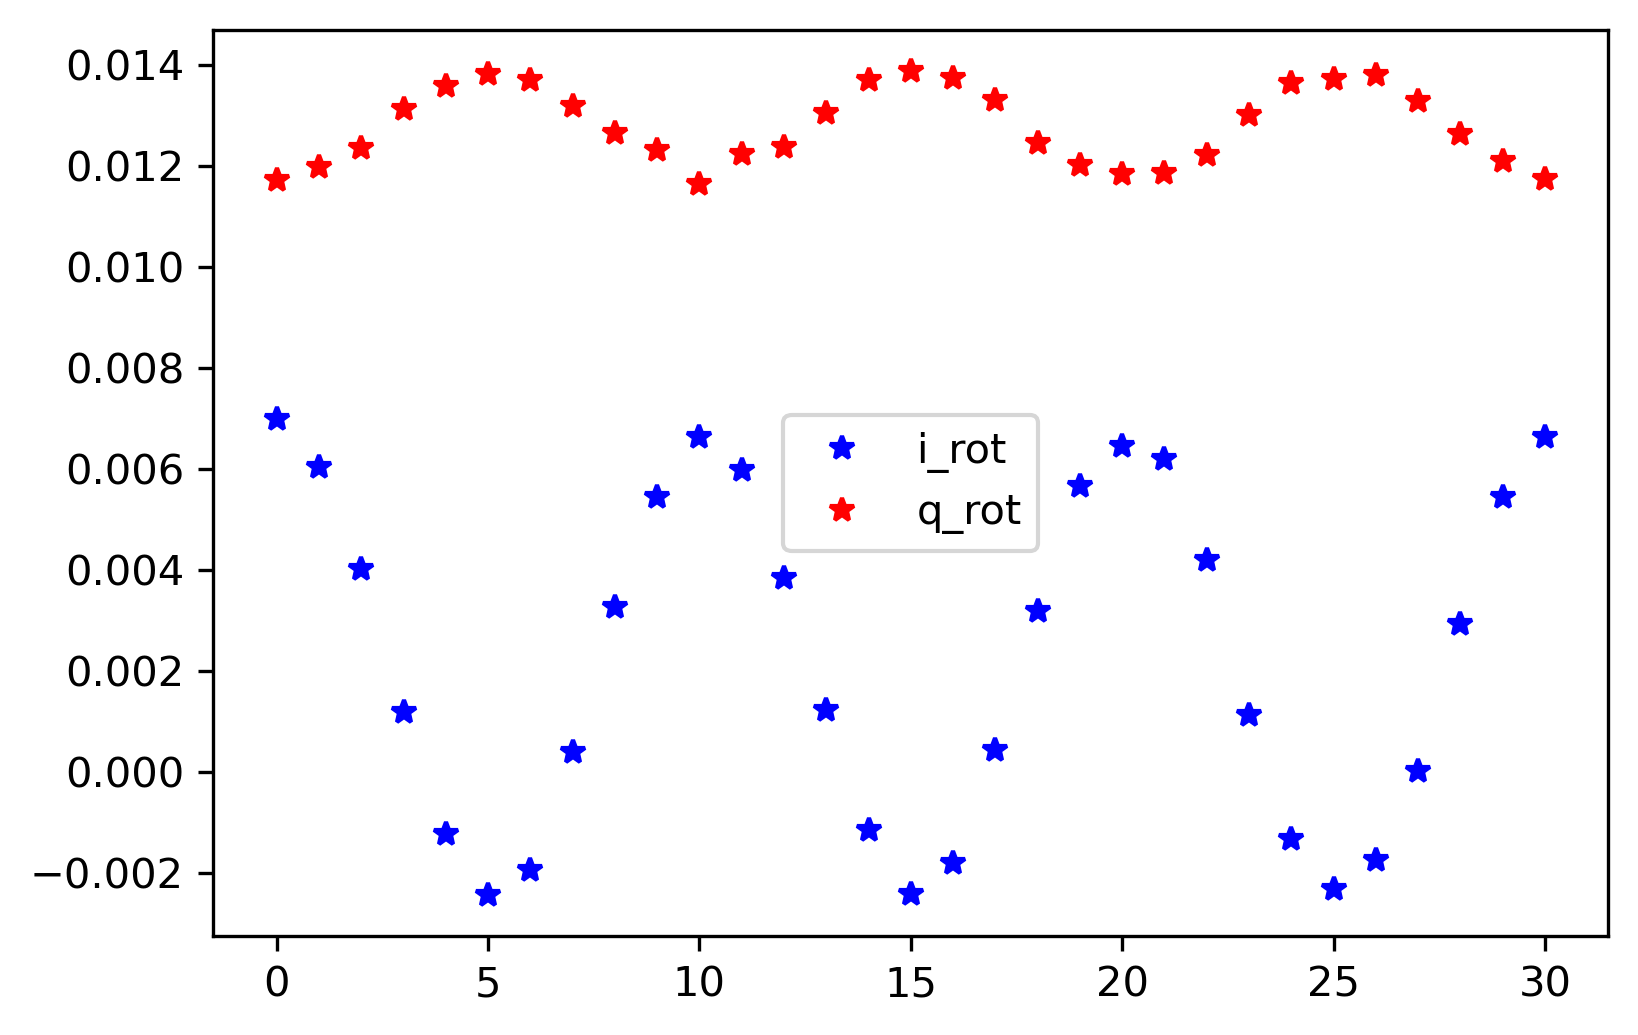

In [26]:
plt.figure(dpi=300)
plt.plot(i_rot_sq.iloc[-1], 'b*', label='i_rot')
plt.plot(q_rot_sq.iloc[-1], 'r*', label='q_rot')
plt.legend()
plt.show()

60.1064008175307


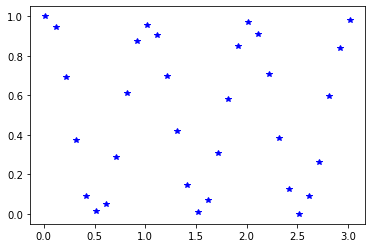

126.9510909108377


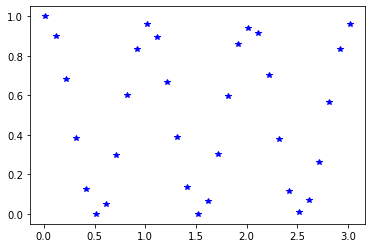

In [302]:
g = min(i_rot_opt.iloc[-1])
e = max(i_rot_opt.iloc[-1])
# g = -0.00952391
# e = 0.00883598

i_cal_opt = abs((i_rot_opt - g))/abs((-g + e))
plt.figure()
plt.plot(ramsey_times_opt*1e6, i_cal_opt.iloc[-1], 'b*')
p = fitdecaysin(ramsey_times_opt*1e6, i_cal_opt.iloc[-1])
print(p[3])
plt.show()


g = min(i_rot_sq.iloc[-1])
e = max(i_rot_sq.iloc[-1])

# g = -0.00936313
# e = 0.00924562
plt.figure()
i_cal_sq = (i_rot_sq - g)/(-g + e)
plt.plot(ramsey_times_sq*1e6, i_cal_sq.iloc[-1], 'b*')
p = fitdecaysin(ramsey_times_sq*1e6, i_cal_sq.iloc[-1])
print(p[3])
plt.show()

0.001930362852654799


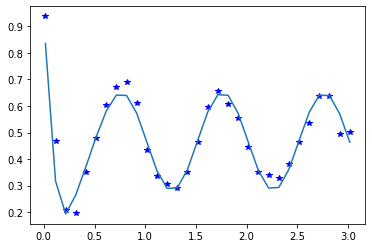

[ 2.23901895 10.60935969  0.93282584]


In [132]:
x_data = ramsey_times
y_data = i_cal_sq.iloc[8]

plt.figure()
plt.plot(x_data*1e6, y_data, 'b*')
popt, pcov = scipy.optimize.curve_fit(ramsfit, x_data[2:], y_data[2:])

plt.plot(x_data*1e6, ramsfit(x_data, popt[0], popt[1], popt[2]))
print(p[3])
plt.show()
print(popt)

C:\Users\slab\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


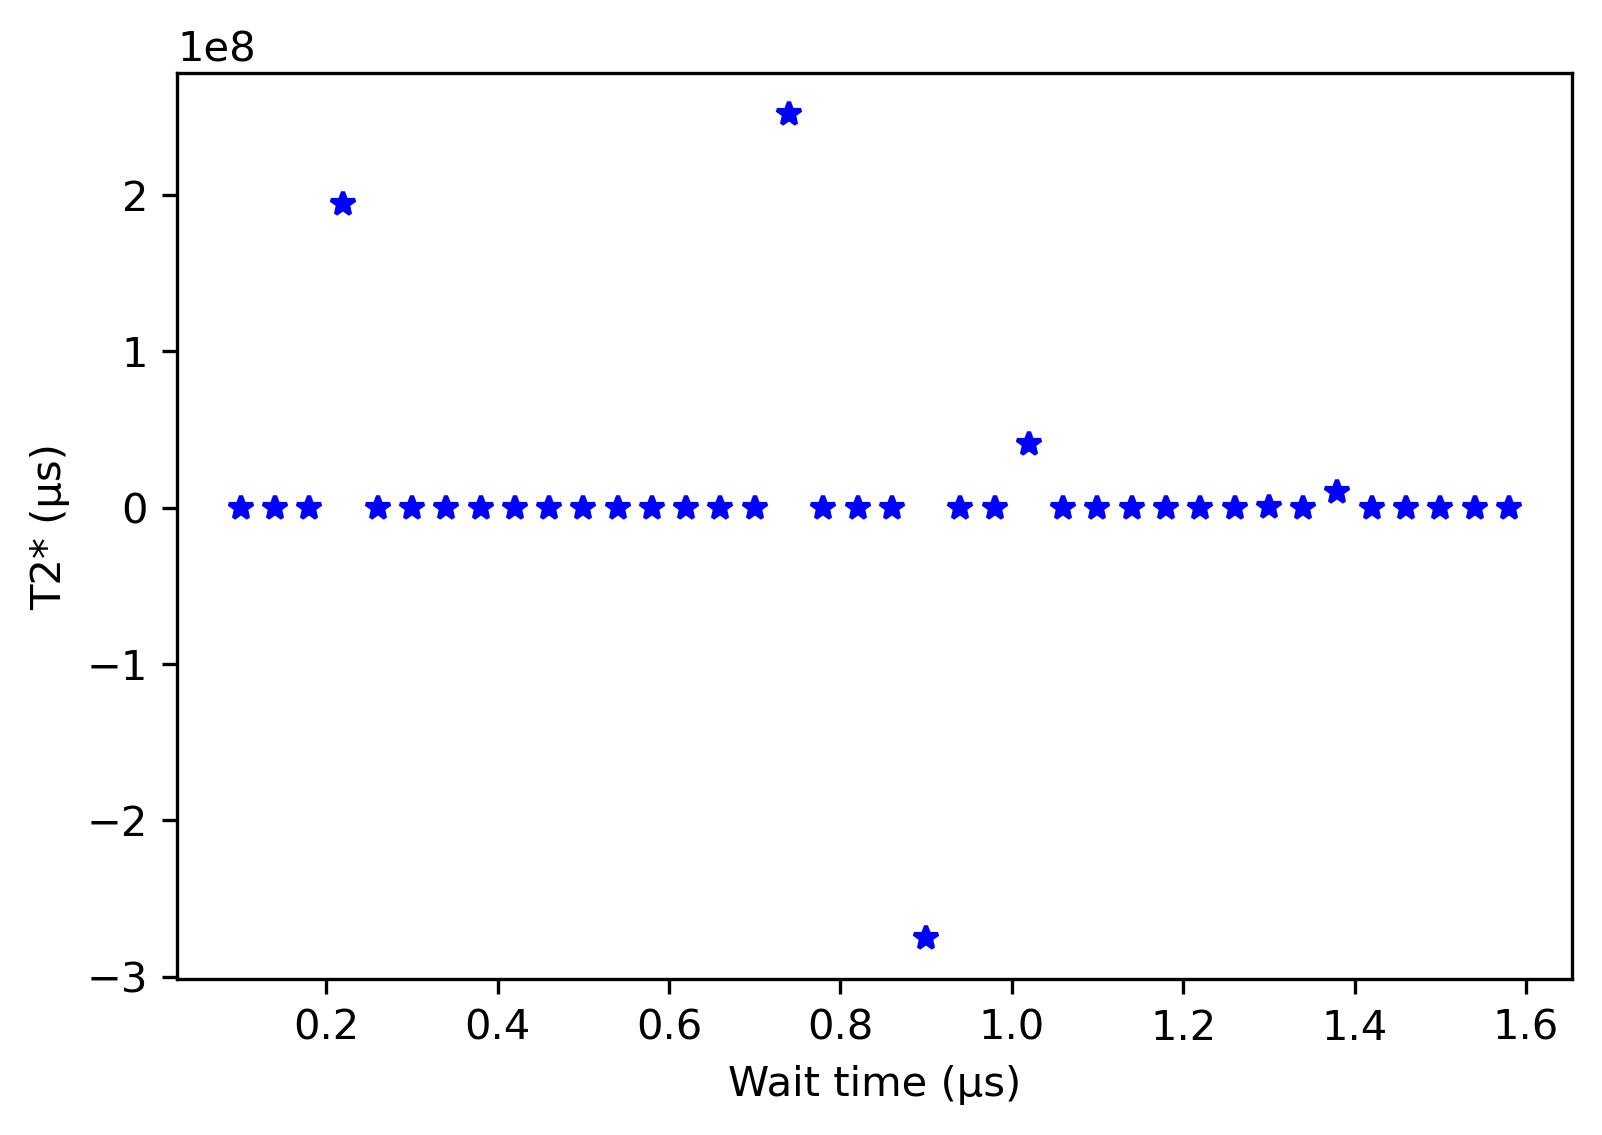

In [133]:
t2_wait = []
for i in range(len(wait_times)):
    x = np.array(ramsey_times*1e6)
    y = np.array(i_cal_opt.iloc[i])
    p = fitdecaysin(x, y, showfit=False)
    if p[3] > 200:
        p = fitdecaysin(x[2:-3], y[2:-3], showfit=False)

    t2_wait.append(p[3])
plt.figure(dpi=300)
plt.plot(wait_times*1e6, t2_wait, 'b*')
plt.ylabel('T2* (μs)')
plt.xlabel('Wait time (μs)')
plt.show()

## Comparison

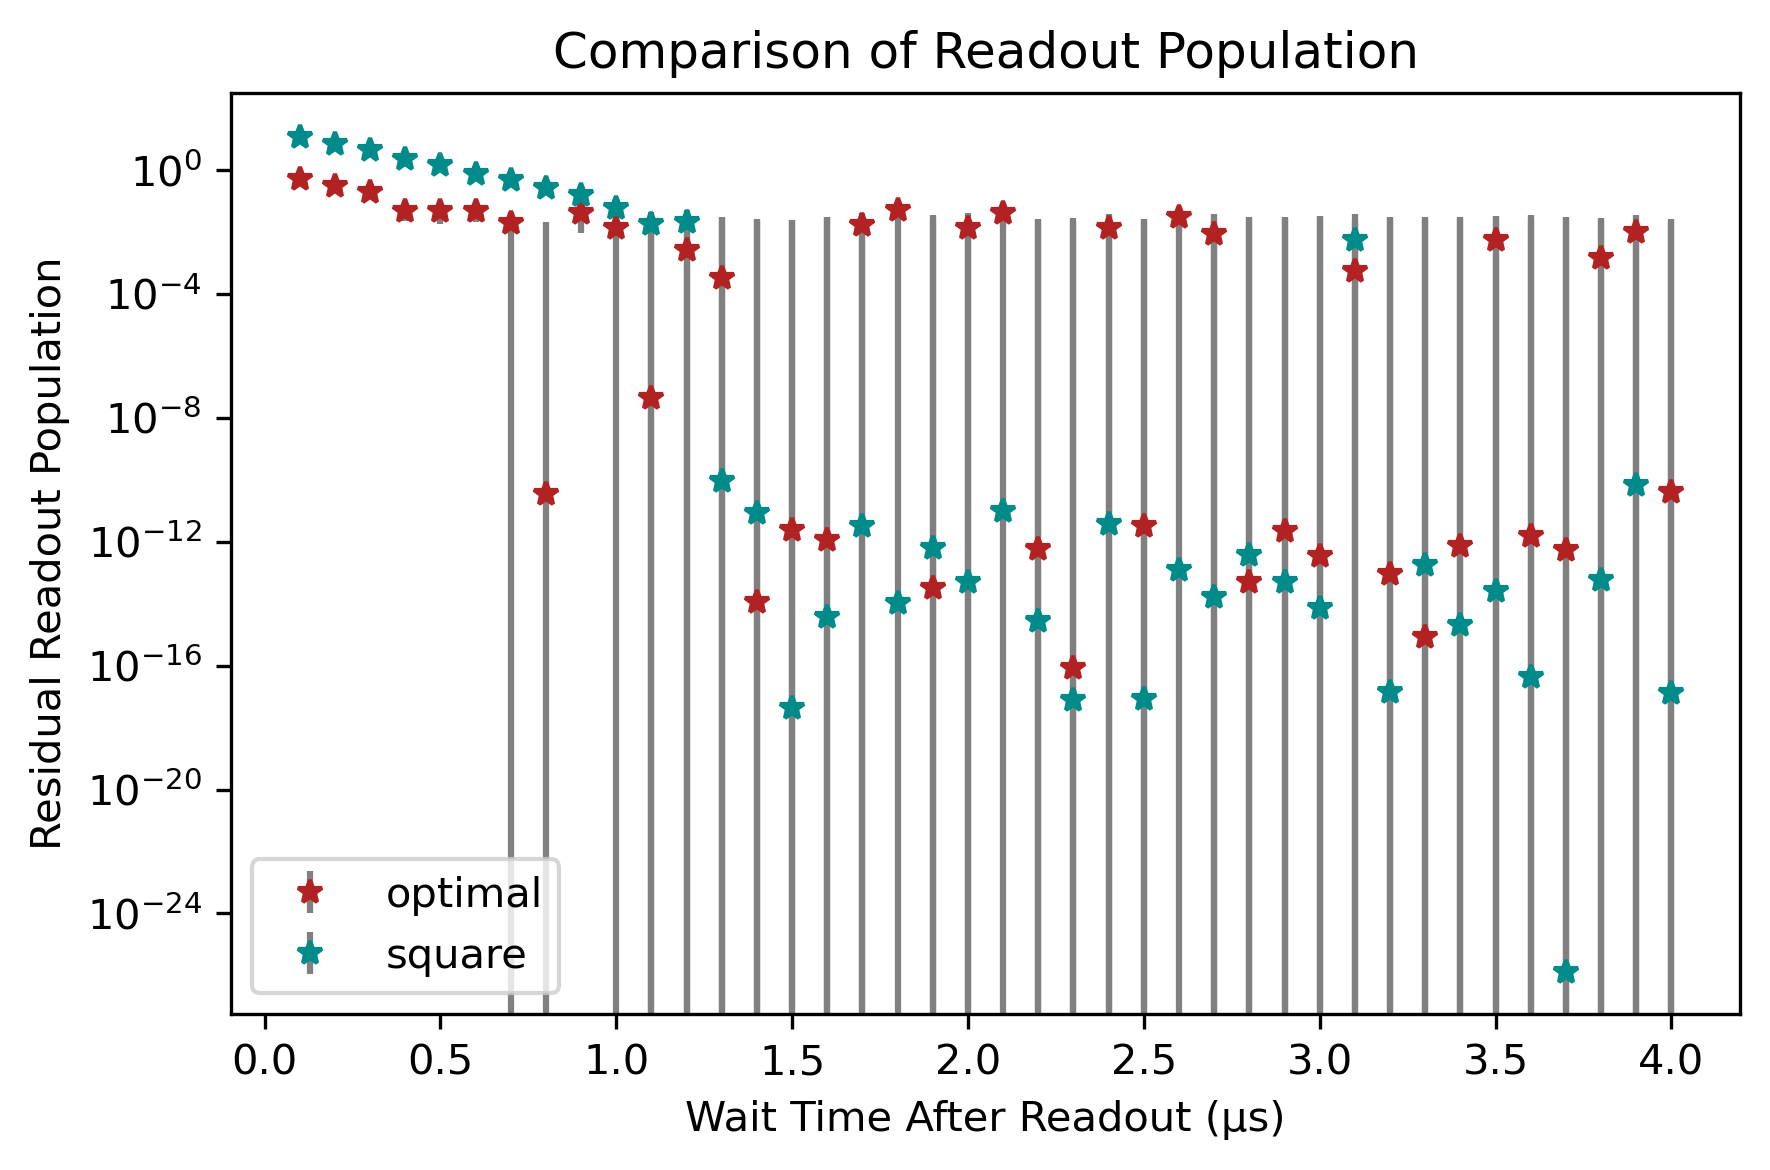

In [333]:
read_popt_opt = []
read_popt_error_opt = []
for j in range(len(wait_times_opt)):
    y_data = i_cal_opt.iloc[j]
    x_data = ramsey_times_opt
    popt, pcov = scipy.optimize.curve_fit(ramsfit, x_data, y_data, bounds = (0,[np.inf,2*np.pi,np.inf]))
    read_popt_opt.append(popt[0])
    read_popt_error_opt.append(np.sqrt(np.diag(pcov)[0]))
    
read_popt_square = []
read_popt_error_square = []
for j in range(len(wait_times_sq)):
    y_data = i_cal_sq.iloc[j]
    x_data = ramsey_times_sq
    popt, pcov = scipy.optimize.curve_fit(ramsfit, x_data[2:], y_data[2:],bounds = (0,[np.inf,2*np.pi,np.inf]))
    read_popt_square.append(popt[0])
    read_popt_error_square.append(np.sqrt(np.diag(pcov)[0]))


fig, ax1  = plt.subplots(dpi=300)
 
ax1.errorbar(wait_times_opt*1e6, read_popt_opt, yerr = read_popt_error_opt, fmt='*', color='firebrick', 
             ecolor='grey', capthick=2, label='optimal')

ax1.errorbar(wait_times_sq*1e6, read_popt_square, yerr = read_popt_error_square, fmt='*', color='darkcyan',
             ecolor='grey', capthick=2, label = 'square')
# ax2.tick_params(axis='y', labelcolor='darkcyan')
#ax1.errorbar(wait_times_opt*1e6, read_popt_opt, fmt='*', color='firebrick', ecolor='grey', capthick=2, label='optimal')
#ax1.errorbar(wait_times_sq*1e6, read_popt_square, fmt='*', color='darkcyan', ecolor='grey', capthick=2, label = 'square')
ax1.set_title('Comparison of Readout Population')
ax1.set_ylabel('Residual Readout Population')
ax1.set_xlabel('Wait Time After Readout (μs)')
#ax1.set_ylim(-.1, 1)
#ax2.set_ylim(-.1, 1)
ax1.set_yscale('log')
ax2.set_yscale('log')
plt.legend()
plt.tight_layout()
# plt.savefig('../plots/Readout_Popt_Comp_talk_full.pdf')
plt.show()

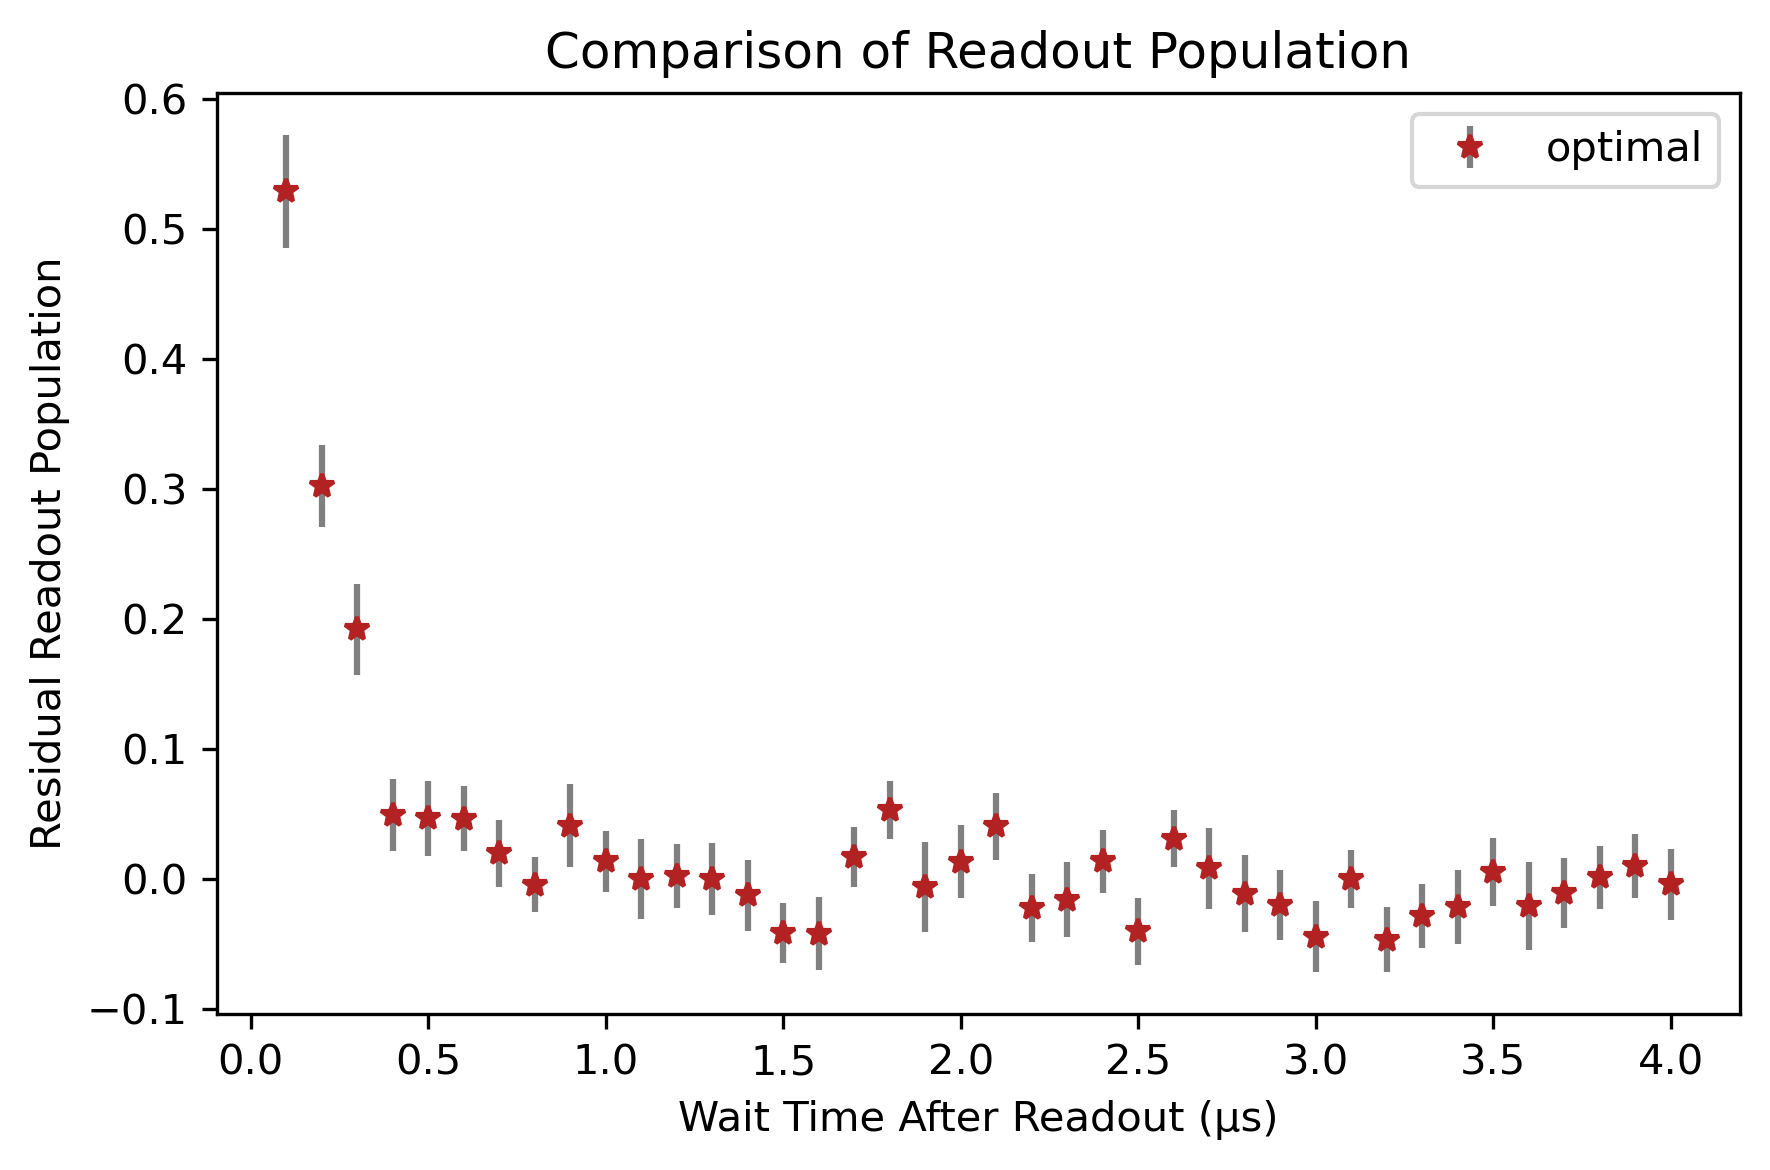

In [298]:
read_popt_opt = []
read_popt_error_opt = []
for j in range(len(wait_times_opt)):
    y_data = i_cal_opt.iloc[j]
    x_data = ramsey_times_opt
    popt, pcov = scipy.optimize.curve_fit(ramsfit, x_data, y_data)
    read_popt_opt.append(popt[0])
    read_popt_error_opt.append(np.sqrt(np.diag(pcov)[0]))

fig, ax1  = plt.subplots(dpi=300)
 
ax1.errorbar(wait_times_opt*1e6, read_popt_opt, yerr = read_popt_error_opt, fmt='*', color='firebrick', 
             ecolor='grey', capthick=2, label='optimal')

# ax1.errorbar(wait_times_sq*1e6, read_popt_square, yerr = read_popt_error_square, fmt='*', color='darkcyan',
#              ecolor='grey', capthick=2, label = 'square')
# ax2.tick_params(axis='y', labelcolor='darkcyan')

ax1.set_title('Comparison of Readout Population')
ax1.set_ylabel('Residual Readout Population')
ax1.set_xlabel('Wait Time After Readout (μs)')
# ax1.set_ylim(-.1, 1)
# ax2.set_ylim(-.1, 1)
# plt.yscale('log')
plt.legend()
plt.tight_layout()
# plt.savefig('../plots/Readout_Popt_Comp_talk_full.pdf')
plt.show()

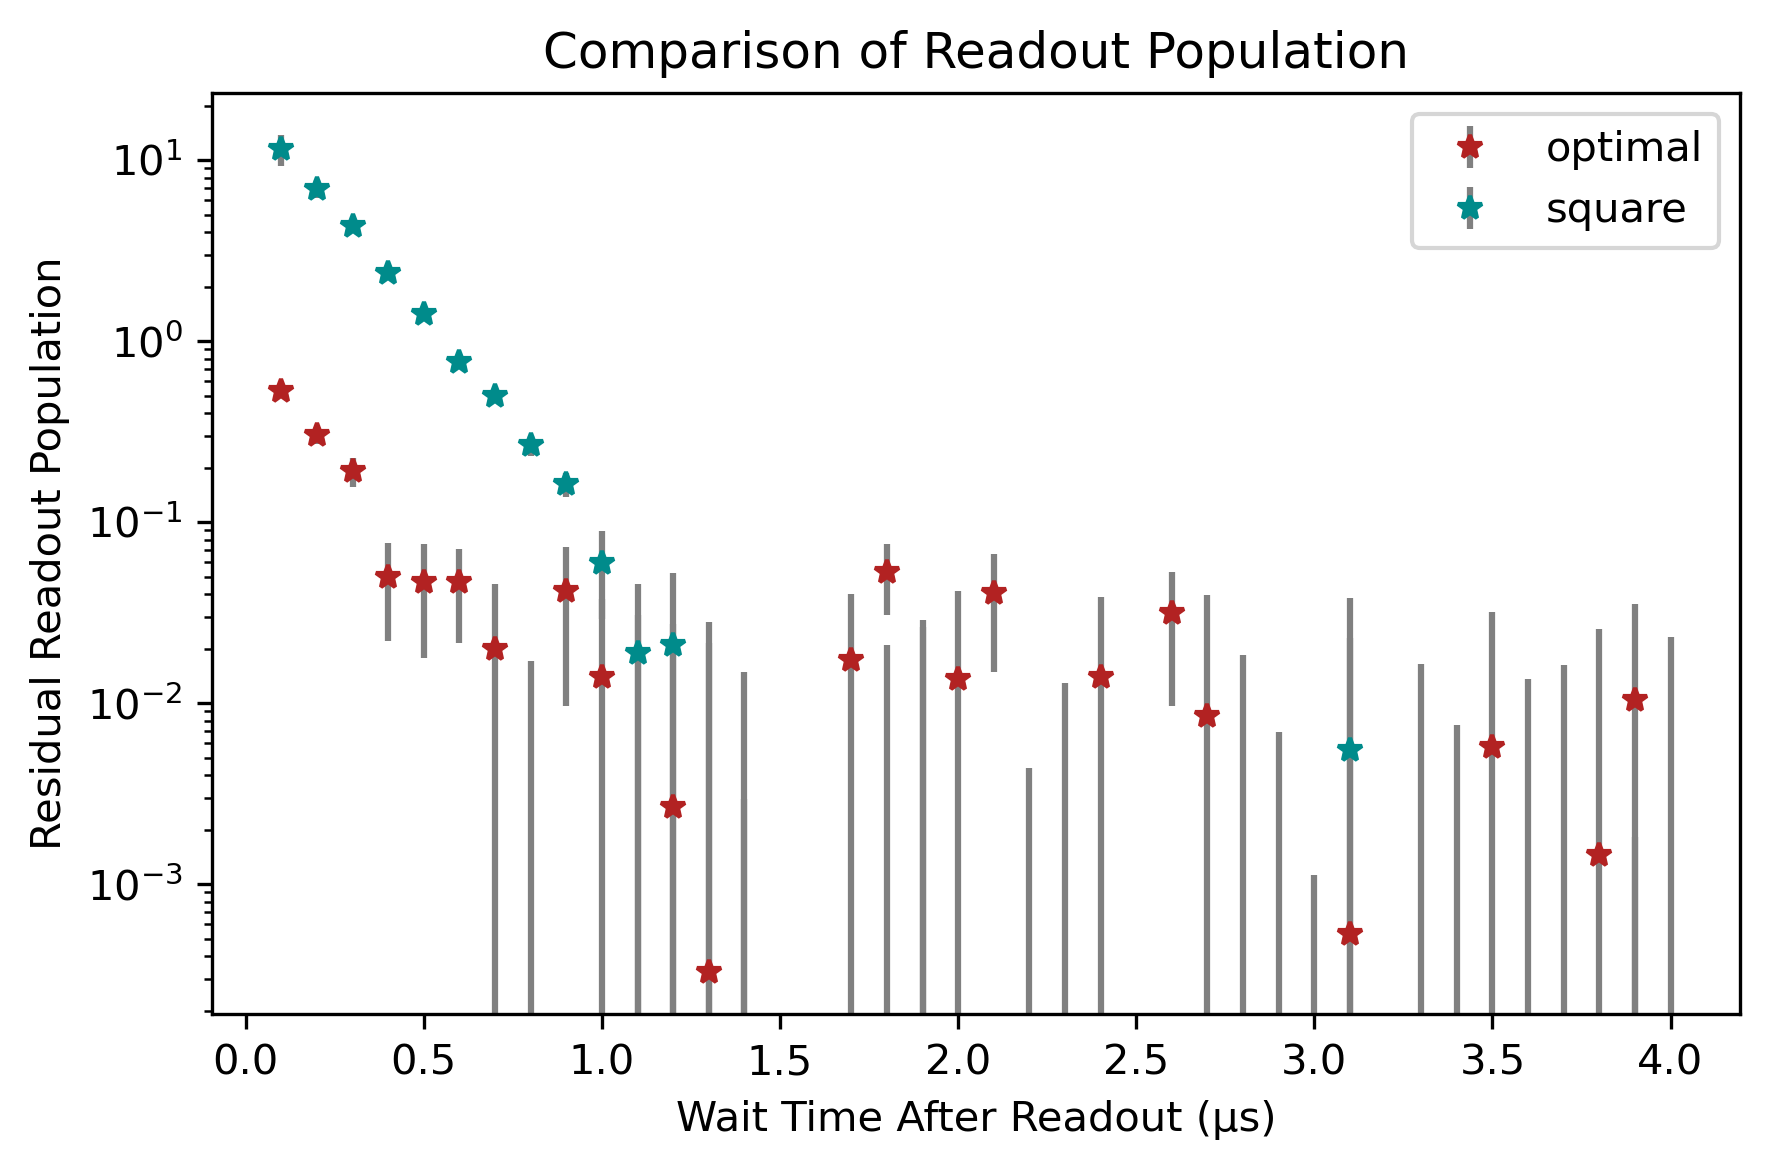

In [304]:
read_popt_opt = []
read_popt_error_opt = []
for j in range(len(wait_times_opt)):
    y_data = i_cal_opt.iloc[j]
    x_data = ramsey_times_opt
    popt, pcov = scipy.optimize.curve_fit(ramsfit, x_data, y_data)
    read_popt_opt.append(popt[0])
    read_popt_error_opt.append(np.sqrt(np.diag(pcov)[0]))
    
read_popt_square = []
read_popt_error_square = []
for j in range(len(wait_times_sq)):
    y_data = i_cal_sq.iloc[j]
    x_data = ramsey_times_sq
    popt, pcov = scipy.optimize.curve_fit(ramsfit, x_data[2:], y_data[2:])
    read_popt_square.append(popt[0])
    read_popt_error_square.append(np.sqrt(np.diag(pcov)[0]))


fig, ax1  = plt.subplots(dpi=300)
 
ax1.errorbar(wait_times_opt*1e6, read_popt_opt, yerr = read_popt_error_opt, fmt='*', color='firebrick', 
             ecolor='grey', capthick=2, label='optimal')

ax1.errorbar(wait_times_sq*1e6, read_popt_square, yerr = read_popt_error_square, fmt='*', color='darkcyan',
             ecolor='grey', capthick=2, label = 'square')
# ax2.tick_params(axis='y', labelcolor='darkcyan')

ax1.set_title('Comparison of Readout Population')
ax1.set_ylabel('Residual Readout Population')
ax1.set_xlabel('Wait Time After Readout (μs)')
# ax1.set_ylim(-.1, 1)
# ax2.set_ylim(-.1, 1)
plt.yscale('log')
plt.legend()
plt.tight_layout()
# plt.savefig('../plots/Readout_Popt_Comp_talk_full.pdf')
plt.show()

In [145]:
10*np.exp(-1.6/0.18)

0.0013791280933656194

[17.72802758  0.19170389  0.25202151] [0.6441008  0.00782116 0.06847254]


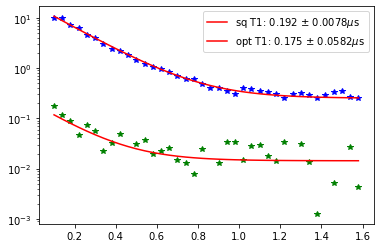

[0.18366301 0.17469616 0.01440297] [0.08260954 0.05822461 0.00342279]


In [146]:
y = np.array(read_popt_square)
x = np.array(wait_times)*1e6

plt.plot(x, y, 'b*')
popt, pcov = scipy.optimize.curve_fit(expfunc_baseline, x, y)
print(popt, np.sqrt(np.diag(pcov)))
plt.plot(x, expfunc_baseline(x, popt[0], popt[1], popt[2]), 'r-', 
         label=r'sq T1: %.3f $\pm$ %.4f$\mu$s'%(popt[1], np.sqrt(np.diag(pcov))[1]))
y = np.array(read_popt_opt)
x = np.array(wait_times)*1e6

plt.plot(x, y, 'g*')
popt, pcov = scipy.optimize.curve_fit(expfunc_baseline, x[2:], y[2:])
plt.plot(x, expfunc_baseline(x, popt[0], popt[1], popt[2]), 'r-', 
         label=r'opt T1: %.3f $\pm$ %.4f$\mu$s'%(popt[1], np.sqrt(np.diag(pcov))[1]))
plt.legend()
plt.yscale('log')
plt.show()
print(popt, np.sqrt(np.diag(pcov)))

0.003333333333333333 0.0007380739030881347
Chi:  0.3804 MHz
Kappa:  0.9149659090909091 MHz
Cavity Occupation 0.00142
Cavity temperature = 53.37698929287676 mK
Cavity temperature+ = 55.03127983687904 mK
Cavity temperature- = 51.37911894753762 mK


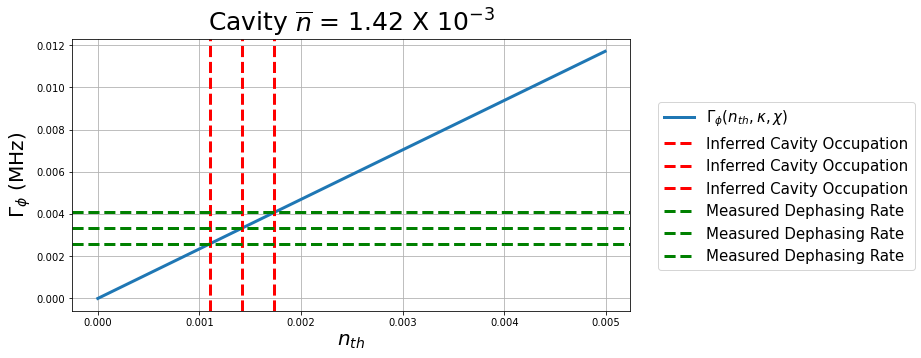

In [474]:
T2 = 120
T2err = 10
T1 = 100
T1err = 10

gph  = 1/(T2) - 1/(2*T1)
gpherr = sqrt( (1/(2*T1))**4*T1err**2 + (1/(T2))**4*T2err**2 )

print (gph, gpherr)

nu_r = 8.0517
Q = 8800.0
kappa = 2*pi*nu_r/Q*1e3

chi = 0.3804*2*pi

print ("Chi: ", chi/(2*pi), "MHz")
print ("Kappa: ", kappa/(2*pi), "MHz")

def temperature_cav(nu,mean_n):
    Kb = 1.38e-23
    h = 6e-34
    return h*nu/(Kb*log((1+mean_n)/mean_n))

def occupation_cav(nu,T):
    Kb = 1.38e-23
    h = 6e-34
    T = T*1e-3
    return 1/(exp(h*nu/(Kb*T))-1)


def dephasing(kappa,chi,nth):
    return kappa/2.0*real(sqrt((1+2*1j*chi/kappa)**2 + ((8*1j*chi*nth))/kappa)-1)

def freq_shift(kappa,chi,nth):
    return kappa/2.0*imag(sqrt((1+2*1j*chi/kappa)**2 + ((8*1j*chi*nth))/kappa))

figure(figsize=(10,5))
subplot(111)
n_th = arange(0.0, 0.005,0.00001)

plot(n_th, array([dephasing(kappa,chi,n) for n in n_th] ), label = '$\Gamma_{\phi}(n_{th}, \kappa, \chi)$', linewidth=3)

n_cav = n_th[argmin(abs(array([dephasing(kappa,chi,n) for n in n_th]) - gph))]
n_cav_pluserr = n_th[argmin(abs(array([dephasing(kappa,chi,n) for n in n_th]) - (gph+gpherr)))]
n_cav_negerr = n_th[argmin(abs(array([dephasing(kappa,chi,n) for n in n_th]) - (gph-gpherr)))]
print ("Cavity Occupation", n_cav)

axvline(n_cav,linestyle='dashed', label="Inferred Cavity Occupation",color='r', linewidth=3)
axvline(n_cav_pluserr,linestyle='dashed', label="Inferred Cavity Occupation",color='r', linewidth=3)
axvline(n_cav_negerr,linestyle='dashed', label="Inferred Cavity Occupation",color='r', linewidth=3)

axhline(gph,linestyle='dashed', label="Measured Dephasing Rate",color='g', linewidth=3)
axhline(gph+gpherr,linestyle='dashed', label="Measured Dephasing Rate",color='g', linewidth=3)
axhline(gph-gpherr,linestyle='dashed', label="Measured Dephasing Rate",color='g', linewidth=3)

ylabel('$\Gamma_{\phi}$ (MHz)', fontsize='20')
xlabel('$n_{th}$', fontsize='20')
title('Cavity $\overline{n}$ = %s X $10^{-3}$' %(n_cav*1e3), fontsize='25')
grid()
legend(loc=(1.05, 0.15),fontsize='15')
print ("Cavity temperature = %s mK"%(1e3*temperature_cav(nu_r*1e9,n_cav)))
print ("Cavity temperature+ = %s mK"%(1e3*temperature_cav(nu_r*1e9,n_cav_pluserr)))
print ("Cavity temperature- = %s mK"%(1e3*temperature_cav(nu_r*1e9,n_cav_negerr)))